# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

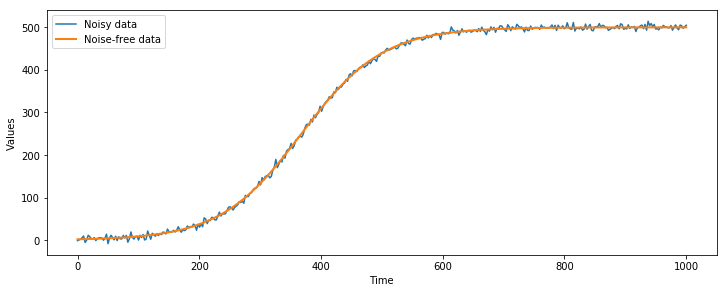

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

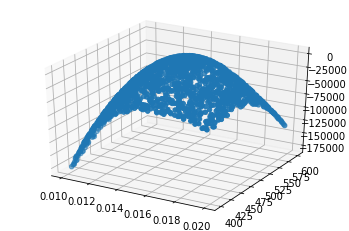

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

#print(max(likelihoods))
#idx = list(likelihoods).index(max(likelihoods))
#print(input_parameters[idx])
#print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=3, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [15]:
emu([0.015, 500])

array([[-1910.4698]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1201.6356945637347

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


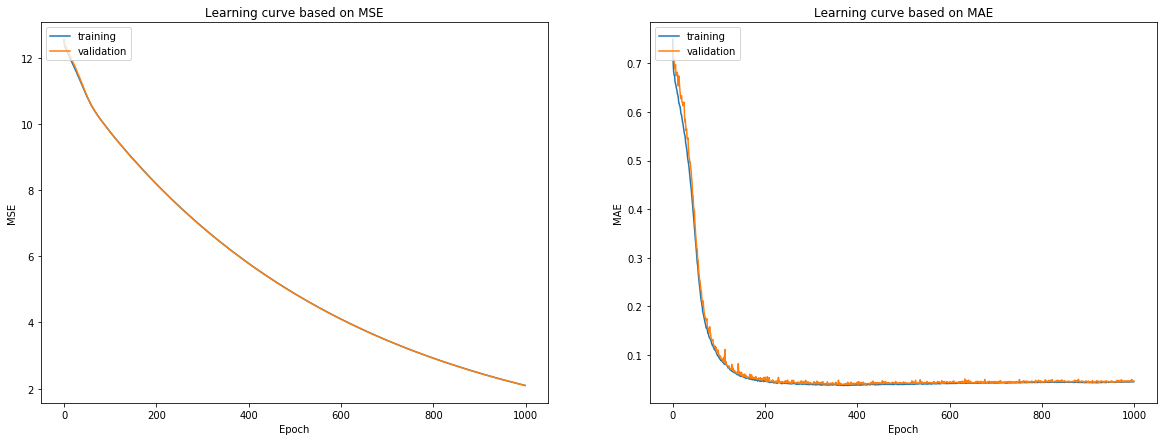

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))                 
ax1.title.set_text('Learning curve based on MSE')
ax2.title.set_text('Learning curve based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

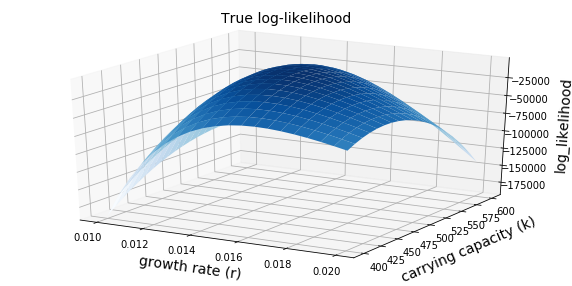

In [18]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

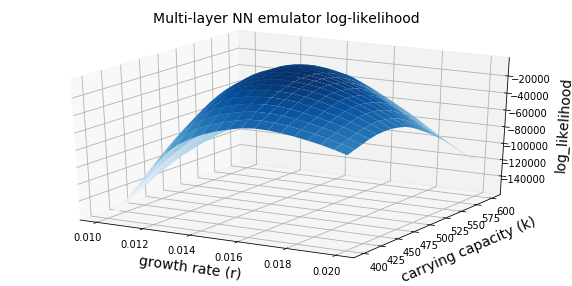

In [19]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [20]:
print(model_prediction.shape
     )
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.04887293801051289

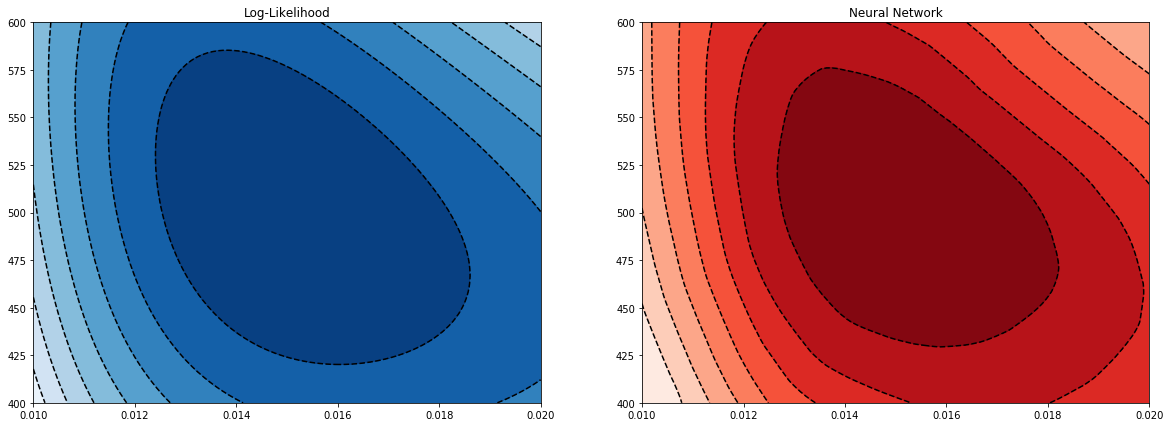

In [21]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

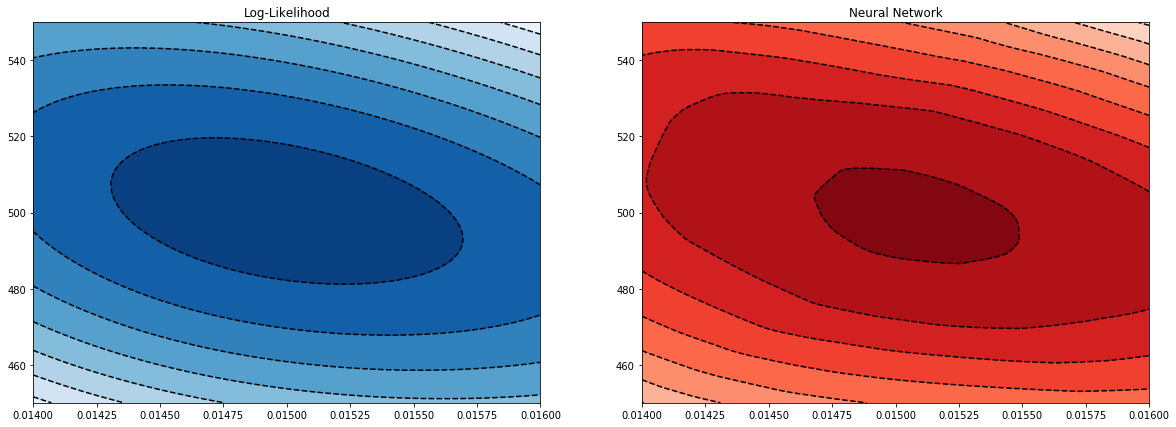

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.014, 450], [0.016, 550], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

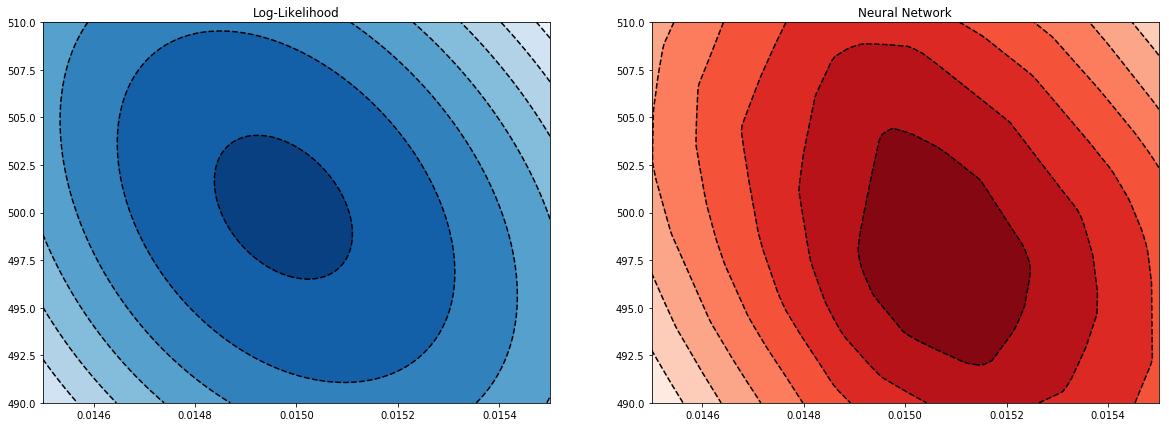

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

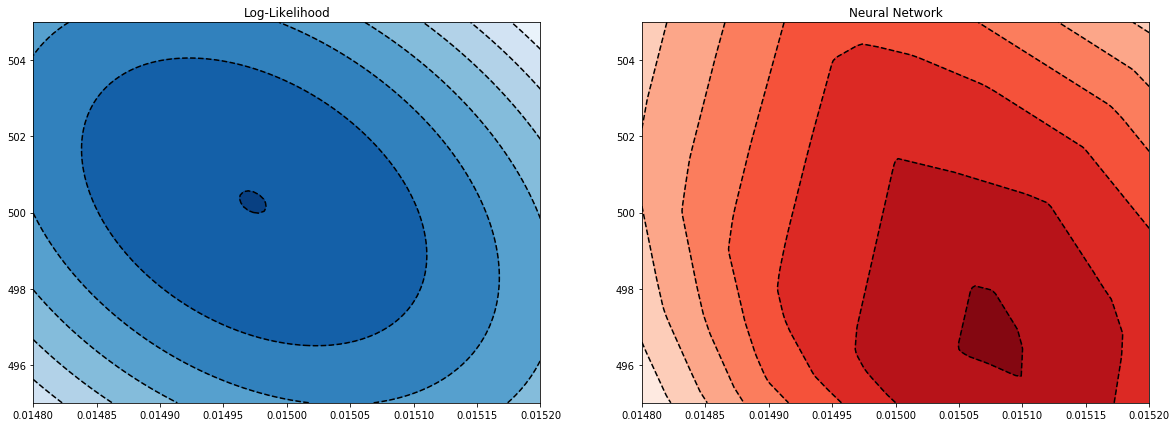

In [24]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0148, 495], [0.0152, 505], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [25]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

Running...
[1.54575262e-02 4.49141918e+02]
-10811.89373704059
accepted


[2.00975967e-02 5.28741192e+02]
-inf


[3.00459665e-02 5.72368298e+02]
-inf


[8.70564119e-03 4.49448708e+02]
-inf


[2.42488824e-02 5.26295127e+02]
-inf


[2.55704610e-02 5.73495451e+02]
-inf


[-5.36866668e-03  4.48417398e+02]
-inf


[1.57253904e-02 5.26318785e+02]
-7364.5491266284225


[3.07511032e-02 5.72005639e+02]
-inf


[7.43808020e-03 4.48519609e+02]
-inf


[3.23450797e-02 5.27766647e+02]
-inf


[2.40039297e-02 5.74276194e+02]
-inf


[1.08615327e-02 4.49297311e+02]
-104118.93412103622


[-3.12172553e-03  5.20484403e+02]
-inf


[5.23096088e-03 5.73412417e+02]
-inf


[8.22256345e-03 4.51354994e+02]
-inf


[1.56740928e-03 5.22256003e+02]
-inf


[1.71498812e-02 5.78067135e+02]
-54823.33734205241


[1.28040879e-02 4.49739696e+02]
-37169.69479862658


[3.00251078e-02 5.25152896e+02]
-inf


[5.44743711e-04 5.74712371e+02]
-inf


[-2.42844681e-03  4.48212749e+02]
-inf


[3.53058908e-03 5.29831118e+02]
-inf


[2.51


[1.88347468e-02 5.13431779e+02]
-38509.2369251565


[2.13971407e-02 5.66650085e+02]
-inf


[1.29307448e-02 4.54401195e+02]
-32151.686351593333


[-1.84223978e-04  5.16279584e+02]
-inf


[3.39767734e-02 5.62319765e+02]
-inf


[1.29764458e-04 4.58344089e+02]
-inf


[5.84095383e-03 5.13347672e+02]
-inf


[1.35710660e-02 5.64957583e+02]
-16427.64127057278


[2.11036776e-02 4.49168797e+02]
-inf


[2.52130400e-02 5.16437582e+02]
-inf


[1.29605235e-02 5.62686571e+02]
-20514.98270146477


[3.05299526e-03 4.57061735e+02]
-inf


[1.86142824e-02 5.12708146e+02]
-34981.54478082353


[8.88371736e-03 5.65937925e+02]
-inf


[9.39969971e-03 4.49268012e+02]
-inf


[4.00315581e-02 5.16492983e+02]
-inf


[6.37683973e-03 5.66009093e+02]
-inf


[2.05980750e-02 4.57452935e+02]
-inf


[3.42769513e-02 5.15449162e+02]
-inf


[-2.74732574e-04  5.71925690e+02]
-inf


[2.03098450e-02 4.57862431e+02]
-inf


[2.38514812e-02 5.12177253e+02]
-inf


[-4.17853955e-03  5.68862773e+02]
-inf


[7.27646996e-03 4.58676231

[1.54074698e-02 4.55747570e+02]
-8450.727828736828


[1.47674602e-02 5.15986591e+02]
-2059.4313516368693
accepted


[1.36758098e-02 5.63582592e+02]
-15481.4384233698


[1.54077633e-02 4.55957184e+02]
-8379.896717992273


[1.52316473e-02 5.15924214e+02]
-2751.960605345533


[1.31595848e-02 5.62827855e+02]
-18538.0251715283


[1.54631540e-02 4.55951537e+02]
-8346.600792237285


[1.46780728e-02 5.15869630e+02]
-2072.9702747770793


[1.39688801e-02 5.62523789e+02]
-14318.691503907352
accepted


[1.57571170e-02 4.56039764e+02]
-8393.731964222274


[1.48861596e-02 5.16052509e+02]
-2116.5940575531854


[1.45094607e-02 5.62365449e+02]
-14684.314408356544


[1.55110927e-02 4.56176505e+02]
-8255.254900568685
accepted


[1.51463603e-02 5.16180880e+02]
-2560.3873331338664


[1.41093179e-02 5.63325698e+02]
-14533.520288679198


[1.52424986e-02 4.56405472e+02]
-8428.14203949718


[1.46418925e-02 5.16179967e+02]
-2129.6226906318243


[1.38628191e-02 5.63073609e+02]
-14722.19718910337


[1.55215990e-0

[1.46398180e-02 5.16803514e+02]
-2194.6783989301593


[1.52665354e-02 4.80968962e+02]
-2534.032439316661


[1.47862156e-02 5.15605233e+02]
-2019.3676462168157


[1.46959809e-02 4.99900280e+02]
-1457.5659110579859
accepted


[1.52306420e-02 4.88715685e+02]
-1706.677304053726


[1.47851496e-02 5.15633596e+02]
-2022.3051718608065


[1.45596032e-02 5.26551790e+02]
-3598.7799355861143


[1.51758764e-02 4.95964661e+02]
-1330.28991140165


[1.48099380e-02 5.15579978e+02]
-2021.1317188913188
accepted


[1.44931625e-02 5.21245604e+02]
-2866.8485011238604


[1.49867389e-02 5.08027485e+02]
-1454.2488518732641


[1.48071045e-02 5.15557144e+02]
-2017.9059262512458
accepted


[1.47011270e-02 5.01354356e+02]
-1419.5516321160067
accepted


[1.49692548e-02 5.15595878e+02]
-2148.7512073922558


[1.47963043e-02 5.15623965e+02]
-2022.8714630225213


[1.46441418e-02 5.03300115e+02]
-1506.0005570069086


[1.50890077e-02 5.00956276e+02]
-1250.4750092866582
accepted


[1.48171634e-02 5.15569173e+02]
-2022.049

-1603.7568139455427


[1.49182778e-02 4.93974002e+02]
-1399.9546551809572


[1.50142603e-02 5.05814726e+02]
-1349.6860638475937


[1.46675176e-02 5.08555123e+02]
-1567.6254963760578


[1.46371773e-02 5.12767645e+02]
-1842.453553336118


[1.50928279e-02 4.98214219e+02]
-1241.6272622094793


[1.46645695e-02 5.05734906e+02]
-1488.6843511789655
accepted


[1.47973903e-02 5.02016870e+02]
-1285.9775053983467


[1.51323882e-02 4.95225135e+02]
-1316.383034757615


[1.45838843e-02 4.98774262e+02]
-1752.2179635095856


[1.46963521e-02 5.07628384e+02]
-1495.860179174454


[1.50286534e-02 5.04419479e+02]
-1299.2032585390687


[1.46267333e-02 5.04471148e+02]
-1540.709639652306


[1.47933736e-02 5.03199999e+02]
-1294.6076466736556


[1.51694831e-02 4.91931457e+02]
-1468.9465642781981


[1.46635525e-02 5.06009146e+02]
-1495.5363289168943


[1.47380796e-02 5.03198492e+02]
-1355.4752786802705


[1.50645014e-02 5.01380517e+02]
-1239.7193729904918


[1.46303328e-02 5.03821399e+02]
-1532.0874239958646


[

[1.50397851e-02 4.99788948e+02]
-1212.4798256739357
accepted


[1.50050298e-02 4.97810764e+02]
-1221.8085829805568


[1.49344688e-02 4.99446172e+02]
-1210.5759256212243


[1.50359660e-02 4.99767363e+02]
-1211.0736813897845
accepted


[1.51150443e-02 4.98691719e+02]
-1254.2058159755322


[1.50799621e-02 5.00850027e+02]
-1242.2522061456775


[1.50153080e-02 5.00152195e+02]
-1205.5577279190434
accepted


[1.48530323e-02 5.00880072e+02]
-1241.7091657835645


[1.49773224e-02 5.02688772e+02]
-1224.9688121580662


[1.50085221e-02 4.99997087e+02]
-1203.7856988463607
accepted


[1.49904769e-02 4.98106008e+02]
-1217.3871666677398


[1.50021863e-02 5.00460888e+02]
-1203.6022287409842


[1.50015199e-02 4.99785218e+02]
-1202.7204804091357
accepted


[1.48003020e-02 5.01117482e+02]
-1286.6499200418787


[1.50233867e-02 4.98711796e+02]
-1211.7020321624823


[1.49750636e-02 5.01287369e+02]
-1204.7191658767467


[1.47063783e-02 5.05725320e+02]
-1428.6544036919288


[1.49063776e-02 4.98709832e+02]
-1233

[1.49861438e-02 4.99874936e+02]
-1201.1327326524138
accepted


[1.50125019e-02 5.00252397e+02]
-1205.1416781935388


[1.4976806e-02 4.9990876e+02]
-1200.8634745889253
accepted


[1.50250828e-02 4.99454526e+02]
-1207.9971614135252


[1.50009217e-02 5.01399029e+02]
-1210.5279309873097


[1.49853890e-02 4.99664162e+02]
-1201.753774264488
accepted


[1.49895070e-02 4.99645307e+02]
-1201.9820365507505
accepted


[1.49530746e-02 5.00883279e+02]
-1202.1423567567797
accepted


[1.50098365e-02 4.99883488e+02]
-1204.014863994655


[1.49959558e-02 5.00262521e+02]
-1201.982933798178
accepted


[1.49708112e-02 5.01593358e+02]
-1207.2069361265424


[1.49903906e-02 4.99100119e+02]
-1205.2608566467406


[1.49751210e-02 4.99958674e+02]
-1200.7545889324902
accepted


[1.49751005e-02 5.01227349e+02]
-1204.23353844786


[1.49991847e-02 5.00173396e+02]
-1202.3208800265038
accepted


[1.49573831e-02 4.99234228e+02]
-1206.952085677255


[1.49706865e-02 4.99620681e+02]
-1202.287405827719
accepted


[1.4981042

[1.49444097e-02 5.00172055e+02]
-1203.2846767639353


[1.49683961e-02 5.00974227e+02]
-1202.1637225632207


[1.49815140e-02 4.99959807e+02]
-1200.7894028183237
accepted


[1.49324211e-02 5.00696937e+02]
-1204.917682322607


[1.49235851e-02 5.01544204e+02]
-1209.4504370889842


[1.50149627e-02 5.00314985e+02]
-1205.9811457352446


[1.49424869e-02 5.00853758e+02]
-1203.2358963168708


[1.49649043e-02 5.00321615e+02]
-1200.577412696214
accepted


[1.49509765e-02 5.00369258e+02]
-1201.8003470864348
accepted


[1.49823563e-02 5.00323194e+02]
-1200.693226371241
accepted


[1.49807292e-02 5.00502133e+02]
-1200.9134307748448
accepted


[1.49677682e-02 5.00200929e+02]
-1200.533546562364
accepted


[1.49874857e-02 5.00748112e+02]
-1202.4957994469705


[1.50235186e-02 4.99536226e+02]
-1207.4277948435404


[1.50067397e-02 4.99477452e+02]
-1204.274876937993


[1.49463910e-02 5.00856224e+02]
-1202.7219421915865


[1.50008085e-02 5.00358411e+02]
-1202.9896892628788


[1.50074382e-02 4.99301369e+02]
-

[1.49535833e-02 5.00971787e+02]
-1202.429267894203


[1.49994914e-02 5.00928373e+02]
-1205.714802308168


[1.49761092e-02 5.00871785e+02]
-1202.002370359181


[1.50198239e-02 4.98491142e+02]
-1213.2492017754123


[1.49865529e-02 5.00318473e+02]
-1200.9990055415597
accepted


[1.49647722e-02 5.00706595e+02]
-1201.0610443158698
accepted


[1.49012737e-02 5.01002276e+02]
-1214.539034288046


[1.49797970e-02 5.00296648e+02]
-1200.5346280829842
accepted


[1.49760844e-02 5.00261888e+02]
-1200.4082411305114
accepted


[1.49626797e-02 5.00080782e+02]
-1201.0570128572106


[1.49862143e-02 5.00554210e+02]
-1201.5337664381561
accepted


[1.49479107e-02 4.97891038e+02]
-1230.5329068355632


[1.49790323e-02 5.00188755e+02]
-1200.4800433424016
accepted


[1.50150559e-02 5.00132685e+02]
-1205.44750063094


[1.49845290e-02 5.00678816e+02]
-1201.8295308317213


[1.49199004e-02 5.00808294e+02]
-1208.1407901214484


[1.49902654e-02 5.00794882e+02]
-1203.1336785863887
accepted


[1.49790911e-02 5.0056013

-1203.2686020197184


[1.49482830e-02 5.00768945e+02]
-1202.304849295256


[1.49817687e-02 5.00357700e+02]
-1200.7010527486257
accepted


[1.49657993e-02 5.00026754e+02]
-1200.961664199351
accepted


[1.49603146e-02 4.99883661e+02]
-1201.9511381773784


[1.49701850e-02 5.00432892e+02]
-1200.4742406211592
accepted


[1.49822533e-02 4.99906394e+02]
-1200.9190691505391
accepted


[1.49909376e-02 4.99964319e+02]
-1201.3063704767271
accepted


[1.49457527e-02 5.01476689e+02]
-1205.8767385635826


[1.49872818e-02 4.99445190e+02]
-1202.843343941881


[1.49812023e-02 4.99705011e+02]
-1201.5319231063809
accepted


[1.49714354e-02 4.99819571e+02]
-1201.3079113096346
accepted


[1.49626928e-02 4.99710010e+02]
-1202.5271880413368


[1.49808993e-02 4.99474812e+02]
-1202.6697923639667
accepted


[1.49587748e-02 5.00854785e+02]
-1201.7077270615027


[1.49631321e-02 4.99926280e+02]
-1201.4918960076493
accepted


[1.49605009e-02 4.98762962e+02]
-1211.7986413795625


[1.49391589e-02 5.00125114e+02]
-120

-1200.7364540173255
accepted


[1.49973765e-02 4.99903767e+02]
-1202.0310997290394


[1.49498498e-02 4.99054410e+02]
-1210.534628760355


[1.49582994e-02 4.99757017e+02]
-1202.8188572890406


[1.49630181e-02 5.02374191e+02]
-1216.8453923190775


[1.49548747e-02 5.00076214e+02]
-1201.9057397320366
accepted


[1.49701736e-02 4.99943248e+02]
-1200.94661052706
accepted


[1.49729548e-02 5.01542679e+02]
-1206.893000578501


[1.50003551e-02 4.99893465e+02]
-1202.4255247990807
accepted


[1.49019424e-02 4.99829348e+02]
-1219.8845947097427


[1.49654942e-02 4.99472145e+02]
-1203.7130989826526


[1.50184961e-02 4.99917693e+02]
-1205.9702401031805


[1.49340756e-02 4.99810546e+02]
-1207.598429409762


[1.49859564e-02 5.00090749e+02]
-1200.8381134096387
accepted


[1.50153900e-02 4.99762237e+02]
-1205.2219037740738


[1.50000816e-02 4.99867902e+02]
-1202.4131363801575
accepted


[1.49715842e-02 5.00413242e+02]
-1200.4513034759602
accepted


[1.50184393e-02 4.99822405e+02]
-1205.9123979081003


[1

[1.49583627e-02 4.99644541e+02]
-1203.475031017653


[1.50179467e-02 5.00418474e+02]
-1207.2586820834908


[1.49124935e-02 5.00583467e+02]
-1210.853534336058


[1.49802631e-02 4.99773449e+02]
-1201.2732434135598


[1.50014187e-02 5.00015773e+02]
-1202.5429652984
accepted


[1.49617502e-02 5.00569335e+02]
-1200.8674659652897
accepted


[1.50153352e-02 5.00454883e+02]
-1206.695466299066


[1.50229529e-02 4.99942644e+02]
-1207.1908406861144


[1.50177582e-02 5.00138910e+02]
-1206.159676159914


[1.49535282e-02 4.98727861e+02]
-1213.8762697599377


[1.5014201e-02 5.0063585e+02]
-1207.4004153359826


[1.49636775e-02 5.00468121e+02]
-1200.6675051525478
accepted


[1.49923767e-02 5.00359528e+02]
-1201.699894936231


[1.50384265e-02 5.00595576e+02]
-1215.8117504872332


[1.49380166e-02 5.02619193e+02]
-1219.7362538480445


[1.49852635e-02 4.98689622e+02]
-1209.4979550816026


[1.49722628e-02 4.99484941e+02]
-1202.994125884346
accepted


[1.49650241e-02 5.00175120e+02]
-1200.7037978885642
accep

[1.49921800e-02 4.98174586e+02]
-1216.1890437726586


[1.50076743e-02 5.00407342e+02]
-1204.5522723146441


[1.49056150e-02 5.01762714e+02]
-1215.4364033018103


[1.49722075e-02 5.00485721e+02]
-1200.5499483551807
accepted


[1.50063567e-02 5.00605204e+02]
-1205.177819586955


[1.49949232e-02 4.99272766e+02]
-1204.1498189230356


[1.49803257e-02 4.99796614e+02]
-1201.194581774634


[1.49247000e-02 5.00631156e+02]
-1206.8831783823007


[1.49876448e-02 4.99563225e+02]
-1202.2505904907207


[1.49203890e-02 5.01663652e+02]
-1210.9116620303384


[1.49431805e-02 5.00260097e+02]
-1203.2608079936672


[1.49611906e-02 5.01494756e+02]
-1205.6651071527979


[1.49805385e-02 5.01294746e+02]
-1205.4050153250641


[1.49457946e-02 5.00063760e+02]
-1203.4130815032413


[1.49792472e-02 5.01293816e+02]
-1205.232773696535


[1.49479561e-02 5.01111693e+02]
-1203.475677480479


[1.49658316e-02 5.00435706e+02]
-1200.5610695855328
accepted


[1.49988155e-02 5.00974232e+02]
-1205.9186447721484


[1.49792459e-0

[1.50141310e-02 5.00082843e+02]
-1205.1180163505087


[1.49964591e-02 5.01759161e+02]
-1213.920511410133


[1.49415271e-02 5.00828533e+02]
-1203.329031003667


[1.49492961e-02 5.01246411e+02]
-1204.083167532198


[1.50481532e-02 5.00717929e+02]
-1221.4525702638641


[1.49422194e-02 5.00439376e+02]
-1203.0931262907686


[1.49971897e-02 5.00531063e+02]
-1202.9635010041982


[1.49835888e-02 5.00717038e+02]
-1201.8984394400397
accepted


[1.49633177e-02 4.99192774e+02]
-1206.3525847895062


[1.49455950e-02 4.99782144e+02]
-1204.9049620412761


[1.50249450e-02 5.02164248e+02]
-1231.4447804292356


[1.50016952e-02 4.99399245e+02]
-1203.9801970467825


[1.49473815e-02 5.01910216e+02]
-1209.8315674764656


[1.49531586e-02 5.01030588e+02]
-1202.706580831233
accepted


[1.49528849e-02 4.99995121e+02]
-1202.4759430720355


[1.49490074e-02 5.01095595e+02]
-1203.3091749955877


[1.49961612e-02 5.01198579e+02]
-1207.2718926647597


[1.49497104e-02 4.98435421e+02]
-1219.4846662720006


[1.50016237e-0

[1.49505358e-02 5.00160542e+02]
-1202.2707449285465


[1.49042055e-02 5.01284680e+02]
-1213.7743816166028


[1.49969932e-02 4.99975220e+02]
-1201.9311163264383


[1.49476434e-02 5.00314973e+02]
-1202.362032124084


[1.50538816e-02 4.99349531e+02]
-1217.9376444803506


[1.49293065e-02 5.01091769e+02]
-1206.185102545005


[1.49524952e-02 5.01400120e+02]
-1204.937202560316


[1.48724076e-02 5.00445490e+02]
-1231.290704486173


[1.48983860e-02 5.01402454e+02]
-1216.2292133124733


[1.49655553e-02 5.02698451e+02]
-1222.9054202825396


[1.50292734e-02 4.99577808e+02]
-1208.930670510014


[1.50211968e-02 5.00547399e+02]
-1208.9706010460814


[1.49398656e-02 5.00252876e+02]
-1203.9485091359927


[1.49856139e-02 5.00187411e+02]
-1200.808671426177
accepted


[1.50371583e-02 4.99624206e+02]
-1211.4086044647754


[1.50089497e-02 5.01658251e+02]
-1216.2941761129923


[1.49661712e-02 4.99312862e+02]
-1204.874773176025


[1.49593344e-02 4.99782252e+02]
-1202.547673856084


[1.49039817e-02 4.99945456e

[1.50262222e-02 5.00420198e+02]
-1209.888363762781


[1.49678856e-02 4.99657643e+02]
-1202.3006662203668


[1.49944173e-02 5.00493486e+02]
-1202.3734656938225
accepted


[1.49545092e-02 5.02672748e+02]
-1221.1168061867063


[1.49811218e-02 5.00967016e+02]
-1202.983906143139


[1.49729246e-02 4.99696897e+02]
-1201.7616054509863
accepted


[1.49742041e-02 5.01696936e+02]
-1208.728828706525


[1.50022626e-02 4.99876681e+02]
-1202.7129852322544


[1.49310336e-02 4.99833171e+02]
-1208.3339822049247


[1.50253697e-02 5.01561776e+02]
-1221.2255210093545


[1.49882235e-02 4.99204686e+02]
-1204.4270387730298


[1.49964215e-02 5.00494020e+02]
-1202.6905361129932
accepted


[1.49850990e-02 5.02795871e+02]
-1229.1888071587991


[1.49645411e-02 4.99892325e+02]
-1201.4937837700688


[1.50049469e-02 4.98894881e+02]
-1207.66614473504


[1.49550910e-02 5.01050403e+02]
-1202.6894767244844


[1.49648583e-02 5.00554024e+02]
-1200.7251225593827
accepted


[1.50333774e-02 5.01925654e+02]
-1231.074396818979


[1.49759101e-02 4.99422864e+02]
-1203.1765650316404
accepted


[1.49860917e-02 5.01268325e+02]
-1205.9847637559294


[1.50747022e-02 4.98221806e+02]
-1232.2943736065301


[1.49682777e-02 4.99618619e+02]
-1202.486438047747
accepted


[1.50405512e-02 4.99631626e+02]
-1212.6118395841843


[1.49303127e-02 5.00694281e+02]
-1205.4014046692428


[1.49439808e-02 5.00007709e+02]
-1204.0141670953333
accepted


[1.49533064e-02 5.00814309e+02]
-1201.9175194640766


[1.49440203e-02 4.99406231e+02]
-1208.2457007155574


[1.49322458e-02 5.02078193e+02]
-1212.7279119361376


[1.49319084e-02 4.99711624e+02]
-1208.9853362525253


[1.49931011e-02 5.00924798e+02]
-1204.418377875825


[1.49373434e-02 4.99979682e+02]
-1205.6718735034085


[1.49572275e-02 4.99914743e+02]
-1202.1953340738573


[1.50192348e-02 4.99064488e+02]
-1208.3524761583021


[1.49653916e-02 4.98562211e+02]
-1213.6373277797895


[1.49873782e-02 5.00344106e+02]
-1201.1150197855525
accepted


[1.49978630e-02 4.98949174e+02]
-1206.7406416344

-1203.9708303066773
accepted


[1.49440429e-02 5.01304386e+02]
-1204.8671411203065


[1.49413479e-02 4.99173477e+02]
-1211.4339360700635


[1.49611838e-02 5.00991850e+02]
-1202.2088492783462
accepted


[1.49211915e-02 5.01317731e+02]
-1208.8219996509454


[1.4936640e-02 5.0043645e+02]
-1204.211012611736


[1.49607761e-02 4.99838649e+02]
-1202.0976995021445
accepted


[1.49412995e-02 5.00146143e+02]
-1203.9998358058435


[1.49297675e-02 5.01003736e+02]
-1205.8550050964163


[1.49747284e-02 4.99789235e+02]
-1201.2933360644054
accepted


[1.49353979e-02 5.01030854e+02]
-1204.8298956816877


[1.49488045e-02 4.99228679e+02]
-1208.8368337477002


[1.50152762e-02 5.00675190e+02]
-1207.971199943289


[1.49590600e-02 5.00128677e+02]
-1201.2733320082446
accepted


[1.50293521e-02 4.99894109e+02]
-1209.0386862053103


[1.49787047e-02 4.99146831e+02]
-1205.1521790951183


[1.50079274e-02 5.00686798e+02]
-1206.0364467433737


[1.49234566e-02 5.00425837e+02]
-1207.6599217915739


[1.49607828e-02 4.9

-1201.8759094999718
accepted


[1.49080416e-02 5.00020044e+02]
-1215.4455213186475


[1.49665128e-02 4.99656490e+02]
-1202.4292764348622
accepted


[1.49349705e-02 5.02955164e+02]
-1225.6296251595331


[1.49474269e-02 5.01039633e+02]
-1203.2096785766867


[1.49594105e-02 4.99811889e+02]
-1202.3885563444028
accepted


[1.49416405e-02 5.00159118e+02]
-1203.880918499645
accepted


[1.49557902e-02 5.00713842e+02]
-1201.48365902207
accepted


[1.49338804e-02 5.00024098e+02]
-1206.3347163922567


[1.49373074e-02 5.00431213e+02]
-1204.0762244266277
accepted


[1.49352101e-02 5.00559946e+02]
-1204.3617018768164


[1.49686301e-02 5.01419642e+02]
-1205.3406813181964


[1.48910858e-02 5.01013528e+02]
-1218.8974148870827


[1.49168217e-02 5.00248991e+02]
-1210.544633397279


[1.50000729e-02 4.99736335e+02]
-1202.6256970702204
accepted


[1.49212638e-02 5.00312217e+02]
-1208.7419465451153


[1.49676363e-02 5.02141249e+02]
-1213.778910549306


[1.50297625e-02 4.99487967e+02]
-1209.1955669136557


[1

[1.49775868e-02 4.98847578e+02]
-1208.229227388368


[1.50086317e-02 4.98664844e+02]
-1210.146252201001


[1.50103659e-02 4.98720146e+02]
-1209.7642545110912


[1.49824700e-02 5.01366388e+02]
-1206.3406824738338


[1.49426022e-02 5.00251909e+02]
-1203.394207178678


[1.49711480e-02 4.99927301e+02]
-1200.9510976583936
accepted


[1.49844129e-02 5.00629735e+02]
-1201.6202498466084


[1.49870818e-02 5.00430507e+02]
-1201.2656839549343
accepted


[1.49325548e-02 4.99915051e+02]
-1207.3366149285039


[1.49904623e-02 5.00482891e+02]
-1201.7916613761038


[1.50387151e-02 4.99619969e+02]
-1211.950321134773


[1.49756627e-02 5.01131149e+02]
-1203.558468965601


[1.49606737e-02 5.00914076e+02]
-1201.8702555710092


[1.49939828e-02 4.99889503e+02]
-1201.6780304477152
accepted


[1.49703393e-02 4.99247722e+02]
-1204.9559160146493


[1.49560793e-02 4.98400761e+02]
-1218.2744343078482


[1.49756560e-02 5.00142551e+02]
-1200.4484965050615
accepted


[1.49199267e-02 5.00438025e+02]
-1208.7276329175097



[1.49256785e-02 4.99432781e+02]
-1213.7190222989689


[1.49743819e-02 5.01277009e+02]
-1204.5691837121926


[1.50150279e-02 4.99693255e+02]
-1205.2106739737862


[1.48951071e-02 5.00647693e+02]
-1217.8241679644339


[1.49361348e-02 4.99903516e+02]
-1206.4210872760968


[1.50154609e-02 4.99997456e+02]
-1205.3054753896674


[1.49788786e-02 4.99851732e+02]
-1201.0174016130725
accepted


[1.49943437e-02 4.99146803e+02]
-1204.9932526580478


[1.49444182e-02 5.00304558e+02]
-1202.9257998773019


[1.49855238e-02 4.99873833e+02]
-1201.106759486688
accepted


[1.49579672e-02 5.00423302e+02]
-1201.0152517773872
accepted


[1.49641987e-02 4.97843539e+02]
-1226.5344712327915


[1.49961957e-02 4.99848558e+02]
-1201.9674887034425
accepted


[1.49490869e-02 4.99835786e+02]
-1203.881868219057
accepted


[1.49246374e-02 4.99592203e+02]
-1212.4765875114842


[1.49915755e-02 5.00651021e+02]
-1202.5913780514582
accepted


[1.49609788e-02 4.99500984e+02]
-1204.082397115343
accepted


[1.49597988e-02 5.00

[1.49768853e-02 5.00298242e+02]
-1200.4363143468256
accepted


[1.49809124e-02 4.98685200e+02]
-1209.854364077297


[1.49789170e-02 4.99527312e+02]
-1202.4118822470266


[1.49941310e-02 4.99561034e+02]
-1202.594107240303


[1.4971172e-02 4.9981584e+02]
-1201.3355599464935
accepted


[1.50366296e-02 5.00078418e+02]
-1212.0530871385804


[1.49786547e-02 5.01798522e+02]
-1210.6111211279563


[1.49788172e-02 5.00679858e+02]
-1201.3379749561657
accepted


[1.49146788e-02 5.01341069e+02]
-1210.6215205337671


[1.49516139e-02 5.00341894e+02]
-1201.748700876148


[1.49686611e-02 5.01955880e+02]
-1211.3021202393775


[1.49860079e-02 5.01997451e+02]
-1214.8086779983419


[1.50069470e-02 4.99962193e+02]
-1203.4686550585052


[1.49634846e-02 4.99221896e+02]
-1206.0505874083194


[1.49950566e-02 5.00355064e+02]
-1202.051742494695


[1.49731727e-02 5.00983746e+02]
-1202.4239656847817


[1.49925590e-02 5.00059882e+02]
-1201.4014206428262
accepted


[1.49340141e-02 5.01186103e+02]
-1205.623829852139



[1.49788526e-02 5.00237164e+02]
-1200.4729211684214
accepted


[1.49476351e-02 5.00824991e+02]
-1202.4996916028692
accepted


[1.49717327e-02 4.99997674e+02]
-1200.7397210134125
accepted


[1.49536498e-02 4.98469751e+02]
-1217.7863677411708


[1.49478672e-02 5.00303534e+02]
-1202.3478501859454
accepted


[1.49798448e-02 5.00136962e+02]
-1200.5249296919012
accepted


[1.50175616e-02 4.99467089e+02]
-1206.21752215666


[1.4908600e-02 4.9921636e+02]
-1223.8037920715726


[1.49892388e-02 5.02497002e+02]
-1224.255474787726


[1.49698351e-02 5.00934674e+02]
-1202.003160447235


[1.49338011e-02 5.00188815e+02]
-1205.5902868451055


[1.50188717e-02 5.00348237e+02]
-1207.2016229901242


[1.49892910e-02 4.99841294e+02]
-1201.3836062314551
accepted


[1.50425819e-02 4.99729386e+02]
-1213.4552479768442


[1.49646061e-02 5.00169845e+02]
-1200.7375060469142
accepted


[1.49634298e-02 4.99333414e+02]
-1205.0623284890614


[1.49764584e-02 5.01411156e+02]
-1205.9749054625588


[1.49518470e-02 4.9837962

-1204.0940397656454


[1.50106700e-02 4.99490184e+02]
-1204.8430729117308


[1.50122013e-02 5.00463669e+02]
-1205.8969004647993


[1.49750627e-02 5.00135275e+02]
-1200.4539768486695
accepted


[1.49972186e-02 5.00592593e+02]
-1203.2350188521991


[1.49484067e-02 5.00331005e+02]
-1202.2165690528188
accepted


[1.50561753e-02 4.99792750e+02]
-1219.4354798970655


[1.49686501e-02 4.99663998e+02]
-1202.2035539559802


[1.49741242e-02 4.99672286e+02]
-1201.8229770143664
accepted


[1.49405185e-02 4.99217225e+02]
-1211.1754363761358


[1.49580347e-02 5.01921734e+02]
-1210.0498948798447


[1.49626101e-02 4.99227120e+02]
-1206.1334982043772


[1.50072412e-02 5.00601332e+02]
-1205.366474734724


[1.49607253e-02 4.99669615e+02]
-1202.9961611220476


[1.49823659e-02 4.99610733e+02]
-1201.9419900821658


[1.49293767e-02 4.99212944e+02]
-1214.8953699538688


[1.48705566e-02 5.00971500e+02]
-1229.8264261342379


[1.49287338e-02 4.99655842e+02]
-1210.4681021885096


[1.50197714e-02 5.00893641e+02]
-1

[1.49528890e-02 5.00880777e+02]
-1202.1484814217804
accepted


[1.49769330e-02 5.00897561e+02]
-1202.196325267839


[1.4963641e-02 5.0053179e+02]
-1200.7347002055076
accepted


[1.49550584e-02 5.00504451e+02]
-1201.2867650101168
accepted


[1.49489744e-02 5.00130330e+02]
-1202.6091059804698
accepted


[1.49739142e-02 5.00655262e+02]
-1200.9954207492153
accepted


[1.49248871e-02 5.00499120e+02]
-1207.0511969534155


[1.49828306e-02 4.99871797e+02]
-1201.01639491971
accepted


[1.50300353e-02 5.00299395e+02]
-1210.5837299995221


[1.49856614e-02 5.01177592e+02]
-1205.1206780788223


[1.50124453e-02 4.99867196e+02]
-1204.5476508761587


[1.50214146e-02 5.00090301e+02]
-1207.044302963083


[1.49268614e-02 5.01099553e+02]
-1206.7380979756915


[1.49972185e-02 4.99888916e+02]
-1202.0283935763262


[1.49836471e-02 4.99490739e+02]
-1202.5544085457004


[1.49839598e-02 5.00337325e+02]
-1200.8186603063307
accepted


[1.49417841e-02 4.99542527e+02]
-1207.590386644592


[1.49269140e-02 5.01565388

[1.50090703e-02 4.99023534e+02]
-1207.0667262142451


[1.49792492e-02 4.99659062e+02]
-1201.7374392891984
accepted


[1.49807934e-02 4.99057914e+02]
-1205.8361739162315


[1.49852120e-02 5.00422486e+02]
-1201.0719582290355
accepted


[1.50023508e-02 4.98303732e+02]
-1214.1187641595968


[1.50340755e-02 4.98946540e+02]
-1212.4256121068254


[1.50099861e-02 5.01652766e+02]
-1216.5702346533044


[1.49891752e-02 4.99925331e+02]
-1201.2191964583594
accepted


[1.49659306e-02 4.99075003e+02]
-1207.142983004287


[1.49920639e-02 4.99713130e+02]
-1201.906474722797


[1.49777903e-02 4.99681070e+02]
-1201.6632941916787
accepted


[1.50241081e-02 4.98226983e+02]
-1216.9322955770392


[1.49541495e-02 5.01404610e+02]
-1204.9192970797387


[1.49415658e-02 4.98489447e+02]
-1221.2001925154118


[1.49987452e-02 4.99052500e+02]
-1205.9275897736447


[1.50068829e-02 5.00287462e+02]
-1203.9687683045915


[1.49723015e-02 5.00055486e+02]
-1200.6008237296653
accepted


[1.49862042e-02 5.02241891e+02]
-1218.7

-1201.6462910279806


[1.49418073e-02 5.01192831e+02]
-1204.5114684769624


[1.49430617e-02 5.01857280e+02]
-1209.44506135565


[1.50104198e-02 5.00557121e+02]
-1205.9136482199779


[1.49449613e-02 5.00889658e+02]
-1202.984717948216


[1.49821292e-02 5.00562876e+02]
-1201.1843371808343
accepted


[1.49350213e-02 5.00563587e+02]
-1204.399551922057


[1.49545445e-02 4.99996385e+02]
-1202.2288774331876


[1.50145004e-02 5.00523984e+02]
-1206.8238746292168


[1.50033494e-02 5.01031058e+02]
-1207.4529248370147


[1.49517123e-02 5.00323217e+02]
-1201.760626539648


[1.49635863e-02 4.99765084e+02]
-1202.1435296562445
accepted


[1.50156999e-02 4.99172215e+02]
-1207.0957228806226


[1.50130896e-02 5.00180959e+02]
-1205.0829077056521


[1.49421947e-02 4.99915146e+02]
-1204.8680183382887


[1.50308954e-02 5.00123361e+02]
-1210.1384614613412


[1.49319825e-02 5.00676441e+02]
-1205.017677641046


[1.49306331e-02 4.98740130e+02]
-1221.1049136241554


[1.49770738e-02 5.01577192e+02]
-1207.7477067354

[1.50394329e-02 4.99526838e+02]
-1212.2257005057215


[1.49967933e-02 4.98187782e+02]
-1215.8017479485889


[1.49521022e-02 5.00442511e+02]
-1201.60464113629


[1.49047748e-02 5.01689361e+02]
-1215.2489928227756


[1.50838194e-02 4.99064109e+02]
-1233.2147950117437


[1.49722463e-02 5.00133764e+02]
-1200.4805884039051
accepted


[1.48737886e-02 5.00922333e+02]
-1228.0704267141698


[1.51000924e-02 4.98386833e+02]
-1244.931579706336


[1.49461362e-02 4.99581987e+02]
-1206.2058705947259


[1.49408382e-02 4.99878561e+02]
-1205.3907242826822


[1.49388326e-02 5.00896003e+02]
-1203.8952101638008
accepted


[1.50148792e-02 4.99200341e+02]
-1206.802971633394


[1.49541800e-02 5.01027816e+02]
-1202.6326249805013


[1.49453572e-02 5.01030575e+02]
-1203.3927572096004
accepted


[1.49791001e-02 5.00508580e+02]
-1200.829273919692
accepted


[1.49307465e-02 5.00875162e+02]
-1205.4092021186186


[1.49698345e-02 5.01920380e+02]
-1210.9674254515096


[1.49948386e-02 5.00699894e+02]
-1203.349506332271


[1.49877434e-02 4.98932458e+02]
-1206.7738635640408


[1.50256787e-02 5.00278289e+02]
-1208.9977004385403


[1.49527230e-02 5.01863629e+02]
-1209.2506481804776


[1.48917895e-02 5.00409021e+02]
-1220.5274229611896


[1.49332409e-02 5.00169650e+02]
-1205.8133589603967


[1.49939818e-02 4.99647089e+02]
-1202.2612044726789
accepted


[1.49642805e-02 5.00391604e+02]
-1200.6029569329742
accepted


[1.50107345e-02 4.99062022e+02]
-1207.0081795033357


[1.49628965e-02 4.98300779e+02]
-1218.2815625796777


[1.49565459e-02 4.99720443e+02]
-1203.2787890888935


[1.49715480e-02 4.97933885e+02]
-1223.0431110133306


[1.49616267e-02 4.99352722e+02]
-1205.1590634357963


[1.49285493e-02 5.00884124e+02]
-1205.9150086680359


[1.50434219e-02 4.98111390e+02]
-1222.2423947738446


[1.49831121e-02 4.98048790e+02]
-1219.0597833983734


[1.49483020e-02 5.00702165e+02]
-1202.191205338657


[1.49606814e-02 5.00661802e+02]
-1201.0813200352457
accepted


[1.50278988e-02 4.99345551e+02]
-1209.022382356525


[1.


[1.49364885e-02 5.00227491e+02]
-1204.7860393013373
accepted


[1.50268707e-02 4.97798801e+02]
-1223.3639715053373


[1.49118719e-02 5.01929834e+02]
-1214.9325949622682


[1.50259098e-02 5.00325910e+02]
-1209.2928004541664


[1.50603362e-02 4.99259406e+02]
-1220.8593265321224


[1.49544380e-02 5.00481424e+02]
-1201.342235752492
accepted


[1.49498633e-02 5.00107615e+02]
-1202.538215531016
accepted


[1.50251275e-02 4.99338672e+02]
-1208.3391944772882


[1.48895469e-02 5.01335931e+02]
-1219.7229550573902


[1.50038787e-02 5.01526759e+02]
-1212.9079368121725


[1.49831212e-02 4.99186432e+02]
-1204.6271823604945
accepted


[1.50142408e-02 4.98923158e+02]
-1208.4943191487957


[1.48350776e-02 5.00979760e+02]
-1255.0368791845021


[1.49640202e-02 4.99823384e+02]
-1201.8265986646913
accepted


[1.49834913e-02 4.99747714e+02]
-1201.4001932558767
accepted


[1.49825141e-02 5.00579257e+02]
-1201.2676817206468
accepted


[1.49811322e-02 4.98283120e+02]
-1215.4399939443294


[1.50027481e-02 4.99

[1.49029154e-02 5.01575836e+02]
-1215.2619508962919


[1.50046334e-02 5.01357119e+02]
-1211.076193887277


[1.49835325e-02 4.96998992e+02]
-1241.6520706307736


[1.49907423e-02 4.99834482e+02]
-1201.49842956603
accepted


[1.48636297e-02 5.01660214e+02]
-1233.648081127192


[1.49167696e-02 4.99983546e+02]
-1212.151243338536


[1.49819302e-02 4.98086171e+02]
-1218.5628909288446


[1.49478139e-02 5.00036672e+02]
-1203.1484694327376


[1.49408827e-02 5.01485898e+02]
-1206.3722788072366


[1.50101287e-02 4.99542490e+02]
-1204.5894513924557


[1.50145778e-02 4.99498798e+02]
-1205.524241707851


[1.49375273e-02 5.00571360e+02]
-1203.870791319039


[1.50150287e-02 5.00057965e+02]
-1205.2904234714792


[1.49108288e-02 5.00418408e+02]
-1212.013603718975


[1.49749070e-02 4.98394769e+02]
-1214.53266799952


[1.50457348e-02 4.98740863e+02]
-1217.1368820224945


[1.49659869e-02 5.02042493e+02]
-1212.1879025777864


[1.50041565e-02 5.01031548e+02]
-1207.6622223611155


[1.49313714e-02 5.02197374e+0

-1203.829410408627


[1.49755720e-02 4.99031832e+02]
-1206.4564165388608


[1.49824571e-02 4.99710485e+02]
-1201.5192531075313


[1.49853251e-02 5.00564417e+02]
-1201.4769501500532


[1.50246183e-02 4.98558311e+02]
-1213.3313246887299


[1.50481338e-02 5.00593380e+02]
-1220.2782519377547


[1.49736307e-02 5.00692129e+02]
-1201.106222577075
accepted


[1.49376021e-02 4.98757613e+02]
-1218.231466114816


[1.49297650e-02 4.99614347e+02]
-1210.49443345969


[1.49923731e-02 5.00581535e+02]
-1202.4063312154187


[1.50325170e-02 4.97506636e+02]
-1229.010609356564


[1.49930312e-02 4.99965036e+02]
-1201.4977955591385


[1.49519237e-02 5.00671666e+02]
-1201.7450184857
accepted


[1.49185058e-02 5.00675324e+02]
-1208.6568256605817


[1.49668335e-02 4.99600993e+02]
-1202.7212489487204
accepted


[1.48958241e-02 5.01591593e+02]
-1217.883848784198


[1.49144721e-02 4.99054654e+02]
-1223.280467685345


[1.50341449e-02 4.98126807e+02]
-1219.9315902313908


[1.49205698e-02 5.01341700e+02]
-1209.074090

[1.50280267e-02 4.99865486e+02]
-1208.584688343946


[1.50161528e-02 5.01056014e+02]
-1211.4283075551816


[1.49280735e-02 5.02350067e+02]
-1216.493762917725


[1.50013695e-02 5.00405665e+02]
-1203.2431943184677


[1.50082598e-02 5.01683383e+02]
-1216.4211671555224


[1.49752585e-02 4.99076986e+02]
-1206.042997419539


[1.49990456e-02 4.99297343e+02]
-1204.2743091922537


[1.49979409e-02 5.01234588e+02]
-1208.0249440615914


[1.49831677e-02 4.98989479e+02]
-1206.3684847702973


[1.49958974e-02 4.99703185e+02]
-1202.253118918715
accepted


[1.49684818e-02 4.99650421e+02]
-1202.2906809470135


[1.49903817e-02 4.99933751e+02]
-1201.2976295772157


[1.49310451e-02 5.00036243e+02]
-1207.0566304244817


[1.49943680e-02 5.00185888e+02]
-1201.6635364694716
accepted


[1.49064777e-02 5.00012958e+02]
-1216.1866374088352


[1.49407652e-02 4.99509780e+02]
-1208.1452631777217


[1.49724292e-02 5.00210103e+02]
-1200.4080998113734
accepted


[1.50131111e-02 5.00040313e+02]
-1204.8100770332567


[1.50

[1.50155170e-02 4.98097809e+02]
-1217.6679047469672


[1.50209350e-02 4.99908664e+02]
-1206.5957310573233


[1.50029887e-02 5.00592509e+02]
-1204.3578798793503


[1.50112182e-02 4.98187067e+02]
-1216.0942357324393


[1.49239495e-02 5.00452211e+02]
-1207.4388157397814


[1.49446321e-02 4.99741869e+02]
-1205.3787046587147


[1.50455583e-02 4.99421366e+02]
-1214.5365091985057


[1.50182760e-02 4.99903356e+02]
-1205.9036985454593


[1.49931913e-02 5.00004254e+02]
-1201.4858480702453
accepted


[1.50128170e-02 4.99444037e+02]
-1205.3717175368608


[1.49500757e-02 5.01292230e+02]
-1204.312791850487


[1.49717081e-02 5.01709248e+02]
-1208.577826549333


[1.50078348e-02 4.99668057e+02]
-1203.8920107746721


[1.50399775e-02 4.99391645e+02]
-1212.5668290913877


[1.49891861e-02 4.98828891e+02]
-1207.7909484747024


[1.50187874e-02 5.00262381e+02]
-1206.8304183788794


[1.50102779e-02 5.00770756e+02]
-1207.2136068089492


[1.49593093e-02 5.00213222e+02]
-1201.0786411269548
accepted


[1.50069345e

[1.49336979e-02 5.01001889e+02]
-1205.058763707584


[1.49751293e-02 4.99996682e+02]
-1200.6683537305335
accepted


[1.50265290e-02 4.98748208e+02]
-1212.009364047178


[1.49541374e-02 5.01157135e+02]
-1203.289047407542


[1.49573375e-02 4.99221025e+02]
-1207.0905583712533


[1.49276245e-02 4.99329100e+02]
-1214.1567042701267


[1.50270308e-02 5.01011075e+02]
-1214.9391240458533


[1.49976150e-02 4.99326576e+02]
-1203.9953442513606


[1.50421725e-02 4.98207452e+02]
-1220.8163216153546


[1.49460810e-02 5.01284183e+02]
-1204.5586169255114


[1.50024206e-02 5.00817413e+02]
-1205.5724645535072


[1.49879059e-02 4.98464504e+02]
-1212.2135533709502


[1.50159977e-02 5.01068152e+02]
-1211.4978513472643


[1.49821433e-02 5.00960705e+02]
-1203.0567616208507


[1.49766945e-02 5.01267859e+02]
-1204.7194620473022


[1.50106199e-02 5.00632559e+02]
-1206.39643488038
accepted


[1.49968883e-02 4.99884092e+02]
-1201.9955238352834


[1.49674585e-02 4.98666015e+02]
-1211.8024325254212


[1.49725897e-02



[1.4976427e-02 5.0184256e+02]
-1210.8326134893932


[1.49919894e-02 5.00544381e+02]
-1202.2058443431229


[1.49639566e-02 4.99627114e+02]
-1202.8626927304304


[1.49806582e-02 5.00315705e+02]
-1200.5906853984766
accepted


[1.50028485e-02 4.99842313e+02]
-1202.8328921873656


[1.49683585e-02 4.98378659e+02]
-1215.8705199343776


[1.49757309e-02 5.00701830e+02]
-1201.2339825284544
accepted


[1.49997939e-02 4.99687676e+02]
-1202.7074909793153


[1.49356931e-02 5.00792596e+02]
-1204.28991970231


[1.50427010e-02 4.97864867e+02]
-1225.242342469971


[1.50171166e-02 5.00946114e+02]
-1210.6998086390963


[1.49954252e-02 5.01922697e+02]
-1216.0336654350117


[1.49718660e-02 5.00758085e+02]
-1201.2839661480411
accepted


[1.49818828e-02 4.99729428e+02]
-1201.4418393454077


[1.49165707e-02 5.00592863e+02]
-1209.4225004055909


[1.50185559e-02 5.00119793e+02]
-1206.3248759579735


[1.49804594e-02 5.02129052e+02]
-1215.655636997692


[1.49389419e-02 5.00791822e+02]
-1203.6928323906095


[1.49

-1201.5750118294936
accepted


[1.49657973e-02 5.01127141e+02]
-1202.9822544221372


[1.49829422e-02 5.00040117e+02]
-1200.7175223014203
accepted


[1.49679348e-02 5.02562113e+02]
-1220.7395860285499


[1.49657705e-02 5.00465061e+02]
-1200.58670087373
accepted


[1.49993304e-02 4.99430971e+02]
-1203.5948508046722


[1.50350193e-02 4.99610873e+02]
-1210.6909920568803


[1.49525258e-02 5.00539964e+02]
-1201.5581431648911


[1.49990409e-02 4.99837902e+02]
-1202.3157299432135


[1.49634217e-02 5.00273248e+02]
-1200.6866843347202
accepted


[1.50327100e-02 4.99894739e+02]
-1210.1418491077577


[1.50277877e-02 4.99241332e+02]
-1209.355429835539


[1.49082038e-02 5.00391297e+02]
-1213.1599703680606


[1.49900767e-02 5.00276313e+02]
-1201.278615947653
accepted


[1.49572902e-02 4.98902649e+02]
-1210.6648982606334


[1.49883385e-02 4.99133284e+02]
-1204.9817374484135


[1.50243457e-02 5.00673291e+02]
-1210.8950788697266


[1.50803261e-02 4.99159767e+02]
-1231.1607544499


[1.49859895e-02 5.0088

[1.49575172e-02 5.00406386e+02]
-1201.0563846144378


[1.49743646e-02 4.99454035e+02]
-1203.0576272029762


[1.49376891e-02 5.00753964e+02]
-1203.8736189775966


[1.49660951e-02 5.00297554e+02]
-1200.5319369380818
accepted


[1.49409783e-02 4.98876788e+02]
-1215.3529924221093


[1.49897391e-02 5.00856155e+02]
-1203.4143708258714


[1.48795946e-02 5.01518234e+02]
-1224.740617503318


[1.49613138e-02 5.00115181e+02]
-1201.091598290822
accepted


[1.49265699e-02 5.02638131e+02]
-1220.7402596599338


[1.49839873e-02 5.00424178e+02]
-1200.9729920687237


[1.49473674e-02 4.99896548e+02]
-1203.882398052423


[1.49693289e-02 5.01394722e+02]
-1205.167418383067


[1.49620040e-02 5.00483136e+02]
-1200.7601123896284
accepted


[1.49658468e-02 5.00429981e+02]
-1200.5567488199736
accepted


[1.49843310e-02 5.01175244e+02]
-1204.9027552484472


[1.49440627e-02 5.01835733e+02]
-1209.1672575728537


[1.49998517e-02 5.00290058e+02]
-1202.6420361677244


[1.49639175e-02 5.01920954e+02]
-1210.396670887567

accepted


[1.49314047e-02 5.00096924e+02]
-1206.6402969073588


[1.49052920e-02 5.00377805e+02]
-1214.4230833297174


[1.49445847e-02 5.01789017e+02]
-1208.6679392497954


[1.49528324e-02 5.00577027e+02]
-1201.5477544671705


[1.49170213e-02 5.01435195e+02]
-1210.3889260928408


[1.49928691e-02 5.00402628e+02]
-1201.8708155644556
accepted


[1.50075140e-02 5.00121163e+02]
-1203.7251292082904
accepted


[1.49341581e-02 4.99020349e+02]
-1215.6620959594945


[1.49805408e-02 5.01367130e+02]
-1206.0715706238727


[1.49782226e-02 5.00023847e+02]
-1200.6168159395522
accepted


[1.49460014e-02 5.01854686e+02]
-1209.2742849026745


[1.49826373e-02 4.99714829e+02]
-1201.5048406438918
accepted


[1.50155051e-02 4.98801502e+02]
-1209.656060849719


[1.49805396e-02 4.99760019e+02]
-1201.3216729688622
accepted


[1.49324822e-02 5.01647755e+02]
-1208.6108187258694


[1.49289830e-02 5.00538021e+02]
-1205.8631602735825


[1.50306478e-02 4.99461308e+02]
-1209.4985705483814


[1.49786652e-02 4.98753151e

-1200.6718156626637
accepted


[1.49934479e-02 5.00029743e+02]
-1201.5015866935937
accepted


[1.49593897e-02 5.01410234e+02]
-1204.9161878731065


[1.49739304e-02 4.99639573e+02]
-1201.9947648538675


[1.49255730e-02 5.02115811e+02]
-1213.9992567624254


[1.50343694e-02 4.98880018e+02]
-1212.9063286222672


[1.49953436e-02 5.00503348e+02]
-1202.5520712200357


[1.50542380e-02 4.99812794e+02]
-1218.5860181875269


[1.50666866e-02 4.99343422e+02]
-1223.8590274773583


[1.50217134e-02 5.00023309e+02]
-1206.9788042792766


[1.49477735e-02 5.00060726e+02]
-1203.0604981905547


[1.50109324e-02 4.99532446e+02]
-1204.7567334006155


[1.49957496e-02 4.99108135e+02]
-1205.3431703511746


[1.50723982e-02 4.98059932e+02]
-1232.748898506962


[1.49527724e-02 5.01528689e+02]
-1205.9515542972786


[1.49023597e-02 4.99959663e+02]
-1218.5114667859343


[1.49819847e-02 4.99886179e+02]
-1200.9599808376686
accepted


[1.50205140e-02 5.00064713e+02]
-1206.7306153851728


[1.49947570e-02 5.01886858e+02]
-1



[1.50003799e-02 4.98728472e+02]
-1208.9587388863322


[1.49868454e-02 4.99033734e+02]
-1205.8427444535203
accepted


[1.49540661e-02 5.00568958e+02]
-1201.4186132466689
accepted


[1.50012491e-02 4.98794176e+02]
-1208.3391411356497


[1.49817207e-02 4.99966920e+02]
-1200.781838831458
accepted


[1.49025512e-02 5.02013881e+02]
-1218.2100492834247


[1.50385108e-02 5.00685554e+02]
-1216.6060432207012


[1.49720822e-02 4.99965859e+02]
-1200.807898769103
accepted


[1.50147833e-02 5.00928505e+02]
-1209.7908554611981


[1.49613971e-02 5.01427626e+02]
-1205.0891584833705


[1.49777277e-02 5.01022605e+02]
-1203.0021210775587


[1.50007914e-02 4.97956119e+02]
-1219.3830111654358


[1.50452399e-02 5.00142389e+02]
-1215.8338003620108


[1.50137226e-02 4.99761942e+02]
-1204.8630996920429


[1.49682876e-02 5.00842458e+02]
-1201.5360558723203
accepted


[1.49424109e-02 4.99449609e+02]
-1208.256007479525


[1.49514927e-02 4.99684303e+02]
-1204.3554600545967


[1.49919485e-02 5.01688146e+02]
-1211.

[1.50073918e-02 5.00142230e+02]
-1203.7357893869828
accepted


[1.49151038e-02 5.00064227e+02]
-1212.241285772041


[1.50116596e-02 4.99202392e+02]
-1206.2740490775311


[1.50271570e-02 5.00153392e+02]
-1208.9877600627815


[1.48981170e-02 5.02128139e+02]
-1220.5685473331391


[1.49962078e-02 5.00914181e+02]
-1204.9277611912967


[1.49837060e-02 5.00544559e+02]
-1201.2606551819827
accepted


[1.50248013e-02 4.99104423e+02]
-1209.26919327764


[1.49633621e-02 4.99997813e+02]
-1201.229759626189
accepted


[1.50247257e-02 4.98451191e+02]
-1214.4401692175268


[1.49926348e-02 4.99934091e+02]
-1201.4914970526738
accepted


[1.49851306e-02 5.00353737e+02]
-1200.9336022790874
accepted


[1.49777512e-02 5.01604817e+02]
-1208.145546701756


[1.50220865e-02 4.98111698e+02]
-1218.1608163241249


[1.50128008e-02 5.00109464e+02]
-1204.8538932015222


[1.49367509e-02 5.00669422e+02]
-1204.005988120438


[1.49898147e-02 5.00982032e+02]
-1204.2598900953938


[1.50131988e-02 5.00412408e+02]
-1205.91980



[1.49547096e-02 5.01509839e+02]
-1205.7550770637497


[1.49328710e-02 5.01663697e+02]
-1208.6810177201291


[1.49447102e-02 4.99994018e+02]
-1203.928264705893


[1.49030769e-02 5.02651865e+02]
-1224.9750509569544


[1.49511137e-02 5.01617919e+02]
-1206.7777012525348


[1.49946386e-02 5.00114749e+02]
-1201.6433259893574


[1.49891787e-02 5.00376791e+02]
-1201.3614498906177


[1.49744123e-02 4.99583264e+02]
-1202.2711501033652


[1.49564221e-02 5.00489081e+02]
-1201.1566838923013


[1.49422832e-02 5.00023859e+02]
-1204.2981715705814
accepted


[1.49726377e-02 5.02182718e+02]
-1215.097552417139


[1.49727181e-02 5.01767123e+02]
-1209.379132072824


[1.49276855e-02 5.00406785e+02]
-1206.4894895986263


[1.50480542e-02 5.01004917e+02]
-1224.5670631198743


[1.49557841e-02 4.99101338e+02]
-1208.6474788086364


[1.49718866e-02 4.99653480e+02]
-1202.0336503752576
accepted


[1.49215907e-02 5.00083300e+02]
-1209.7622960075525


[1.49971517e-02 4.99437491e+02]
-1203.3747238730748


[1.49929151

[1.49593704e-02 4.99736059e+02]
-1202.7902991413991
accepted


[1.49753608e-02 5.00399741e+02]
-1200.484310246103
accepted


[1.49892862e-02 5.00353238e+02]
-1201.3244677164885


[1.49224297e-02 5.01000197e+02]
-1207.5897222637868


[1.49623478e-02 4.99911971e+02]
-1201.620640443781
accepted


[1.49668604e-02 5.00376463e+02]
-1200.4988316461279
accepted


[1.49571674e-02 5.01237954e+02]
-1203.6752129675501


[1.49517956e-02 5.00286923e+02]
-1201.8056168048909
accepted


[1.49250652e-02 5.02184766e+02]
-1214.848414107561


[1.49609821e-02 5.01454243e+02]
-1205.305874980617


[1.49541045e-02 4.99754379e+02]
-1203.463470444152


[1.49600646e-02 4.99217793e+02]
-1206.6347561373993


[1.49897080e-02 5.00177116e+02]
-1201.1433129042894
accepted


[1.49616930e-02 5.00806364e+02]
-1201.4382680418687
accepted


[1.49820709e-02 5.00789981e+02]
-1202.0886812137107


[1.50028927e-02 5.00475438e+02]
-1203.8015035210149


[1.49702442e-02 5.03216978e+02]
-1234.8879112499997


[1.49116561e-02 5.015064

[1.50164013e-02 4.97599783e+02]
-1225.8211030547395


[1.49909160e-02 5.00505374e+02]
-1201.9223661829735
accepted


[1.49701759e-02 5.00162320e+02]
-1200.4939677393165
accepted


[1.49520983e-02 5.01920986e+02]
-1209.9027928670034


[1.49824806e-02 5.00451655e+02]
-1200.917082584001
accepted


[1.49371758e-02 5.00289422e+02]
-1204.4314187210257


[1.49633717e-02 5.01354446e+02]
-1204.5404250871388
accepted


[1.50038418e-02 5.00458687e+02]
-1203.9273941780032


[1.49524505e-02 4.99716502e+02]
-1203.9742482322326


[1.48920664e-02 5.01242000e+02]
-1218.4871802194273


[1.49929163e-02 4.99534989e+02]
-1202.6234326639178


[1.50268503e-02 4.99724446e+02]
-1208.1509216901325


[1.49612133e-02 5.03686106e+02]
-1244.731936018149


[1.50227338e-02 5.00944708e+02]
-1212.6373059504867


[1.49691049e-02 5.02444992e+02]
-1218.845989994407


[1.49110522e-02 5.01717173e+02]
-1213.568326351396


[1.49569884e-02 4.99766522e+02]
-1202.9510445185135


[1.49664517e-02 4.99700272e+02]
-1202.197576453639

[1.49076910e-02 5.00958565e+02]
-1212.1174737854049


[1.49710604e-02 5.01038235e+02]
-1202.6300505901895


[1.49199393e-02 4.99804796e+02]
-1212.3187279464244


[1.49380352e-02 5.01594640e+02]
-1207.4905286080661


[1.50130595e-02 4.99680899e+02]
-1204.822664151727


[1.49283237e-02 5.01428548e+02]
-1207.830208033802


[1.49762790e-02 5.00027717e+02]
-1200.6011649487023
accepted


[1.50028437e-02 4.98769072e+02]
-1208.6747512147651


[1.49793340e-02 5.00547219e+02]
-1200.941745961255


[1.50028879e-02 4.99370276e+02]
-1204.2491657932512


[1.50130881e-02 4.99928314e+02]
-1204.699074826931
accepted


[1.50066777e-02 4.99918634e+02]
-1203.4168318815862


[1.49851088e-02 4.99515660e+02]
-1202.4294160712516


[1.50170187e-02 4.99761886e+02]
-1205.589458588304


[1.49087613e-02 5.00541032e+02]
-1212.366503996537


[1.49446341e-02 5.00850409e+02]
-1202.9301805720695


[1.50424796e-02 4.99707766e+02]
-1213.3894737680107


[1.49926278e-02 5.01293812e+02]
-1207.43804955312


[1.49697698e-02 4.

-1203.9488697004374


[1.49372005e-02 5.02974089e+02]
-1225.9637377901272


[1.50425148e-02 5.01190094e+02]
-1224.0622173056543


[1.49575662e-02 4.99488938e+02]
-1204.6927940996422


[1.49781298e-02 5.01505081e+02]
-1207.1190888205795


[1.49657305e-02 5.00370747e+02]
-1200.5373423904905
accepted


[1.49668335e-02 4.99827893e+02]
-1201.5646416444256
accepted


[1.50175486e-02 4.99080263e+02]
-1207.9502048607335


[1.49551157e-02 5.01654011e+02]
-1207.0647088778217


[1.49827530e-02 5.00211988e+02]
-1200.6369675545945
accepted


[1.49729905e-02 5.00570541e+02]
-1200.7335853221978
accepted


[1.49519635e-02 5.00496212e+02]
-1201.6109654984114


[1.49736176e-02 5.00313574e+02]
-1200.3923126196305
accepted


[1.49192695e-02 5.01514347e+02]
-1210.2380618606646


[1.49975786e-02 4.99631669e+02]
-1202.6302479786248


[1.49732773e-02 5.00331819e+02]
-1200.3978082327783
accepted


[1.49350684e-02 4.99710902e+02]
-1208.0506784779345


[1.49326369e-02 5.00368984e+02]
-1205.2899873881179


[1.502

-1205.2556557478526


[1.50234673e-02 4.99029230e+02]
-1209.4031461435964


[1.49583798e-02 5.00039246e+02]
-1201.5932576864468
accepted


[1.49692098e-02 4.99263041e+02]
-1204.9441437705693


[1.50377447e-02 5.02158146e+02]
-1237.976410106244


[1.49463483e-02 5.00513616e+02]
-1202.352100506185
accepted


[1.50120481e-02 5.00705612e+02]
-1207.2497761917236


[1.50035840e-02 4.99978976e+02]
-1202.8832097227216
accepted


[1.49344348e-02 5.00792731e+02]
-1204.5389098051298


[1.50379276e-02 5.00250306e+02]
-1213.31955842077


[1.50301910e-02 5.00597068e+02]
-1212.471806767963


[1.49294800e-02 5.01100553e+02]
-1206.1754737502042


[1.49806070e-02 4.98968758e+02]
-1206.708154264813


[1.50435763e-02 4.99376487e+02]
-1213.857290565623


[1.49333791e-02 5.00903913e+02]
-1204.9046515515254


[1.49204397e-02 5.00686342e+02]
-1208.0514233198394


[1.49928442e-02 4.99206010e+02]
-1204.5085404081417


[1.49244284e-02 5.00559547e+02]
-1207.0630514464888
accepted


[1.49879383e-02 5.01449187e+02]

[1.49775600e-02 5.00684376e+02]
-1201.2728536450254
accepted


[1.49558009e-02 4.98741016e+02]
-1213.1360046840425


[1.49953063e-02 4.99258681e+02]
-1204.2605210330285


[1.50208717e-02 4.99740444e+02]
-1206.5304950235734


[1.49548233e-02 4.97208894e+02]
-1244.3941854660807


[1.50375725e-02 4.99135894e+02]
-1212.5066117466786


[1.49170986e-02 5.02216819e+02]
-1216.5576693607225


[1.49926564e-02 5.03023434e+02]
-1236.7788012669587


[1.49018569e-02 4.99932346e+02]
-1218.986333023611


[1.49894403e-02 5.01446691e+02]
-1208.3810781742834


[1.49960103e-02 4.99985041e+02]
-1201.8073454013881
accepted


[1.49505483e-02 5.00434903e+02]
-1201.8013744528932


[1.49927557e-02 4.99313505e+02]
-1203.7902733600147


[1.4981114e-02 4.9917101e+02]
-1204.8239637133952


[1.49431656e-02 5.00310705e+02]
-1203.1412899825118


[1.49683333e-02 5.01288064e+02]
-1204.2199142722798


[1.50312094e-02 5.00346210e+02]
-1211.2499811948676


[1.50233078e-02 5.00618879e+02]
-1210.14158691169


[1.49764208e-02

[1.50234885e-02 5.00240363e+02]
-1208.1422330151543


[1.49634169e-02 5.00294248e+02]
-1200.6712822249217
accepted


[1.50165490e-02 4.98731144e+02]
-1210.420170479086


[1.49654386e-02 5.01770835e+02]
-1208.7034318341257


[1.49662190e-02 5.01203938e+02]
-1203.5046435987379


[1.49836859e-02 5.00732455e+02]
-1201.9782211177724


[1.49163585e-02 5.02339876e+02]
-1218.1205921415922


[1.49300011e-02 5.00761440e+02]
-1205.4808370938083


[1.5003103e-02 4.9932460e+02]
-1204.5051579699152


[1.50331699e-02 5.00183251e+02]
-1211.181721520901


[1.50158186e-02 4.99831116e+02]
-1205.2921726199972


[1.49521448e-02 4.99989256e+02]
-1202.6133573269913


[1.49889928e-02 4.99727198e+02]
-1201.6715483604592


[1.49787082e-02 4.99629741e+02]
-1201.8828386742202


[1.49440280e-02 5.00106506e+02]
-1203.5893182473594


[1.48854719e-02 5.02109698e+02]
-1225.0177297580651


[1.49264728e-02 5.00101574e+02]
-1208.0681849434104


[1.50210575e-02 5.00697680e+02]
-1209.9502957958118


[1.49140407e-02 5.00113

[1.50418289e-02 5.00741937e+02]
-1218.6251535315641


[1.49169366e-02 5.00665040e+02]
-1209.1709195049373


[1.49954967e-02 4.97445373e+02]
-1229.3511229408193


[1.50597509e-02 5.02397916e+02]
-1257.4268857904387


[1.4963009e-02 5.0114087e+02]
-1203.0227144153966


[1.49528301e-02 5.01293625e+02]
-1204.1781185108007


[1.49645130e-02 5.02231957e+02]
-1214.7761591914818


[1.49595324e-02 5.00843816e+02]
-1201.638618085197
accepted


[1.49762236e-02 4.99454025e+02]
-1202.9553938945264


[1.49456887e-02 5.00614944e+02]
-1202.4580350584442
accepted


[1.49403478e-02 5.00647710e+02]
-1203.3290425953269


[1.49752566e-02 5.01418889e+02]
-1205.9139887103054


[1.49634258e-02 5.02654210e+02]
-1221.7621973388866


[1.49420964e-02 5.00135957e+02]
-1203.8704257674697


[1.49386053e-02 5.01474998e+02]
-1206.5479157470845


[1.49250876e-02 4.99495769e+02]
-1213.2720669100095


[1.48938794e-02 5.02287704e+02]
-1223.439235278835


[1.49701539e-02 4.99765966e+02]
-1201.6000906738104


[1.49574808e-0

[1.50438929e-02 4.99930901e+02]
-1214.4191306245316


[1.49477053e-02 5.01854435e+02]
-1209.2132271120465


[1.49123085e-02 5.00873290e+02]
-1210.518507175014


[1.49992444e-02 5.00966160e+02]
-1205.9497373420506
accepted


[1.49525294e-02 4.99861281e+02]
-1203.1383257182881


[1.48847063e-02 5.02055993e+02]
-1224.938510581769


[1.50371737e-02 4.99864732e+02]
-1211.6517696425778


[1.49538930e-02 5.00102904e+02]
-1201.955027584867


[1.50479452e-02 4.98717584e+02]
-1218.0151236574857


[1.49359336e-02 5.03265178e+02]
-1231.7912671025215


[1.49648638e-02 5.00431145e+02]
-1200.5932278283456
accepted


[1.49876828e-02 4.99371756e+02]
-1203.2820250619109


[1.50089553e-02 5.00864882e+02]
-1207.5546722152415


[1.49717525e-02 4.98255919e+02]
-1217.2431766505595


[1.50197853e-02 4.99854565e+02]
-1206.2569697143415


[1.49677674e-02 4.99934946e+02]
-1201.1034275498557
accepted


[1.49361676e-02 5.00894138e+02]
-1204.3544457240657


[1.49031945e-02 5.01566182e+02]
-1215.1226995184918


[1.4


[1.50191337e-02 4.97895275e+02]
-1221.005325069883


[1.49303458e-02 5.02023176e+02]
-1212.3481102129506


[1.49829314e-02 4.99535800e+02]
-1202.3123823067185
accepted


[1.49523222e-02 4.99821141e+02]
-1203.3840513895


[1.49211507e-02 5.01470663e+02]
-1209.558845604251


[1.49951114e-02 5.00430043e+02]
-1202.2678117315456
accepted


[1.49264702e-02 5.00985823e+02]
-1206.5597173488186


[1.48987783e-02 5.01806012e+02]
-1217.9317451457357


[1.50032575e-02 4.99798936e+02]
-1202.9469097330423
accepted


[1.49219818e-02 5.02087939e+02]
-1214.2759485519762


[1.50067167e-02 5.00084058e+02]
-1203.5152903177525


[1.49195454e-02 5.00964044e+02]
-1208.3226133030364


[1.49166678e-02 5.00097007e+02]
-1211.4404561450078


[1.50870323e-02 4.98932677e+02]
-1235.2444747080106


[1.49211752e-02 5.01417949e+02]
-1209.2810970245966


[1.49399458e-02 5.00211822e+02]
-1204.0594335643873


[1.49689791e-02 4.98830196e+02]
-1209.4525951824273


[1.50239111e-02 4.99732628e+02]
-1207.3283454792763


[1.49

accepted


[1.49393429e-02 5.00390741e+02]
-1203.7240023241434


[1.49769131e-02 4.99029620e+02]
-1206.3654954744754


[1.49294623e-02 5.00756729e+02]
-1205.6056912149168


[1.48990987e-02 5.01738245e+02]
-1217.4165994363507


[1.50108507e-02 5.00512176e+02]
-1205.7886296290767


[1.49172975e-02 5.01480640e+02]
-1210.5424742301193


[1.49341392e-02 5.02034688e+02]
-1212.0464392842184


[1.49425882e-02 4.99162144e+02]
-1211.2073143162563


[1.49688029e-02 4.99850953e+02]
-1201.3345386518718
accepted


[1.48935921e-02 5.00608225e+02]
-1218.6844505434506


[1.49976946e-02 5.02623600e+02]
-1229.5167631510153


[1.49289425e-02 4.98355232e+02]
-1228.602369827236


[1.49364667e-02 5.00023120e+02]
-1205.664820147582


[1.49229624e-02 5.01869940e+02]
-1212.0059480205189


[1.49611186e-02 5.00275265e+02]
-1200.843325814518
accepted


[1.49192190e-02 5.01060469e+02]
-1208.559069179346


[1.49411242e-02 4.99393015e+02]
-1209.1430753707468


[1.49572351e-02 5.00927812e+02]
-1202.0493768336057


[1.

[1.50150064e-02 5.00000034e+02]
-1205.199948378036


[1.49818144e-02 5.00697849e+02]
-1201.646197092751
accepted


[1.49437779e-02 5.02138736e+02]
-1212.655673353538


[1.49629601e-02 4.99978789e+02]
-1201.3250840438288


[1.49823612e-02 5.01489900e+02]
-1207.5779093296876


[1.49249669e-02 5.01987302e+02]
-1212.7525177695422


[1.49828873e-02 5.01457525e+02]
-1207.3203522652268


[1.49860473e-02 5.00191341e+02]
-1200.841244729312
accepted


[1.50535301e-02 4.99768758e+02]
-1218.1388927008052


[1.50322802e-02 4.99419485e+02]
-1210.0595027601448


[1.49870188e-02 5.00523350e+02]
-1201.518431742531
accepted


[1.49063760e-02 5.02407464e+02]
-1221.0869457860263


[1.49738445e-02 4.99580527e+02]
-1202.3157832594156


[1.49619034e-02 5.01405669e+02]
-1204.9178747183435


[1.49567140e-02 5.01048715e+02]
-1202.6092500374148


[1.49910143e-02 5.00797848e+02]
-1203.2648770482683


[1.49678650e-02 5.01418455e+02]
-1205.2809228215608


[1.49209424e-02 5.01346115e+02]
-1209.0026385754734


[1.500

[1.48963282e-02 5.00400226e+02]
-1218.342695909693


[1.49753721e-02 5.01804438e+02]
-1210.1893886413727


[1.49344061e-02 4.99930325e+02]
-1206.7238161395794


[1.49898994e-02 4.97999589e+02]
-1219.210055731424


[1.49616082e-02 5.01209117e+02]
-1203.4511138171267


[1.50090298e-02 5.00585034e+02]
-1205.7145239475215


[1.49033899e-02 4.98831597e+02]
-1232.618295237579


[1.50303042e-02 4.99073639e+02]
-1210.7481439952428


[1.50052769e-02 5.00348721e+02]
-1203.8220613712278


[1.49789066e-02 4.99669478e+02]
-1201.695423214024
accepted


[1.49278523e-02 4.99415562e+02]
-1213.113169345819


[1.50397971e-02 5.00019927e+02]
-1213.065138985272


[1.49543429e-02 4.99887182e+02]
-1202.725120607288


[1.49943009e-02 5.02172326e+02]
-1219.768801553486


[1.50058510e-02 5.00350997e+02]
-1203.9492063578928


[1.49477925e-02 4.97976795e+02]
-1228.7604780456654


[1.49818823e-02 5.00031954e+02]
-1200.6870724579192
accepted


[1.50247987e-02 5.00618309e+02]
-1210.6526949367549


[1.50339178e-02 4.

[1.50309789e-02 4.98271293e+02]
-1217.5699239538742


[1.49021705e-02 5.01865680e+02]
-1217.2009948086136


[1.49832987e-02 4.99643615e+02]
-1201.8007316012302
accepted


[1.49678130e-02 5.00567332e+02]
-1200.6911119163894


[1.50637904e-02 5.00276281e+02]
-1225.9214607289352


[1.49895024e-02 5.00179622e+02]
-1201.1252820244645
accepted


[1.49971518e-02 4.98980396e+02]
-1206.4392683124186


[1.50242002e-02 4.99559871e+02]
-1207.5609767178348


[1.49465894e-02 5.00802930e+02]
-1202.576070638951
accepted


[1.50063651e-02 4.98275132e+02]
-1214.6291390935326


[1.50296428e-02 4.99083892e+02]
-1210.528419787912


[1.49592812e-02 5.01010821e+02]
-1202.340497010104
accepted


[1.50017072e-02 4.99616153e+02]
-1203.137675952323


[1.50285363e-02 5.00852344e+02]
-1213.9614749375155


[1.49823330e-02 4.99745646e+02]
-1201.387794048578
accepted


[1.49566642e-02 4.99500903e+02]
-1204.7505012377244


[1.50338473e-02 5.00639124e+02]
-1214.238453252849


[1.49751483e-02 5.00333862e+02]
-1200.41978

[1.49425800e-02 5.01182022e+02]
-1204.3668376283988


[1.49714785e-02 5.01113965e+02]
-1203.1341362130863
accepted


[1.49566461e-02 5.00219141e+02]
-1201.3364622177749
accepted


[1.49406025e-02 4.99363044e+02]
-1209.5875510429137


[1.49749511e-02 5.02243508e+02]
-1216.4426730186883


[1.49413661e-02 4.98571081e+02]
-1219.8952411124935


[1.49077449e-02 5.00064003e+02]
-1215.2523383828877


[1.4971902e-02 5.0164035e+02]
-1207.8222243853006


[1.49785555e-02 4.99629806e+02]
-1201.8855088560967
accepted


[1.49795791e-02 5.01139015e+02]
-1204.0058738679472


[1.48815968e-02 5.01576637e+02]
-1223.9245241242845


[1.50312246e-02 4.97725068e+02]
-1225.1428628232331


[1.49725611e-02 5.01065811e+02]
-1202.8852085647275


[1.49326374e-02 5.02341672e+02]
-1215.9361181760935


[1.49880209e-02 4.99414447e+02]
-1203.0332947147583


[1.50275218e-02 5.00420245e+02]
-1210.3387344609994


[1.49072077e-02 5.01466030e+02]
-1213.3645739140338


[1.49565160e-02 5.00331114e+02]
-1201.1948625756443
accep



[1.49605494e-02 4.98925056e+02]
-1209.729628179805


[1.49272223e-02 5.00408465e+02]
-1206.6137658106047


[1.49829859e-02 4.99080708e+02]
-1205.5287624447785


[1.49879974e-02 4.98082019e+02]
-1217.9803479513987


[1.49691171e-02 4.99608383e+02]
-1202.47558118595


[1.49825016e-02 4.99329793e+02]
-1203.56829099255


[1.50207493e-02 4.98359907e+02]
-1214.8469126270381


[1.49661633e-02 4.99380578e+02]
-1204.3241072307264


[1.49634547e-02 5.00225625e+02]
-1200.733408994616
accepted


[1.50194615e-02 4.99816507e+02]
-1206.1647093977733


[1.50284054e-02 4.98868081e+02]
-1211.5197100548332


[1.49919971e-02 5.01031375e+02]
-1205.0016543114714


[1.50687134e-02 4.98196840e+02]
-1229.8902695675022


[1.49899777e-02 5.00509657e+02]
-1201.8171192027394


[1.50099011e-02 4.99675350e+02]
-1204.2342373520432


[1.50225373e-02 4.97855070e+02]
-1221.9681120959083


[1.49362078e-02 5.00696667e+02]
-1204.120475248946


[1.50011482e-02 4.99141748e+02]
-1205.435350109959


[1.49835648e-02 4.9964634

-1201.2445684171744


[1.49562631e-02 5.01475919e+02]
-1205.4538271857562


[1.49118805e-02 5.01313394e+02]
-1211.3404470420464


[1.49921867e-02 5.00920279e+02]
-1204.2265783534106


[1.49449497e-02 5.01906447e+02]
-1209.8729951694424


[1.49991604e-02 4.98892396e+02]
-1207.307945002816


[1.49379487e-02 5.00184807e+02]
-1204.5977799462864


[1.49160007e-02 5.00719706e+02]
-1209.4018916260713


[1.49927113e-02 5.00207907e+02]
-1201.486576214376
accepted


[1.49608795e-02 5.00328036e+02]
-1200.8187692402664
accepted


[1.49329076e-02 5.01188961e+02]
-1205.8292223657543


[1.50381575e-02 5.00138963e+02]
-1212.882941981458


[1.49514969e-02 4.99758417e+02]
-1203.8868495217855


[1.49325894e-02 5.02599564e+02]
-1219.6659561200213


[1.50396103e-02 5.01220405e+02]
-1223.012926136778


[1.49270948e-02 5.01004384e+02]
-1206.4506555573755


[1.49751839e-02 5.00502430e+02]
-1200.643822196528
accepted


[1.49449839e-02 5.01296364e+02]
-1204.7296223426677


[1.50101713e-02 4.99921118e+02]
-1204.

[1.49629961e-02 4.99978133e+02]
-1201.3240275864403
accepted


[1.49323795e-02 5.00569009e+02]
-1204.9896663478823


[1.49853373e-02 5.00761039e+02]
-1202.2967909039928


[1.50253119e-02 4.99871705e+02]
-1207.7796082118984


[1.49778923e-02 5.00238620e+02]
-1200.4449273838934
accepted


[1.50086136e-02 4.99591957e+02]
-1204.199506569278


[1.49714632e-02 5.00452681e+02]
-1200.496000672721
accepted


[1.49764999e-02 4.98699017e+02]
-1210.1088123058792


[1.49801362e-02 5.01458336e+02]
-1206.9137290864332


[1.50419069e-02 4.99749997e+02]
-1213.2240483164542


[1.49250365e-02 5.00361507e+02]
-1207.3863629336277


[1.49832066e-02 5.01071275e+02]
-1203.9395094927424


[1.50196376e-02 4.99600324e+02]
-1206.3739112056048


[1.49901437e-02 5.00865472e+02]
-1203.5339473418699


[1.50049100e-02 4.99446511e+02]
-1204.1469717947793


[1.50055885e-02 5.00421664e+02]
-1204.148552788529


[1.49427005e-02 5.00215503e+02]
-1203.4797840181282


[1.49745235e-02 4.98264903e+02]
-1216.632665921954


[1.49

[1.49426153e-02 4.99304439e+02]
-1209.6320188386078


[1.49699791e-02 5.02020328e+02]
-1212.335890690733


[1.49615007e-02 4.99817547e+02]
-1202.113835693559


[1.49674967e-02 4.99808094e+02]
-1201.5979888062104
accepted


[1.49401037e-02 4.99721747e+02]
-1206.6039880701492


[1.49084884e-02 4.99955560e+02]
-1215.7493722112167


[1.50085998e-02 4.99860625e+02]
-1203.7849358152007


[1.49963677e-02 5.00136643e+02]
-1201.876989839664


[1.49876317e-02 4.99849014e+02]
-1201.267047678957
accepted


[1.50196185e-02 4.98864636e+02]
-1209.7912414962764


[1.49527553e-02 5.01299828e+02]
-1204.2223350139811


[1.49944026e-02 4.97406563e+02]
-1230.2915411312938


[1.49783489e-02 5.00508263e+02]
-1200.787914848452
accepted


[1.49239039e-02 5.01438301e+02]
-1208.773242691136


[1.49897269e-02 4.99128126e+02]
-1205.0288749173521


[1.49902162e-02 5.01145160e+02]
-1205.6041756217915


[1.49455845e-02 5.00197532e+02]
-1202.9884016101703


[1.50101012e-02 4.99255188e+02]
-1205.7575858321795


[1.4998


[1.49478954e-02 5.00747393e+02]
-1202.3110588998088


[1.49720399e-02 5.00146020e+02]
-1200.4696587197134
accepted


[1.50025027e-02 4.99936590e+02]
-1202.7146734437988


[1.49558326e-02 5.00386576e+02]
-1201.222367678762


[1.49869844e-02 5.00414631e+02]
-1201.2187691542672


[1.49627496e-02 5.00917913e+02]
-1201.8473772705602


[1.49633994e-02 5.00243354e+02]
-1200.7166470045388
accepted


[1.49731919e-02 5.01099062e+02]
-1203.1438533479704


[1.49689635e-02 4.99831103e+02]
-1201.4017437289067


[1.49612915e-02 4.99564522e+02]
-1203.591554705435
accepted


[1.49735623e-02 5.00229610e+02]
-1200.3922341284763
accepted


[1.49296923e-02 5.01098082e+02]
-1206.1239346146187


[1.49564163e-02 5.00107243e+02]
-1201.6201655631974
accepted


[1.49623253e-02 5.00819789e+02]
-1201.4682928175296


[1.50415662e-02 4.99624454e+02]
-1212.9825827393586


[1.49913283e-02 4.98986754e+02]
-1206.2407682539535


[1.50215067e-02 4.98553189e+02]
-1212.8591847904906


[1.49438006e-02 4.98974461e+02]
-1213.

[1.5007312e-02 5.0045125e+02]
-1204.650406482898


[1.49454404e-02 4.99676466e+02]
-1205.6515476134834


[1.49727272e-02 5.01343026e+02]
-1204.9804775985697


[1.49496927e-02 5.00209071e+02]
-1202.2707169434543


[1.49646965e-02 5.00826399e+02]
-1201.456132921363


[1.50369750e-02 5.00654452e+02]
-1215.6716730392038


[1.49951537e-02 4.99406737e+02]
-1203.384684165967


[1.50408859e-02 4.99137787e+02]
-1213.5456938408731


[1.49903038e-02 5.01141630e+02]
-1205.589906944865


[1.49598521e-02 4.99938350e+02]
-1201.781392479009
accepted


[1.49072692e-02 5.00518089e+02]
-1213.0286178217323


[1.49730461e-02 5.01402932e+02]
-1205.5425712837784


[1.49081075e-02 5.00033511e+02]
-1215.3169067663805


[1.49835640e-02 4.99536536e+02]
-1202.3095704017944


[1.49753319e-02 5.01070954e+02]
-1203.1149145474465
accepted


[1.50046653e-02 4.99950335e+02]
-1203.063130921105
accepted


[1.50048085e-02 4.98600821e+02]
-1210.546053809725


[1.49613996e-02 5.02129991e+02]
-1212.9873899916047


[1.5027258

[1.49538289e-02 5.00776775e+02]
-1201.7781471778053


[1.49582271e-02 4.98985185e+02]
-1209.4702041791484


[1.49377824e-02 5.00344032e+02]
-1204.152816381301


[1.49662270e-02 5.00225936e+02]
-1200.5759800254511
accepted


[1.49626453e-02 5.00191075e+02]
-1200.8376495289494
accepted


[1.49141894e-02 4.99909707e+02]
-1213.7159442146121


[1.50105004e-02 5.01111388e+02]
-1210.1813336649845


[1.49767685e-02 4.99526371e+02]
-1202.4881978841822
accepted


[1.49572028e-02 5.00877539e+02]
-1201.861357829577
accepted


[1.49527708e-02 5.00997542e+02]
-1202.58931727391


[1.50000425e-02 5.00333004e+02]
-1202.7827029479097
accepted


[1.48905769e-02 5.01235094e+02]
-1219.1361423511398


[1.49759663e-02 4.99114970e+02]
-1205.62717557174


[1.49927882e-02 4.99634988e+02]
-1202.2155921495196
accepted


[1.49638722e-02 4.99458741e+02]
-1204.006821908742


[1.49823962e-02 4.99955335e+02]
-1200.8228557188606
accepted


[1.50155753e-02 4.99520738e+02]
-1205.6606972620311


[1.49297897e-02 5.01654092

-1200.674368833393
accepted


[1.50013871e-02 4.99661531e+02]
-1202.9693021322255
accepted


[1.50000076e-02 4.99080628e+02]
-1205.791510927125


[1.48828735e-02 5.01192933e+02]
-1222.754331154743


[1.49391807e-02 4.98903105e+02]
-1215.5658431681964


[1.49713066e-02 5.00636665e+02]
-1200.8694317070547


[1.50542258e-02 5.00323450e+02]
-1221.1618207578997


[1.50325929e-02 4.99465786e+02]
-1210.0664634546033


[1.49947095e-02 5.00155633e+02]
-1201.6782912790202
accepted


[1.49698134e-02 4.98763890e+02]
-1210.1497351556247


[1.50229880e-02 4.99179185e+02]
-1208.490675726084


[1.49835108e-02 4.99049825e+02]
-1205.7878850277802


[1.49694218e-02 5.02227547e+02]
-1215.3182181171642


[1.50382277e-02 4.98718447e+02]
-1215.0474030768237


[1.49569994e-02 5.01112916e+02]
-1202.9322090025753


[1.50214239e-02 5.00854679e+02]
-1211.3448872217896


[1.50142914e-02 4.99314663e+02]
-1206.1448452715554


[1.49796090e-02 5.01560259e+02]
-1207.9177745200345


[1.49924778e-02 5.02563030e+02]
-1226

-1203.1726419879349
accepted


[1.50047614e-02 5.00443656e+02]
-1204.0591843791121
accepted


[1.49241720e-02 5.00010597e+02]
-1209.3307602482303


[1.49513296e-02 5.01766234e+02]
-1208.2101050298998


[1.50277194e-02 5.00115206e+02]
-1209.042681228106


[1.49617681e-02 4.99235470e+02]
-1206.1860815138655


[1.49997580e-02 5.00916152e+02]
-1205.6819505355963


[1.50117886e-02 5.00182877e+02]
-1204.7791991668935


[1.50081368e-02 4.99767060e+02]
-1203.7795796729138


[1.49744254e-02 5.00125479e+02]
-1200.465808494877
accepted


[1.49740179e-02 5.00175533e+02]
-1200.420681077474
accepted


[1.49433573e-02 5.02140999e+02]
-1212.697476343929


[1.49580995e-02 5.00288060e+02]
-1201.0860214446081


[1.49829606e-02 5.00129194e+02]
-1200.6520487750256
accepted


[1.49596527e-02 5.02619617e+02]
-1220.6624958461343


[1.49678275e-02 5.00851190e+02]
-1201.5658726635425
accepted


[1.49878596e-02 4.97798402e+02]
-1223.0462316026685


[1.49602707e-02 5.00297917e+02]
-1200.887684398685
accepted


[1

[1.4971974e-02 5.0007229e+02]
-1200.5783121257857
accepted


[1.50135050e-02 5.00069564e+02]
-1204.9464383730383


[1.49215865e-02 5.00585981e+02]
-1207.848624892489


[1.49281126e-02 5.00792839e+02]
-1205.9415685054685


[1.49697217e-02 5.00446114e+02]
-1200.4914226290516


[1.50045983e-02 5.00331345e+02]
-1203.6287858255541


[1.50511313e-02 4.96768468e+02]
-1246.8382832444763


[1.49658937e-02 4.99016180e+02]
-1207.773073898588


[1.50268514e-02 5.00697218e+02]
-1211.9831335285774


[1.49525199e-02 5.00129891e+02]
-1202.0662118133423


[1.50189708e-02 4.99419996e+02]
-1206.6592265409206


[1.50044307e-02 4.99789011e+02]
-1203.138277418367


[1.49977021e-02 5.00996035e+02]
-1205.849761941345


[1.49948359e-02 5.01719044e+02]
-1212.9404860062548


[1.49899247e-02 5.00183605e+02]
-1201.1680862784476
accepted


[1.49407715e-02 5.00868202e+02]
-1203.5247074079552


[1.49267403e-02 5.01190511e+02]
-1207.0561842764043


[1.50508273e-02 4.99411937e+02]
-1216.6201090817087


[1.50410982e-02 

-1229.0011472052788


[1.49678798e-02 4.99171707e+02]
-1205.9219906425863


[1.49581623e-02 5.00844966e+02]
-1201.7013649531714


[1.49867264e-02 4.98746201e+02]
-1208.768369342086


[1.49431323e-02 4.98810438e+02]
-1215.6189172115612


[1.50042652e-02 5.00824447e+02]
-1206.052879985043


[1.50062505e-02 4.99175903e+02]
-1205.7103551534278


[1.49406736e-02 4.99836131e+02]
-1205.6888090200482


[1.50079867e-02 5.00144842e+02]
-1203.8620925686496


[1.49657503e-02 5.00271842e+02]
-1200.5611036403939
accepted


[1.49885374e-02 5.00378521e+02]
-1201.2967804861967
accepted


[1.49717562e-02 4.99270994e+02]
-1204.620615090258


[1.49693315e-02 5.00845722e+02]
-1201.5706339141184


[1.49939468e-02 5.00310016e+02]
-1201.7977457648014


[1.49253146e-02 5.00642094e+02]
-1206.7026006247204


[1.49279123e-02 4.99907205e+02]
-1208.7885120792416


[1.50078866e-02 4.99958723e+02]
-1203.6438695427569


[1.49071861e-02 5.00578208e+02]
-1212.8649364329942


[1.49697571e-02 4.99726098e+02]
-1201.8082692

[1.49907973e-02 4.99963066e+02]
-1201.2958312899939
accepted


[1.48944622e-02 5.03591956e+02]
-1242.8669565527748


[1.49765098e-02 4.99482739e+02]
-1202.760695981677


[1.50312086e-02 4.99219420e+02]
-1210.3414733471652


[1.49578508e-02 4.99860148e+02]
-1202.3573461061644
accepted


[1.50020725e-02 5.01366797e+02]
-1210.4711154623806


[1.49946954e-02 4.99709845e+02]
-1202.1251061150945


[1.49766720e-02 5.01382062e+02]
-1205.7257481959866


[1.49514433e-02 5.00222114e+02]
-1201.9815359013635
accepted


[1.50350199e-02 4.98916243e+02]
-1212.858500886267


[1.49770331e-02 4.99104625e+02]
-1205.6415407520776


[1.49722384e-02 4.99744221e+02]
-1201.5795731266937
accepted


[1.49928912e-02 4.99820791e+02]
-1201.6976816679298
accepted


[1.49944705e-02 4.98659352e+02]
-1209.5903408900213


[1.49804865e-02 5.00908180e+02]
-1202.5641263297541


[1.49259204e-02 5.01127280e+02]
-1207.0317020001498


[1.49210177e-02 4.99253240e+02]
-1217.6519648247788


[1.4985083e-02 5.0037403e+02]
-1200.964

accepted


[1.49814894e-02 4.99374148e+02]
-1203.2887339928266


[1.49536554e-02 5.01737200e+02]
-1207.8949239821586


[1.49561698e-02 5.00835274e+02]
-1201.777141547943
accepted


[1.49499217e-02 5.00873472e+02]
-1202.3846814725339
accepted


[1.50037007e-02 5.00027839e+02]
-1202.9181159010454


[1.49509786e-02 5.01342334e+02]
-1204.5920758363977


[1.50106588e-02 5.00483720e+02]
-1205.5994848531675


[1.49367410e-02 4.99506673e+02]
-1209.3041901212794


[1.50037549e-02 5.00822658e+02]
-1205.9186857990057


[1.49655596e-02 5.02156061e+02]
-1213.7574430681366


[1.49566209e-02 4.99556600e+02]
-1204.3425826783089


[1.49532936e-02 4.99832405e+02]
-1203.1629074094105


[1.49280982e-02 5.00564333e+02]
-1206.0538415405476


[1.49584874e-02 5.01280459e+02]
-1203.9414651421548


[1.49757418e-02 5.00528682e+02]
-1200.719129999757
accepted


[1.49340329e-02 5.01739417e+02]
-1209.1541978315838


[1.49745477e-02 5.02209485e+02]
-1215.8282934444314


[1.49767247e-02 5.01706835e+02]
-1209.18178721

[1.50154965e-02 4.99857274e+02]
-1205.2187831495003


[1.49219503e-02 5.00926927e+02]
-1207.6183976930563


[1.49538527e-02 5.00788933e+02]
-1201.806828234398


[1.49438313e-02 5.00775708e+02]
-1202.894496580681


[1.49118955e-02 5.02496374e+02]
-1220.9439746579903


[1.49526148e-02 4.99283905e+02]
-1207.4141113223795


[1.49784178e-02 5.00056346e+02]
-1200.570769626244
accepted


[1.49628413e-02 5.00280872e+02]
-1200.7170454656386
accepted


[1.50232208e-02 4.99075838e+02]
-1209.0802902877224


[1.49778457e-02 5.00700168e+02]
-1201.350343905872
accepted


[1.49773570e-02 4.99671934e+02]
-1201.7142089691602


[1.50277623e-02 5.00300233e+02]
-1209.7948935180725


[1.50217957e-02 5.01097199e+02]
-1213.842793127892


[1.49886423e-02 4.99479415e+02]
-1202.692477421361


[1.49285600e-02 4.99826137e+02]
-1209.1546736646214


[1.50119602e-02 5.01584634e+02]
-1216.296886152197


[1.49507450e-02 5.00957356e+02]
-1202.5867921318759


[1.49822373e-02 5.00258833e+02]
-1200.629511123095
accepted




[1.49461603e-02 4.98976168e+02]
-1212.4712440454161


[1.50441628e-02 4.99055898e+02]
-1214.9521328737087


[1.49637298e-02 5.01336201e+02]
-1204.40652438315


[1.49610598e-02 5.01638227e+02]
-1207.0233009499998


[1.49548783e-02 4.98830536e+02]
-1212.1354245206194


[1.49172624e-02 5.01470015e+02]
-1210.4973324355226


[1.49599320e-02 5.00444082e+02]
-1200.8670662186166


[1.50059108e-02 5.00191504e+02]
-1203.5331808445283


[1.48881142e-02 5.01079636e+02]
-1220.2403954415097


[1.49606766e-02 5.00968032e+02]
-1202.1060546999881
accepted


[1.50556666e-02 4.98369143e+02]
-1223.3247636861474


[1.49234128e-02 5.02578758e+02]
-1220.2010937800485


[1.49595594e-02 5.02347992e+02]
-1216.08286445685


[1.50327608e-02 5.01288162e+02]
-1220.6662204250827


[1.48927716e-02 5.02150192e+02]
-1222.5689894202142


[1.49770769e-02 4.99370498e+02]
-1203.4761074167154


[1.49803287e-02 4.99810898e+02]
-1201.1481644120163
accepted


[1.49794988e-02 5.00751430e+02]
-1201.6803896379186
accepted


[1.49

-1213.0562378572142


[1.50068327e-02 5.00287498e+02]
-1203.9582743974258


[1.49470844e-02 4.99998159e+02]
-1203.445797425639


[1.49431619e-02 5.01418644e+02]
-1205.6789467057674


[1.49075544e-02 5.01654091e+02]
-1214.187641775365


[1.50154835e-02 5.00054560e+02]
-1205.395631524411


[1.49196273e-02 5.02061221e+02]
-1214.4294972547366


[1.49340965e-02 5.02506062e+02]
-1218.1542473358356


[1.49618893e-02 5.00258121e+02]
-1200.8040086756116
accepted


[1.49852349e-02 5.00696118e+02]
-1201.980326812831
accepted


[1.49805765e-02 5.00676757e+02]
-1201.4568864698815


[1.50094436e-02 4.99808825e+02]
-1203.9746055083558
accepted


[1.49735958e-02 5.00505275e+02]
-1200.6073115429556
accepted


[1.48940176e-02 5.03003574e+02]
-1232.4311196589272


[1.49834945e-02 5.00330947e+02]
-1200.7770515166562
accepted


[1.49852243e-02 4.98755737e+02]
-1208.7295585220768


[1.49950913e-02 5.01379525e+02]
-1208.8634447419277


[1.50037998e-02 4.99894761e+02]
-1202.9371691657225


[1.49824986e-02 5.0

[1.49745691e-02 5.00960278e+02]
-1202.3765880218054


[1.49567531e-02 5.01605160e+02]
-1206.6040678092565


[1.49383384e-02 4.99603774e+02]
-1207.992998113164


[1.49815878e-02 4.99634152e+02]
-1201.833850057066
accepted


[1.49928598e-02 5.00273384e+02]
-1201.5924044921649
accepted


[1.49079820e-02 4.99484415e+02]
-1220.647717284024


[1.49860391e-02 4.99418573e+02]
-1202.9787742066874


[1.50004437e-02 5.01377869e+02]
-1210.1609784834072


[1.49537319e-02 5.00621973e+02]
-1201.5031240785459
accepted


[1.50190966e-02 4.98900244e+02]
-1209.4332414975486


[1.49822915e-02 5.00560579e+02]
-1201.1903027533879
accepted


[1.49358022e-02 5.00293259e+02]
-1204.736704945791


[1.49896824e-02 4.99188142e+02]
-1204.5641721093116


[1.49658618e-02 4.99697623e+02]
-1202.2659074842547
accepted


[1.49761603e-02 4.99943011e+02]
-1200.7807249636132
accepted


[1.50020174e-02 4.99899059e+02]
-1202.6596740467971


[1.49413386e-02 4.98403278e+02]
-1222.7889729869094


[1.49631287e-02 4.99262021e+02]


-1201.3684367224391


[1.49971142e-02 5.00091687e+02]
-1201.9480192091676
accepted


[1.50232153e-02 4.99837285e+02]
-1207.1580565083607
accepted


[1.49305915e-02 5.01205462e+02]
-1206.3246190091668


[1.49910148e-02 5.00764159e+02]
-1203.076275850027


[1.50428240e-02 4.99715989e+02]
-1213.5315942762174


[1.49306830e-02 4.99984153e+02]
-1207.4570659506655


[1.49912706e-02 5.01261820e+02]
-1206.8539831778808


[1.50015784e-02 4.98945060e+02]
-1206.9827959858753
accepted


[1.50094209e-02 4.99912052e+02]
-1203.9319513205985


[1.50393092e-02 4.99235836e+02]
-1212.7067543710896


[1.49898893e-02 5.00984968e+02]
-1204.2930746904
accepted


[1.50055445e-02 4.99028646e+02]
-1206.643701102254


[1.50084752e-02 4.99195143e+02]
-1205.8672868782687


[1.49611909e-02 5.01605896e+02]
-1206.7064594895323


[1.50581554e-02 4.99691495e+02]
-1220.1115708567406


[1.50252962e-02 5.00213573e+02]
-1208.607917793507


[1.49569903e-02 5.03117849e+02]
-1230.2217263018363


[1.48718195e-02 5.01086628e+02

[1.50007370e-02 4.99627007e+02]
-1202.9878524600247


[1.49331272e-02 5.01141967e+02]
-1205.6070847129988


[1.49630882e-02 5.00408783e+02]
-1200.6657132107891
accepted


[1.49243430e-02 5.01268581e+02]
-1207.8835990718796


[1.49649570e-02 5.00686498e+02]
-1201.002942087306
accepted


[1.49569840e-02 5.00913969e+02]
-1202.0071786446222


[1.49145516e-02 4.99801191e+02]
-1214.468810558669


[1.50033913e-02 4.98327543e+02]
-1213.8208658800688


[1.49520333e-02 5.00965572e+02]
-1202.5143225174008


[1.49059538e-02 5.01812061e+02]
-1215.662777320136


[1.49195287e-02 5.00572853e+02]
-1208.5071558785592


[1.49477840e-02 5.00215585e+02]
-1202.5582992386478


[1.50123034e-02 5.00625343e+02]
-1206.8044092702137


[1.49733202e-02 5.01291689e+02]
-1204.5968146096309


[1.49458683e-02 4.99241891e+02]
-1209.4282945735038


[1.49327765e-02 4.99698681e+02]
-1208.8241680473925


[1.49991634e-02 5.00099932e+02]
-1202.2420810647984


[1.50213613e-02 4.99838388e+02]
-1206.6589588302154


[1.49421522e-

[1.50323267e-02 4.98320498e+02]
-1217.282511010526


[1.49136802e-02 5.00912379e+02]
-1210.0659534219942


[1.49806686e-02 4.98998423e+02]
-1206.4105262344074


[1.49766075e-02 4.98799973e+02]
-1208.870641285551


[1.49741805e-02 4.99214342e+02]
-1204.8870492811475


[1.49563562e-02 5.00614610e+02]
-1201.2686653067408
accepted


[1.49596258e-02 4.99823263e+02]
-1202.306505335219
accepted


[1.50002663e-02 5.00206731e+02]
-1202.542941667424


[1.49539765e-02 5.00611550e+02]
-1201.468130686702
accepted


[1.49791122e-02 4.99435113e+02]
-1202.9581438894922


[1.49711638e-02 5.01688606e+02]
-1208.2830760994627


[1.49557585e-02 5.00584997e+02]
-1201.281159783532
accepted


[1.49326580e-02 4.99956552e+02]
-1207.0526400818753


[1.49252437e-02 5.00434700e+02]
-1207.1059465945311


[1.49471560e-02 5.01808563e+02]
-1208.7493193322323


[1.49457115e-02 5.01165749e+02]
-1203.9480005131604
accepted


[1.49373215e-02 5.02384752e+02]
-1216.2160199677396


[1.49356416e-02 5.01417205e+02]
-1206.55749

[1.49656982e-02 5.01352502e+02]
-1204.6072554079515
accepted


[1.49759215e-02 4.98611952e+02]
-1211.3026938827638


[1.49517737e-02 5.01338253e+02]
-1204.5254464402615


[1.49639269e-02 5.00585114e+02]
-1200.805464736383
accepted


[1.50059901e-02 5.00377953e+02]
-1204.0716365076387


[1.49919069e-02 5.00496008e+02]
-1202.0225913307388
accepted


[1.49940511e-02 5.01771686e+02]
-1213.4632365831355


[1.49500628e-02 4.99315547e+02]
-1207.663210091752


[1.49644432e-02 5.00681661e+02]
-1201.0002545537677
accepted


[1.49515760e-02 5.01752947e+02]
-1208.0706052304772


[1.4937410e-02 5.0079625e+02]
-1203.9711202146552


[1.49637050e-02 5.01629432e+02]
-1207.054016873507


[1.49402450e-02 5.00654616e+02]
-1203.3493499675265


[1.49667379e-02 4.99585333e+02]
-1202.8258663218323


[1.49616392e-02 5.00314399e+02]
-1200.7731002195844
accepted


[1.49693840e-02 5.00591845e+02]
-1200.7367501090569
accepted


[1.49686596e-02 4.99495654e+02]
-1203.2199385623785


[1.49442018e-02 5.01046951e+02]
-

[1.49784152e-02 4.99116883e+02]
-1205.435575336933


[1.49919151e-02 5.00007799e+02]
-1201.3577426057134
accepted


[1.49527787e-02 4.99859656e+02]
-1203.1057433532906


[1.49898455e-02 5.00048523e+02]
-1201.148951743976
accepted


[1.49717001e-02 4.98712764e+02]
-1210.5309942048302


[1.49832710e-02 4.99512786e+02]
-1202.4341945897697


[1.49435769e-02 4.99583691e+02]
-1206.796559971957


[1.49472178e-02 5.01116375e+02]
-1203.565211125558


[1.49880260e-02 4.99345359e+02]
-1203.4525039616253


[1.49985724e-02 4.99496582e+02]
-1203.2301644569782


[1.50638160e-02 4.98681947e+02]
-1224.2867552041516


[1.50056847e-02 5.00776385e+02]
-1206.0640699820603


[1.49690553e-02 5.00407314e+02]
-1200.463568918772
accepted


[1.49729343e-02 5.01281693e+02]
-1204.4822245234834


[1.49904981e-02 4.99573348e+02]
-1202.3216358626826


[1.49634577e-02 5.00475863e+02]
-1200.683384282937
accepted


[1.50160111e-02 4.99286878e+02]
-1206.5796631965377


[1.49680749e-02 5.00205022e+02]
-1200.517314305267
a

-1215.9562130692375


[1.49723986e-02 5.00788058e+02]
-1201.4211896016557


[1.49211230e-02 5.02518493e+02]
-1219.6476065795712


[1.49882735e-02 5.00322260e+02]
-1201.1645287255894
accepted


[1.50081776e-02 5.00702045e+02]
-1206.195969349962


[1.49444449e-02 5.00769690e+02]
-1202.7976739878359
accepted


[1.49662974e-02 5.01598074e+02]
-1206.8900236515515


[1.49397424e-02 5.00393043e+02]
-1203.638761717927


[1.50008377e-02 4.99141551e+02]
-1205.4119890481325


[1.50016727e-02 4.97120140e+02]
-1236.0584387261054


[1.50028167e-02 5.01191354e+02]
-1208.8071059023143


[1.49148189e-02 5.01232042e+02]
-1210.2166586660965


[1.49805020e-02 5.00974146e+02]
-1202.963263558586
accepted


[1.49344534e-02 5.01410861e+02]
-1206.6924716461897


[1.49702015e-02 5.00630940e+02]
-1200.8378923569273
accepted


[1.49937169e-02 5.02033084e+02]
-1217.2893895663992


[1.49323946e-02 5.02657732e+02]
-1220.5922247294193


[1.49384352e-02 5.01364902e+02]
-1205.8627947546


[1.50163800e-02 5.01009933e+02

[1.49982385e-02 4.97402568e+02]
-1230.0224318868784


[1.49617448e-02 4.99782969e+02]
-1202.2534896929594


[1.50524556e-02 4.98832561e+02]
-1218.9346958774527


[1.49440435e-02 5.01025436e+02]
-1203.5272379564135


[1.49288930e-02 5.00238644e+02]
-1206.714770060255


[1.49580592e-02 5.01020849e+02]
-1202.4250837508323
accepted


[1.49537668e-02 5.01191199e+02]
-1203.500565627718


[1.50152247e-02 4.99022919e+02]
-1207.9271790334244


[1.49252475e-02 5.02846214e+02]
-1224.2108500669406


[1.49466613e-02 5.00683588e+02]
-1202.3768599075763


[1.49706518e-02 5.00925458e+02]
-1201.9857323611147
accepted


[1.49810220e-02 5.01967898e+02]
-1213.3383198425524


[1.50293397e-02 4.98473805e+02]
-1215.059464248265


[1.49869152e-02 5.00522848e+02]
-1201.5057714487457
accepted


[1.49246699e-02 5.01986269e+02]
-1212.790805942155


[1.49715638e-02 5.01731255e+02]
-1208.8177124594408


[1.50088108e-02 4.99163694e+02]
-1206.0995108459338


[1.50069387e-02 5.00020587e+02]
-1203.4957345272126


[1.49

-1200.5469751302264
accepted


[1.50012574e-02 4.99515902e+02]
-1203.428816734478


[1.49883642e-02 4.99445256e+02]
-1202.8675116196719


[1.49934894e-02 4.99145707e+02]
-1204.9707510855421


[1.49652662e-02 5.02372730e+02]
-1217.0880180683205


[1.50293020e-02 4.98518426e+02]
-1214.6117213253046


[1.49910580e-02 4.99417018e+02]
-1203.1127448536197


[1.49436217e-02 4.99344951e+02]
-1208.947334397217


[1.50318340e-02 4.99230171e+02]
-1210.473771328746


[1.49503655e-02 5.01494364e+02]
-1205.7482063585533


[1.49619758e-02 4.99120352e+02]
-1207.289242027627


[1.50006002e-02 4.99172444e+02]
-1205.1820981707667


[1.49293626e-02 5.01920132e+02]
-1211.4305410161276


[1.49935441e-02 4.99399836e+02]
-1203.3251685904859


[1.49540253e-02 4.99585975e+02]
-1204.5743003833372


[1.49980979e-02 5.00895772e+02]
-1205.1791195257572


[1.49770093e-02 4.99822122e+02]
-1201.1239780183398
accepted


[1.49785291e-02 4.99394157e+02]
-1203.2473251090912


[1.50064639e-02 4.99503615e+02]
-1204.14051293

[1.50093712e-02 4.99879161e+02]
-1203.925165119105


[1.49831237e-02 4.99901531e+02]
-1200.9548601338358
accepted


[1.49555587e-02 4.99549487e+02]
-1204.5725598246897


[1.49678602e-02 4.99245850e+02]
-1205.2475669996004


[1.49606975e-02 4.99380617e+02]
-1205.0651840771068


[1.49971571e-02 5.00860940e+02]
-1204.7460841226907


[1.49942743e-02 5.00954551e+02]
-1204.8456023240135


[1.49124710e-02 4.99433047e+02]
-1219.161935494433


[1.50132360e-02 4.98995338e+02]
-1207.8180610684847


[1.49789330e-02 5.01772212e+02]
-1210.3203683341796


[1.49653946e-02 4.99233159e+02]
-1205.6751708192178


[1.49563778e-02 5.01113540e+02]
-1202.956798293434


[1.49743616e-02 5.00187084e+02]
-1200.4122099845442
accepted


[1.50020936e-02 4.97403299e+02]
-1229.7418581304685


[1.49075351e-02 5.00122557e+02]
-1214.937187172594


[1.49695937e-02 4.99782482e+02]
-1201.5631234052476
accepted


[1.50128185e-02 5.01380847e+02]
-1213.9218994066534


[1.49534674e-02 5.00799310e+02]
-1201.8644871277136


[1.49

-1209.9635535629602


[1.49191114e-02 5.00072580e+02]
-1210.696325574905


[1.50547899e-02 4.98153227e+02]
-1225.1080389389629


[1.49546735e-02 4.98468975e+02]
-1217.5233911900348


[1.49962675e-02 5.00500925e+02]
-1202.6911823296282


[1.49772864e-02 4.99649772e+02]
-1201.8193556419367
accepted


[1.49619951e-02 5.00568382e+02]
-1200.8546270068148
accepted


[1.50178951e-02 5.00060623e+02]
-1206.017235294979


[1.49561483e-02 4.98774599e+02]
-1212.591854939933


[1.49277746e-02 5.02113700e+02]
-1213.6662048281264


[1.50365435e-02 4.98845245e+02]
-1213.7141766943107


[1.49479244e-02 5.00306327e+02]
-1202.3336482061875
accepted


[1.49694424e-02 5.00711190e+02]
-1201.0647241490508
accepted


[1.49511542e-02 5.00674862e+02]
-1201.8291096713604


[1.49638141e-02 5.00022584e+02]
-1201.1191840564381
accepted


[1.49245103e-02 4.99231406e+02]
-1216.5137571891232


[1.50028484e-02 5.00133931e+02]
-1202.8688003856294


[1.49860113e-02 4.99501746e+02]
-1202.514498574115


[1.50090308e-02 5.0



[1.49597609e-02 4.99360890e+02]
-1205.3783907787745


[1.49525975e-02 4.99525692e+02]
-1205.2909638123713


[1.49654170e-02 4.99191875e+02]
-1206.0561241827968


[1.49598892e-02 4.99658613e+02]
-1203.1729216473484


[1.49931861e-02 4.99897377e+02]
-1201.5905117573868
accepted


[1.49477035e-02 5.00558333e+02]
-1202.1552418007652
accepted


[1.49234826e-02 5.02001725e+02]
-1213.1419626725685


[1.50140768e-02 5.01394635e+02]
-1214.5262293051278


[1.49631957e-02 5.00691321e+02]
-1201.0558789009938
accepted


[1.49805701e-02 5.00502743e+02]
-1200.9044888290862
accepted


[1.50353300e-02 4.98236883e+02]
-1218.8601288511877


[1.49906961e-02 4.99523791e+02]
-1202.5531793187731


[1.49663883e-02 5.01166448e+02]
-1203.2541888332319


[1.49796193e-02 5.00405337e+02]
-1200.6518164653826
accepted


[1.49466258e-02 4.99878141e+02]
-1204.1269705290551


[1.50239512e-02 5.00188817e+02]
-1208.0943635384033


[1.50102393e-02 5.00975379e+02]
-1208.8313133823674


[1.50092783e-02 4.99652108e+02]
-12

accepted


[1.49708339e-02 4.99331817e+02]
-1204.2140514869864


[1.49849825e-02 4.98895487e+02]
-1207.2276183892768


[1.49937989e-02 4.99014013e+02]
-1206.0394349020632


[1.49678866e-02 5.00033271e+02]
-1200.8192595828184
accepted


[1.49492756e-02 5.00377086e+02]
-1202.0249434020545


[1.49816518e-02 4.99887315e+02]
-1200.9499580974662
accepted


[1.49757110e-02 4.99578484e+02]
-1202.237742356103


[1.50233699e-02 4.99876767e+02]
-1207.2306886421875


[1.49390128e-02 5.01176058e+02]
-1204.7998742355721


[1.49924734e-02 5.01545057e+02]
-1210.1508806859747


[1.49268721e-02 5.00758343e+02]
-1206.2393992544457


[1.49813830e-02 5.00553332e+02]
-1201.0979737478924


[1.49802338e-02 5.01593691e+02]
-1208.3849640985497


[1.49953019e-02 5.01296726e+02]
-1208.0425779416403


[1.49719395e-02 5.00966160e+02]
-1202.2578692252534
accepted


[1.49405926e-02 5.00084847e+02]
-1204.3971864579926


[1.49994042e-02 5.00613028e+02]
-1203.7351725141245


[1.49522451e-02 5.00334183e+02]
-1201.6771621

[1.49456636e-02 5.01032117e+02]
-1203.364475259126


[1.49681371e-02 4.99248888e+02]
-1205.1881599308595


[1.49746918e-02 5.01019217e+02]
-1202.7346592481563


[1.49585531e-02 5.02078746e+02]
-1212.0833636887744


[1.49602103e-02 4.99703793e+02]
-1202.862597869707


[1.49516691e-02 4.98663956e+02]
-1215.2911837918448


[1.49850526e-02 4.99890756e+02]
-1201.0492478841813
accepted


[1.50018131e-02 4.99659883e+02]
-1203.027525033873
accepted


[1.49208069e-02 5.00496055e+02]
-1208.282794103002


[1.49296536e-02 5.01095595e+02]
-1206.1243542237023


[1.50069401e-02 5.00243777e+02]
-1203.861744102912


[1.49775098e-02 5.00419621e+02]
-1200.57903072966
accepted


[1.49909148e-02 4.98973523e+02]
-1206.3587908005536


[1.50049742e-02 4.99677088e+02]
-1203.4225728982822


[1.49440876e-02 5.00634446e+02]
-1202.7067427328914


[1.49203628e-02 5.01078073e+02]
-1208.2832714028632


[1.49598161e-02 4.98292472e+02]
-1219.1570694180566


[1.49858091e-02 4.98906043e+02]
-1207.0890221287236


[1.49000

accepted


[1.49899343e-02 4.99984722e+02]
-1201.2023815388718
accepted


[1.49344893e-02 5.01145838e+02]
-1205.381347442311


[1.50313083e-02 5.00940709e+02]
-1215.9496413902573


[1.49271986e-02 5.00039971e+02]
-1208.1829806934602


[1.49998600e-02 4.99351765e+02]
-1204.0405186042537


[1.49471112e-02 5.01113962e+02]
-1203.5640022263378


[1.50398054e-02 4.98493838e+02]
-1217.3077422491372


[1.49690921e-02 4.98759742e+02]
-1210.3095583646596


[1.50170910e-02 4.99930131e+02]
-1205.631070008832


[1.50590400e-02 4.99372477e+02]
-1220.195359482762


[1.49983102e-02 5.00373165e+02]
-1202.6022613770006


[1.49746112e-02 4.99920524e+02]
-1200.8625824173241


[1.49522154e-02 5.01281801e+02]
-1204.1293203546147


[1.49861060e-02 4.99810723e+02]
-1201.2884172594006
accepted


[1.49751062e-02 5.00149631e+02]
-1200.440693316217
accepted


[1.49837674e-02 5.00264893e+02]
-1200.7260873164257
accepted


[1.49453048e-02 4.98732218e+02]
-1216.096751952233


[1.49358370e-02 4.99584131e+02]
-1208.87

[1.49472681e-02 5.01877027e+02]
-1209.4697142322243


[1.50090069e-02 5.00104786e+02]
-1204.0057609721666


[1.49837107e-02 5.00575698e+02]
-1201.3604682364798
accepted


[1.49221456e-02 5.02233302e+02]
-1215.8547173419092


[1.49081577e-02 5.01112990e+02]
-1212.068576306233


[1.49398114e-02 4.99715560e+02]
-1206.723898225729


[1.49370924e-02 5.02373158e+02]
-1216.064431201151


[1.49581452e-02 5.01094842e+02]
-1202.8003706953727


[1.49725800e-02 5.00044026e+02]
-1200.6160766268702
accepted


[1.49564753e-02 4.99929293e+02]
-1202.233165270151
accepted


[1.49429680e-02 4.99371347e+02]
-1208.8577852430737


[1.50007902e-02 4.99758320e+02]
-1202.6714500274895
accepted


[1.49613606e-02 4.99833218e+02]
-1202.0566902667435
accepted


[1.49251248e-02 5.00249768e+02]
-1207.779299612622


[1.49276873e-02 4.99104068e+02]
-1216.920643460125


[1.50279272e-02 4.99241725e+02]
-1209.389376047037


[1.50004734e-02 4.98877827e+02]
-1207.5079786733706


[1.49786638e-02 4.99541674e+02]
-1202.338557

-1200.7799115018881
accepted


[1.50098235e-02 5.01557004e+02]
-1215.1840758147534


[1.49275853e-02 4.99215397e+02]
-1215.5288083125213


[1.49692075e-02 5.00019056e+02]
-1200.7876627726594
accepted


[1.49421933e-02 5.00953809e+02]
-1203.531740466586


[1.49097187e-02 4.98864879e+02]
-1228.6277397800116


[1.49866714e-02 4.99936204e+02]
-1201.0427680202824
accepted


[1.49821906e-02 5.00437475e+02]
-1200.8660934243276
accepted


[1.49440244e-02 5.00072973e+02]
-1203.7220423019608
accepted


[1.49465882e-02 5.00260050e+02]
-1202.648237743604


[1.49227608e-02 5.01457246e+02]
-1209.1239419379729


[1.48981558e-02 5.02072335e+02]
-1220.0786432087089


[1.50100178e-02 5.01401751e+02]
-1213.2492404516079


[1.49845216e-02 5.01016676e+02]
-1203.7215812527727


[1.49246751e-02 4.98469354e+02]
-1228.3431485852345


[1.50243774e-02 4.98426223e+02]
-1214.6496399412765


[1.49749054e-02 5.00077491e+02]
-1200.525483955998
accepted


[1.49318660e-02 5.00321037e+02]
-1205.6210855864897


[1.497466



[1.49802148e-02 4.99392366e+02]
-1203.2011167335652


[1.50023704e-02 5.00905722e+02]
-1206.1973850989964


[1.48927019e-02 5.00185260e+02]
-1221.5248888450267


[1.50085147e-02 5.00266955e+02]
-1204.2614931482458


[1.49135136e-02 4.99415992e+02]
-1218.893968612628


[1.50396989e-02 4.99634881e+02]
-1212.303907147968


[1.5029264e-02 5.0002628e+02]
-1209.2873844152825


[1.5026886e-02 5.0163860e+02]
-1223.0628368278321


[1.49635518e-02 5.00864508e+02]
-1201.6150087056606


[1.49792995e-02 4.98779265e+02]
-1208.8619697102924


[1.49762195e-02 5.00315713e+02]
-1200.429885991457
accepted


[1.49413116e-02 5.01204834e+02]
-1204.6307525878012


[1.49567543e-02 4.99790556e+02]
-1202.8549325440977
accepted


[1.5036216e-02 5.0137249e+02]
-1223.4454008399603


[1.50007659e-02 4.98882999e+02]
-1207.4772239547367


[1.49716593e-02 4.99846061e+02]
-1201.1982141966917
accepted


[1.49163649e-02 5.01305538e+02]
-1210.0209488908013


[1.49866283e-02 5.01163475e+02]
-1205.1532132396453


[1.49721



[1.49502590e-02 5.01717196e+02]
-1207.737143261075


[1.49577928e-02 5.00634566e+02]
-1201.194514051595
accepted


[1.49845337e-02 4.99134033e+02]
-1205.0204732050136


[1.49612765e-02 5.01096463e+02]
-1202.7576921584587


[1.49798091e-02 5.00473219e+02]
-1200.7894265570171
accepted


[1.49169894e-02 4.99277512e+02]
-1219.0620922608093


[1.49696350e-02 5.00417839e+02]
-1200.464510822079
accepted


[1.50223893e-02 5.00373741e+02]
-1208.3852996530081


[1.49362704e-02 5.01591160e+02]
-1207.6714442277885


[1.48953036e-02 5.00864302e+02]
-1217.175024676238


[1.49766864e-02 4.99971744e+02]
-1200.7107013190582
accepted


[1.50116253e-02 4.99203600e+02]
-1206.262159799595


[1.49741700e-02 5.01109522e+02]
-1203.2853949013354


[1.49979991e-02 4.98788005e+02]
-1208.2633829766316


[1.50001838e-02 5.01101163e+02]
-1207.29718109054


[1.49694661e-02 5.01922946e+02]
-1210.9585956524377


[1.49863275e-02 4.98620489e+02]
-1210.279690492603


[1.49577139e-02 4.99748934e+02]
-1202.9447947157882


-1200.433215788628
accepted


[1.49978183e-02 5.00568722e+02]
-1203.2338302167927


[1.50142530e-02 5.00403395e+02]
-1206.1579283673284


[1.49485704e-02 5.00318960e+02]
-1202.2116772187749


[1.50051167e-02 5.00303647e+02]
-1203.6507023703252


[1.50037783e-02 5.00390063e+02]
-1203.6563699225524


[1.49590665e-02 5.00916771e+02]
-1201.930381389327


[1.49550422e-02 5.00634550e+02]
-1201.40279913434


[1.50057558e-02 5.01359119e+02]
-1211.4250841224823


[1.49622517e-02 5.01375880e+02]
-1204.683248472269


[1.49636912e-02 5.00882484e+02]
-1201.686680630762
accepted


[1.50189783e-02 4.98550289e+02]
-1212.5087283870726


[1.49621320e-02 5.00882366e+02]
-1201.7082223411014


[1.50013801e-02 5.01042690e+02]
-1207.069174775122


[1.49733801e-02 5.01098883e+02]
-1203.1556779292428


[1.49720906e-02 5.00622963e+02]
-1200.8473887999826


[1.49346236e-02 5.00229721e+02]
-1205.2286739449855


[1.49719787e-02 5.01746885e+02]
-1209.0490232005177


[1.49161170e-02 5.00233102e+02]
-1210.87909694544

[1.49881974e-02 5.01265613e+02]
-1206.3179618316194


[1.50069760e-02 4.99915521e+02]
-1203.47098409816


[1.49747191e-02 4.99780606e+02]
-1201.3270149036903
accepted


[1.49395215e-02 4.99905322e+02]
-1205.5500050271642


[1.49860882e-02 4.99703616e+02]
-1201.6252819567328


[1.50128008e-02 4.99566968e+02]
-1205.0015771153317


[1.50275321e-02 4.99092198e+02]
-1209.9665657278751


[1.49390175e-02 5.00249418e+02]
-1204.1412628938638


[1.50337395e-02 4.98502826e+02]
-1215.7215808192063


[1.49957734e-02 5.01040279e+02]
-1205.8006616599598


[1.50744602e-02 4.98223709e+02]
-1232.1680271266616


[1.49516027e-02 4.99500818e+02]
-1205.6839083738823


[1.49878117e-02 4.99651512e+02]
-1201.8824567391268
accepted


[1.50031396e-02 4.97474965e+02]
-1228.2058339100256


[1.49693200e-02 5.00585311e+02]
-1200.7220762500995
accepted


[1.49716071e-02 5.00572896e+02]
-1200.7127731054238
accepted


[1.49448918e-02 5.01348479e+02]
-1205.0589072434223


[1.49761362e-02 4.99541571e+02]
-1202.4265128122

[1.49398629e-02 5.00184261e+02]
-1204.1710355484502


[1.49728124e-02 5.00712673e+02]
-1201.1484159843012
accepted


[1.50094694e-02 4.99829539e+02]
-1203.9648396510947


[1.49791802e-02 5.00456623e+02]
-1200.7203893783033
accepted


[1.49404392e-02 5.00770294e+02]
-1203.410789752477
accepted


[1.50280511e-02 5.00527341e+02]
-1211.1876270180717


[1.50207978e-02 4.99156767e+02]
-1208.1394298334255


[1.49707949e-02 5.00407258e+02]
-1200.4468480874443
accepted


[1.49803916e-02 4.99842202e+02]
-1201.0527813795359
accepted


[1.49901921e-02 4.99349025e+02]
-1203.478524207622


[1.49339359e-02 5.02181026e+02]
-1213.7666797259678


[1.50061545e-02 4.97834218e+02]
-1221.401642459194


[1.49857151e-02 5.01382623e+02]
-1207.0200238606287


[1.49845393e-02 4.99980087e+02]
-1200.8650322901156


[1.49580770e-02 5.00176531e+02]
-1201.2677203045725
accepted


[1.48893641e-02 5.01841469e+02]
-1221.6626553183694


[1.49627274e-02 5.01230264e+02]
-1203.6045819308845


[1.49479548e-02 4.99872695e+02]


[1.49910722e-02 4.99665153e+02]
-1201.9967551216605
accepted


[1.50054998e-02 4.99500655e+02]
-1204.01562204067


[1.50127891e-02 5.00677915e+02]
-1207.27244078198


[1.49949716e-02 4.98281182e+02]
-1214.4726975144179


[1.50113040e-02 4.99639589e+02]
-1204.5587230888061


[1.49738226e-02 5.00117197e+02]
-1200.479796474404
accepted


[1.49767086e-02 5.00190941e+02]
-1200.4277929759353
accepted


[1.49787130e-02 5.00707639e+02]
-1201.4381603434233


[1.49555293e-02 5.01144312e+02]
-1203.157969042128


[1.48916583e-02 5.01173136e+02]
-1218.6115854631566


[1.49936864e-02 4.97913443e+02]
-1220.420055207078


[1.49628252e-02 5.00009243e+02]
-1201.2410833911185
accepted


[1.49727422e-02 4.99047832e+02]
-1206.5695235553972


[1.49338871e-02 5.00441668e+02]
-1204.8234350038676


[1.49276313e-02 5.00227919e+02]
-1207.1212701880188


[1.49369247e-02 5.01652626e+02]
-1208.078857258478


[1.49259070e-02 4.99506206e+02]
-1212.865302484047


[1.49730203e-02 4.99926600e+02]
-1200.8858298175742
ac



[1.49787480e-02 4.99682584e+02]
-1201.6398491373523
accepted


[1.49945415e-02 4.98832269e+02]
-1207.7405276053948


[1.49457797e-02 5.00663486e+02]
-1202.477654629498


[1.49849288e-02 4.99422722e+02]
-1202.9474407422279
accepted


[1.49928183e-02 4.99068559e+02]
-1205.5588040506339


[1.49606486e-02 4.99989470e+02]
-1201.511201456214
accepted


[1.49561181e-02 4.99523737e+02]
-1204.6691199284355


[1.49754264e-02 4.98055174e+02]
-1220.068088884166


[1.50038192e-02 4.99380423e+02]
-1204.305992211505


[1.50019878e-02 4.99918909e+02]
-1202.6434926460824
accepted


[1.49834117e-02 5.00688279e+02]
-1201.7560245037525
accepted


[1.49377332e-02 4.99168790e+02]
-1212.5873605610293


[1.49545066e-02 4.99788849e+02]
-1203.2033604013386
accepted


[1.50311379e-02 4.98662541e+02]
-1213.7068912700176


[1.49560995e-02 4.97761098e+02]
-1230.6026201464608


[1.4949667e-02 4.9888257e+02]
-1212.7431931380743


[1.49965100e-02 5.02128155e+02]
-1219.6660498105123


[1.50430130e-02 4.98184086e+02]


[1.49263852e-02 5.00610391e+02]
-1206.4477856654378


[1.49015592e-02 5.01287923e+02]
-1214.7401536688938


[1.49846522e-02 5.00563489e+02]
-1201.4079637952923


[1.49805026e-02 4.98940063e+02]
-1207.0060896283067


[1.49090253e-02 4.99746048e+02]
-1217.354854007491


[1.49842220e-02 5.01392353e+02]
-1206.8689143507504


[1.49301109e-02 5.00975751e+02]
-1205.719878689376


[1.49879082e-02 5.02403157e+02]
-1222.1028641287448


[1.49882649e-02 5.00136457e+02]
-1201.0008200197265


[1.49961491e-02 5.00769287e+02]
-1203.9708449866457


[1.49273751e-02 5.02767329e+02]
-1222.7171673112014


[1.49649485e-02 5.00429726e+02]
-1200.589094514029
accepted


[1.50032726e-02 4.99585979e+02]
-1203.4289532860353


[1.49140355e-02 5.01404311e+02]
-1211.0562436534774


[1.50107557e-02 5.00046968e+02]
-1204.2949193086392


[1.50212767e-02 4.99894335e+02]
-1206.673736353189


[1.49412542e-02 5.00841900e+02]
-1203.3965111076457


[1.49106959e-02 5.01622743e+02]
-1213.0886378940986


[1.49288565e-02 5.00876


[1.50009238e-02 4.99593622e+02]
-1203.1141535400313


[1.50404366e-02 4.99394816e+02]
-1212.7191632155323


[1.49332884e-02 5.01703396e+02]
-1208.9457726385667


[1.50022902e-02 5.00762592e+02]
-1205.1801497793342


[1.50163098e-02 4.98473159e+02]
-1212.9848019623769


[1.49403274e-02 5.00485183e+02]
-1203.392684299604


[1.50257052e-02 4.99710393e+02]
-1207.8274965885007


[1.49974290e-02 4.99375545e+02]
-1203.711276707575
accepted


[1.50131752e-02 4.99720134e+02]
-1204.7922204252254


[1.50258313e-02 4.99037073e+02]
-1209.8708855593516


[1.50357798e-02 4.98936189e+02]
-1212.9506971017129


[1.49825115e-02 5.02274758e+02]
-1218.4787205898701


[1.49515611e-02 4.99908230e+02]
-1203.0668873325387


[1.50301662e-02 4.99656610e+02]
-1209.1430858629421


[1.50377701e-02 4.97835626e+02]
-1224.595495373499


[1.49654622e-02 4.97818898e+02]
-1226.7204601935307


[1.50601900e-02 4.98137423e+02]
-1227.1394627701231


[1.50035892e-02 4.99731297e+02]
-1203.1069449755162


[1.49875468e-02 5.008

[1.48914203e-02 5.01096803e+02]
-1218.7041954864767


[1.50197794e-02 5.00194814e+02]
-1206.878234625454


[1.49900080e-02 4.98853637e+02]
-1207.5220546296994


[1.49097712e-02 4.99881737e+02]
-1215.7971873373567


[1.49803155e-02 4.99425134e+02]
-1202.986197582367


[1.49447501e-02 4.99770710e+02]
-1205.1622844579588


[1.49457081e-02 5.00657655e+02]
-1202.4828191831136


[1.49821095e-02 4.99938855e+02]
-1200.846098072211
accepted


[1.49595704e-02 5.00260706e+02]
-1200.9859275460544
accepted


[1.49964778e-02 4.99901713e+02]
-1201.9277322302673
accepted


[1.49631441e-02 4.99189438e+02]
-1206.4112950661922


[1.49048768e-02 5.01090457e+02]
-1213.204339777206


[1.50085687e-02 4.98130433e+02]
-1216.7572534632727


[1.49253996e-02 5.00218038e+02]
-1207.8322090020079


[1.50111824e-02 4.99774690e+02]
-1204.3368246837906


[1.50238483e-02 4.98784190e+02]
-1211.1893112957166


[1.49930248e-02 4.99234750e+02]
-1204.3149962018604


[1.50142330e-02 5.01237212e+02]
-1212.706844162106


[1.497


[1.49529685e-02 4.99826175e+02]
-1203.2490561897057


[1.50275299e-02 5.00180232e+02]
-1209.2072992460355


[1.49785599e-02 5.00473895e+02]
-1200.7233363200535
accepted


[1.50092903e-02 4.98680120e+02]
-1210.051394615674


[1.50022343e-02 4.99146213e+02]
-1205.4961471779857


[1.49501465e-02 5.00933007e+02]
-1202.552724421126


[1.49682928e-02 4.99835062e+02]
-1201.4298777661782
accepted


[1.50097808e-02 4.98678896e+02]
-1210.1099773826516


[1.50025482e-02 5.00435267e+02]
-1203.575175437368


[1.49994427e-02 4.98868930e+02]
-1207.5373462776924


[1.50277637e-02 4.98293765e+02]
-1216.7162214045563


[1.50283861e-02 4.99226419e+02]
-1209.566835377931


[1.49536174e-02 5.01829879e+02]
-1208.8802700996205


[1.50236929e-02 4.99788547e+02]
-1207.2693809511277


[1.49802204e-02 4.98111008e+02]
-1218.362007285232


[1.49628125e-02 4.99576419e+02]
-1203.3166569702914


[1.50001660e-02 4.99386157e+02]
-1203.8912400648023


[1.49916372e-02 5.00895020e+02]
-1203.9638032180071


[1.49766223e-0

[1.49753501e-02 5.00209205e+02]
-1200.4052320619828
accepted


[1.49374045e-02 5.00184487e+02]
-1204.7250708078236


[1.49963614e-02 4.98997536e+02]
-1206.2609261768469


[1.49760981e-02 5.00938574e+02]
-1202.3600600982334


[1.49755851e-02 5.00985319e+02]
-1202.5936704020364


[1.49815704e-02 5.01482644e+02]
-1207.377657429225


[1.49886265e-02 4.98943066e+02]
-1206.6563465602867


[1.50090593e-02 5.00503428e+02]
-1205.2994410536926


[1.50143916e-02 5.00479456e+02]
-1206.5587313703525


[1.49696825e-02 5.00340966e+02]
-1200.4215789992654
accepted


[1.49788760e-02 4.99801889e+02]
-1201.1760693397382


[1.49882948e-02 4.99965243e+02]
-1201.1018454120094
accepted


[1.49150887e-02 5.01913658e+02]
-1214.0213536149065


[1.4968596e-02 4.9952460e+02]
-1203.0344089071348


[1.49384214e-02 4.98354305e+02]
-1224.7503083358508


[1.50137161e-02 5.00115871e+02]
-1205.0831632885117


[1.49634630e-02 5.00720344e+02]
-1201.1266327518304
accepted


[1.50333566e-02 4.99608650e+02]
-1210.15306211299


[1.50057060e-02 4.99385101e+02]
-1204.516383904294


[1.49979598e-02 5.00441234e+02]
-1202.758046536794


[1.49906592e-02 5.00657633e+02]
-1202.4899022331228


[1.49908600e-02 4.99834377e+02]
-1201.5073106897398
accepted


[1.50056795e-02 5.00183954e+02]
-1203.4727049416717


[1.49708981e-02 5.00744535e+02]
-1201.2062251797586


[1.49554908e-02 5.00109611e+02]
-1201.7268507897927
accepted


[1.50530927e-02 4.97747324e+02]
-1229.5766382701795


[1.50070059e-02 5.00213087e+02]
-1203.800888464579


[1.49519515e-02 4.99501564e+02]
-1205.6084171597197


[1.50280667e-02 5.00403766e+02]
-1210.4369237780472


[1.49207262e-02 5.00854987e+02]
-1207.9081474017144


[1.49519563e-02 4.99330508e+02]
-1207.1055535817961


[1.50089568e-02 5.00475393e+02]
-1205.1422387813366


[1.50173053e-02 5.00707383e+02]
-1208.8117316818139


[1.49197959e-02 5.02143212e+02]
-1215.248955115361


[1.49866476e-02 5.01466602e+02]
-1208.0620362864488


[1.49854534e-02 5.00593112e+02]
-1201.589954371282


[1.49788126e-0

[1.49512208e-02 5.00519871e+02]
-1201.699877766356


[1.49376392e-02 4.99810597e+02]
-1206.6205483721371


[1.50099716e-02 5.00091646e+02]
-1204.1894491032929


[1.49967306e-02 5.01041471e+02]
-1206.0095829433403


[1.49972461e-02 4.99071090e+02]
-1205.700438817445


[1.49453978e-02 5.00923207e+02]
-1203.0243901444544


[1.49269976e-02 5.01747029e+02]
-1210.254412165307


[1.49547167e-02 4.99039118e+02]
-1209.5776823259937


[1.49536823e-02 5.00171529e+02]
-1201.795168464546


[1.49508404e-02 5.02049564e+02]
-1211.4499722374803


[1.49381988e-02 5.01294464e+02]
-1205.4951514048396


[1.49862641e-02 4.99269752e+02]
-1203.9488817666336


[1.49506739e-02 5.00460391e+02]
-1201.7730854341955
accepted


[1.48895010e-02 5.00886669e+02]
-1219.823861591489


[1.49715778e-02 5.01228406e+02]
-1203.9587910665648


[1.49200817e-02 5.01276608e+02]
-1208.9354085582008


[1.50405738e-02 5.01878742e+02]
-1234.036850617772


[1.49463032e-02 4.99931043e+02]
-1203.914073219578


[1.49850518e-02 5.00304083

accepted


[1.49283722e-02 5.00746376e+02]
-1205.8656957933492


[1.49244360e-02 5.02414311e+02]
-1217.7813685897127


[1.49899027e-02 5.00981646e+02]
-1204.271505811842


[1.49066327e-02 5.01790073e+02]
-1215.311225700595


[1.49695424e-02 5.00474311e+02]
-1200.5266772282096
accepted


[1.49409682e-02 4.99913707e+02]
-1205.1573729807465


[1.49222908e-02 5.02029963e+02]
-1213.629020330731


[1.49172342e-02 5.01889567e+02]
-1213.3336472766819


[1.49823685e-02 5.00522387e+02]
-1201.0847040002552
accepted


[1.49108542e-02 5.01735754e+02]
-1213.7450542444233


[1.49374943e-02 5.00083888e+02]
-1205.1183313382119


[1.49908997e-02 5.00261753e+02]
-1201.347116988077


[1.49410794e-02 4.99728394e+02]
-1206.3109875997106


[1.49666827e-02 4.99338762e+02]
-1204.5978780224345


[1.49855773e-02 5.00363224e+02]
-1200.9867159251367
accepted


[1.49575163e-02 5.00958530e+02]
-1202.1633695666064
accepted


[1.49669350e-02 5.00981309e+02]
-1202.1662118753377


[1.50143742e-02 4.99424947e+02]
-1205.7

[1.49552945e-02 4.99388500e+02]
-1205.9140900197344


[1.49800926e-02 5.00287959e+02]
-1200.5414959710465
accepted


[1.49903527e-02 5.01391676e+02]
-1207.9746434146632


[1.50017128e-02 4.98839711e+02]
-1207.9304434658318


[1.50001676e-02 5.00156953e+02]
-1202.4531669133


[1.49832829e-02 5.01072985e+02]
-1203.9619113016058


[1.49847154e-02 5.00240956e+02]
-1200.7723720518643
accepted


[1.50233751e-02 4.99702979e+02]
-1207.1952468427314


[1.49596302e-02 5.00271564e+02]
-1200.9676431704818
accepted


[1.50013332e-02 4.99914298e+02]
-1202.5491401429288


[1.50007442e-02 5.00569760e+02]
-1203.7874864299815


[1.50003721e-02 4.99679080e+02]
-1202.7985060175101


[1.49692401e-02 5.00643614e+02]
-1200.863566771241


[1.50070836e-02 5.00500740e+02]
-1204.8190485332364


[1.48980842e-02 5.00963135e+02]
-1215.8547251589366


[1.50003839e-02 5.00603815e+02]
-1203.8804481342966


[1.50009226e-02 5.00309185e+02]
-1202.8732773984595


[1.49597632e-02 5.00231886e+02]
-1201.0083642028544
accepte

-1207.9231592182653


[1.49432152e-02 4.99421711e+02]
-1208.3068598276698


[1.49893473e-02 4.99918892e+02]
-1201.2413988731128
accepted


[1.50420491e-02 4.99150682e+02]
-1213.8838231575767


[1.49944402e-02 4.99801884e+02]
-1201.8756943725605
accepted


[1.49704884e-02 5.00422344e+02]
-1200.462093407974
accepted


[1.50339139e-02 4.99213218e+02]
-1211.1255097863373


[1.49546519e-02 4.98792801e+02]
-1212.696428177771


[1.49722800e-02 4.99921313e+02]
-1200.9253832749348
accepted


[1.49921556e-02 5.00167588e+02]
-1201.388052471299
accepted


[1.50404929e-02 4.98749674e+02]
-1215.467578967514


[1.49677760e-02 5.00184123e+02]
-1200.5521802458065
accepted


[1.49730624e-02 5.00434067e+02]
-1200.4849956842945
accepted


[1.49979063e-02 4.99538980e+02]
-1202.994136774743


[1.49879774e-02 4.99922525e+02]
-1201.1432821561434


[1.49640304e-02 5.00643514e+02]
-1200.9185351033457


[1.50590798e-02 5.00293565e+02]
-1223.4709288111935


[1.49541665e-02 5.01458699e+02]
-1205.3416766053756


[1

-1200.4791518336915
accepted


[1.49150933e-02 5.00198801e+02]
-1211.4382532947393


[1.50245939e-02 4.98274584e+02]
-1216.421075330141


[1.50863500e-02 4.99965643e+02]
-1237.5945118737254


[1.50041879e-02 4.99342998e+02]
-1204.532012405011
accepted


[1.49391957e-02 5.00689985e+02]
-1203.5519401296472


[1.49639793e-02 5.01345201e+02]
-1204.4850241128033


[1.49700232e-02 4.99301311e+02]
-1204.5378865413707
accepted


[1.50124015e-02 5.00590612e+02]
-1206.623715832919


[1.4977937e-02 5.0053575e+02]
-1200.8331281987614
accepted


[1.49782541e-02 4.99571254e+02]
-1202.1891697566462
accepted


[1.49023649e-02 5.00137498e+02]
-1217.1352616971774


[1.49555687e-02 4.98959273e+02]
-1210.3398086422703


[1.50127366e-02 4.98928614e+02]
-1208.242861074862


[1.49889301e-02 5.00221857e+02]
-1201.1019353596778
accepted


[1.50090063e-02 5.00262693e+02]
-1204.357984241299


[1.49483529e-02 4.99124464e+02]
-1210.0928059284656


[1.50060536e-02 4.97545049e+02]
-1226.7127977818254


[1.49745736e-

[1.49857535e-02 4.99728128e+02]
-1201.5283070902374
accepted


[1.49872768e-02 5.01240412e+02]
-1205.9278558323049


[1.49524691e-02 5.00777461e+02]
-1201.8946976046936


[1.49694775e-02 4.99315349e+02]
-1204.4789044752206
accepted


[1.49035016e-02 5.00779118e+02]
-1213.851508744928


[1.49964177e-02 5.01723039e+02]
-1213.4081413068122


[1.49438329e-02 4.98530324e+02]
-1219.7426581561595


[1.49828155e-02 4.99895255e+02]
-1200.9598258453964
accepted


[1.49802867e-02 5.00067588e+02]
-1200.5959274714442
accepted


[1.49265589e-02 5.00206870e+02]
-1207.5295832804634


[1.49812312e-02 4.99261561e+02]
-1204.0981001499879


[1.49529482e-02 5.00058582e+02]
-1202.231114699807


[1.49395544e-02 4.99838702e+02]
-1205.9468763013788


[1.50255717e-02 5.00913303e+02]
-1213.392377023429


[1.49624543e-02 4.99416291e+02]
-1204.5198256153515


[1.49578309e-02 5.00086072e+02]
-1201.515179069271
accepted


[1.49900084e-02 4.98213720e+02]
-1215.7140324913923


[1.50054902e-02 4.98790817e+02]
-1208.649

[1.48713785e-02 5.00949319e+02]
-1229.4027391569268


[1.49558398e-02 5.01062482e+02]
-1202.7134917886833


[1.50477665e-02 4.98031361e+02]
-1224.3612296033818


[1.49645218e-02 5.01337273e+02]
-1204.4398966638598
accepted


[1.49196885e-02 5.02320509e+02]
-1217.2944985949805


[1.50226218e-02 4.99002995e+02]
-1209.3899205311109


[1.49411847e-02 5.03191444e+02]
-1230.3859467326274


[1.49708931e-02 5.00772476e+02]
-1201.3105613942932
accepted


[1.50291321e-02 5.00128690e+02]
-1209.5554959132212


[1.49374582e-02 5.01480078e+02]
-1206.722354527732


[1.49279701e-02 5.00199689e+02]
-1207.1430109152273


[1.49431897e-02 5.00956557e+02]
-1203.4046030672432


[1.50087826e-02 4.99717688e+02]
-1203.9630174179695
accepted


[1.50010774e-02 5.00159316e+02]
-1202.6034156304345


[1.50174155e-02 4.99874839e+02]
-1205.6757227058688


[1.50488234e-02 5.00627072e+02]
-1220.9233127263242


[1.49331620e-02 5.00448612e+02]
-1204.9815508963966


[1.49587878e-02 5.00210285e+02]
-1201.1328117128658
acce

[1.50181560e-02 4.98869066e+02]
-1209.5115652220381


[1.50016840e-02 4.98408592e+02]
-1212.7142781706748


[1.50039671e-02 5.00045316e+02]
-1202.9743121625704
accepted


[1.49865789e-02 4.99871116e+02]
-1201.1624068520916
accepted


[1.48850321e-02 5.01977584e+02]
-1224.2720602988993


[1.50061383e-02 5.00810186e+02]
-1206.4111111538316


[1.49950464e-02 4.99278939e+02]
-1204.1172615847818
accepted


[1.49233178e-02 5.00650222e+02]
-1207.2498036310624


[1.49942907e-02 4.99905725e+02]
-1201.6869744959777
accepted


[1.49822269e-02 4.99157776e+02]
-1204.8909811258998


[1.50072664e-02 5.00135285e+02]
-1203.698505735068
accepted


[1.50009596e-02 5.01051917e+02]
-1207.0480711979067


[1.50555862e-02 4.98196330e+02]
-1224.9276998153625


[1.50228368e-02 4.99656116e+02]
-1207.087841019606


[1.49883788e-02 4.98879987e+02]
-1207.281638210866


[1.50239159e-02 4.99575987e+02]
-1207.4627526286756
accepted


[1.50076316e-02 4.99870833e+02]
-1203.602339858803
accepted


[1.50288199e-02 4.99829

[1.49923704e-02 5.00970744e+02]
-1204.6144044095588


[1.49608102e-02 5.02337490e+02]
-1216.0314886608503


[1.50191827e-02 5.00108732e+02]
-1206.4674702111515


[1.49648228e-02 5.01712371e+02]
-1208.0012379088594


[1.49542003e-02 5.00751379e+02]
-1201.6880340629823
accepted


[1.49657283e-02 4.98905809e+02]
-1209.0477467679038


[1.49528412e-02 5.01992806e+02]
-1210.767944252751


[1.50295032e-02 5.00551425e+02]
-1211.885443460258


[1.49965891e-02 5.00735142e+02]
-1203.8536315571587


[1.49435281e-02 5.01275275e+02]
-1204.7503646802052


[1.50099147e-02 5.00472272e+02]
-1205.36036472002


[1.49872101e-02 5.00365372e+02]
-1201.137706087196
accepted


[1.49003192e-02 4.99979770e+02]
-1219.3237714585973


[1.49410292e-02 4.99166214e+02]
-1211.612078114449


[1.50019641e-02 5.00349571e+02]
-1203.1745174637747


[1.49722641e-02 5.00254221e+02]
-1200.3908303939768
accepted


[1.49777726e-02 5.00851190e+02]
-1202.0180279086421
accepted


[1.49937391e-02 5.01309582e+02]
-1207.8303928980486




[1.49594023e-02 5.01190211e+02]
-1203.3351487973928
accepted


[1.49978763e-02 4.98405823e+02]
-1212.7068904675148


[1.50136814e-02 4.98341794e+02]
-1214.252720533523


[1.49029813e-02 5.02115264e+02]
-1218.959153649977


[1.49222653e-02 4.99845313e+02]
-1211.141555849921


[1.49288558e-02 5.01218312e+02]
-1206.7174073972535


[1.48912568e-02 5.02857005e+02]
-1231.0610856340024


[1.49122484e-02 5.00101428e+02]
-1213.1213208422712


[1.48623497e-02 5.02057421e+02]
-1235.833814558119


[1.49764177e-02 5.01552818e+02]
-1207.3994248652746


[1.50186111e-02 5.00685919e+02]
-1209.0683791552726


[1.50244802e-02 4.99460553e+02]
-1207.8301189139609


[1.49594870e-02 5.02347998e+02]
-1216.0766317240805


[1.48882535e-02 4.99835655e+02]
-1227.1143130403116


[1.49539453e-02 5.01442648e+02]
-1205.2188534320715


[1.49128593e-02 5.02450668e+02]
-1220.165604126055


[1.48724727e-02 5.00864980e+02]
-1229.0316199959805


[1.48983843e-02 5.00006352e+02]
-1220.0521529093921


[1.49859936e-02 5.0073

accepted


[1.49462504e-02 4.99962951e+02]
-1203.7678064166091
accepted


[1.49015858e-02 5.00524440e+02]
-1215.368329511349


[1.49769858e-02 5.00751038e+02]
-1201.4995692453147
accepted


[1.48866875e-02 5.01237822e+02]
-1220.918881747651


[1.49619113e-02 5.01220870e+02]
-1203.5316776042027


[1.49419052e-02 5.00236290e+02]
-1203.576237608535


[1.49794408e-02 4.99827081e+02]
-1201.0934146145685
accepted


[1.49604635e-02 5.00712675e+02]
-1201.208079702444
accepted


[1.49466957e-02 5.01094923e+02]
-1203.5175408832363


[1.49319433e-02 5.00736204e+02]
-1205.0307196716055


[1.49782252e-02 5.01051723e+02]
-1203.2407637940503


[1.49830814e-02 5.01078086e+02]
-1203.9733244726353


[1.49871992e-02 4.98960232e+02]
-1206.517276382201


[1.49601451e-02 5.00598793e+02]
-1200.9938161956081
accepted


[1.49560326e-02 5.00578155e+02]
-1201.25110971951
accepted


[1.49749049e-02 4.98926548e+02]
-1207.6133987777296


[1.49299637e-02 5.00799402e+02]
-1205.5087651985693


[1.49490199e-02 5.022352

[1.49403464e-02 5.01216757e+02]
-1204.8111844653238


[1.50023687e-02 4.98760062e+02]
-1208.7359779288217


[1.49655854e-02 5.00575747e+02]
-1200.7429022251042
accepted


[1.49684203e-02 5.00424329e+02]
-1200.4870432555028
accepted


[1.49327717e-02 5.01608537e+02]
-1208.2707669757149


[1.49619918e-02 5.00603507e+02]
-1200.9107175097486


[1.49962215e-02 4.99090650e+02]
-1205.4989231766099


[1.49483189e-02 5.00429338e+02]
-1202.1100561813912


[1.49257228e-02 5.01551857e+02]
-1209.06895573094


[1.49039709e-02 5.00648004e+02]
-1213.9526420552031


[1.49262391e-02 5.01175281e+02]
-1207.113268599471


[1.49679937e-02 5.00097076e+02]
-1200.676630526439
accepted


[1.49429530e-02 5.01515826e+02]
-1206.3953805107349


[1.49345992e-02 5.01947445e+02]
-1211.0656469331586


[1.50081539e-02 5.00849057e+02]
-1207.2172009098097


[1.49514467e-02 5.00513224e+02]
-1201.6723615038109


[1.49764229e-02 5.00087365e+02]
-1200.5111061395246
accepted


[1.49172045e-02 5.01269447e+02]
-1209.664582516202

[1.49522498e-02 5.00811677e+02]
-1201.9990850184379


[1.49340044e-02 5.00489883e+02]
-1204.7133668930321


[1.50801434e-02 5.00213162e+02]
-1235.3667376924864


[1.49840846e-02 4.99667992e+02]
-1201.710144040018
accepted


[1.49342907e-02 5.01771435e+02]
-1209.4033751413751


[1.50243588e-02 5.00348665e+02]
-1208.8928534253637


[1.49156874e-02 5.00465340e+02]
-1210.0654696304462


[1.48926358e-02 5.01505136e+02]
-1218.8210307645907


[1.49602617e-02 4.99988446e+02]
-1201.5548960472913
accepted


[1.49638755e-02 4.99625931e+02]
-1202.8789544957508


[1.49346954e-02 5.00827495e+02]
-1204.526215227968


[1.49087240e-02 5.01950775e+02]
-1215.9240224198238


[1.49797955e-02 5.00335737e+02]
-1200.5689253761163
accepted


[1.49250886e-02 5.00746785e+02]
-1206.701706739469


[1.49495513e-02 4.99672990e+02]
-1204.8051831500088


[1.49999187e-02 5.00776797e+02]
-1204.7588379577853


[1.49678178e-02 4.99959115e+02]
-1201.0248253263724


[1.49486551e-02 4.99269335e+02]
-1208.4504280960682


[1.5


[1.49296515e-02 5.01781043e+02]
-1210.115206106132


[1.50290676e-02 5.00175710e+02]
-1209.7052437992172


[1.49753208e-02 5.00501190e+02]
-1200.6456731097467
accepted


[1.49227915e-02 5.01493783e+02]
-1209.319977630346


[1.49899645e-02 5.00724011e+02]
-1202.7105026236402


[1.49802707e-02 4.99864740e+02]
-1200.9874822231534
accepted


[1.49577561e-02 5.02636206e+02]
-1220.7594556394693


[1.49617042e-02 4.99490862e+02]
-1204.0555842254491


[1.50004384e-02 4.98916281e+02]
-1207.1608908599928


[1.49665005e-02 5.01239278e+02]
-1203.766676115891


[1.49625772e-02 5.00912512e+02]
-1201.8262428142705


[1.49365745e-02 5.00482669e+02]
-1204.1536222793316


[1.49098395e-02 5.01922946e+02]
-1215.3993774029764


[1.49773320e-02 4.99775705e+02]
-1201.2841209590188


[1.50084029e-02 4.99216662e+02]
-1205.7331228898433


[1.49822319e-02 5.00887246e+02]
-1202.6237172079254


[1.49773632e-02 5.00318894e+02]
-1200.4616871264889
accepted


[1.49396579e-02 5.01085015e+02]
-1204.3318768983702


[1.


[1.50066347e-02 4.99310461e+02]
-1204.9962003615958


[1.49526447e-02 4.99984208e+02]
-1202.5564743878463


[1.49543458e-02 5.00050175e+02]
-1202.0622009368842
accepted


[1.49809417e-02 4.99274788e+02]
-1204.0080932788455


[1.50227019e-02 4.99791652e+02]
-1207.0012873982191


[1.48914784e-02 5.01632819e+02]
-1219.7710053219525


[1.49407140e-02 5.00633027e+02]
-1203.261043139889


[1.50167950e-02 4.99295817e+02]
-1206.687139153935


[1.49685911e-02 4.99113756e+02]
-1206.391430076507


[1.49791212e-02 4.99376087e+02]
-1203.3470902117788


[1.49914405e-02 5.00381952e+02]
-1201.6350984720775
accepted


[1.49903250e-02 4.98840617e+02]
-1207.6514165599804


[1.49808329e-02 5.00522946e+02]
-1200.9736961774922
accepted


[1.50360494e-02 5.00593298e+02]
-1214.783767786357


[1.49790251e-02 4.99535567e+02]
-1202.3630411797647


[1.49838093e-02 5.02008543e+02]
-1214.4965434419967


[1.49811764e-02 5.00727397e+02]
-1201.7153186936023
accepted


[1.49782845e-02 4.98847902e+02]
-1208.16375495431

[1.49860305e-02 4.99878348e+02]
-1201.1199023166587


[1.49812834e-02 5.01283085e+02]
-1205.400335741267


[1.49650216e-02 5.00231691e+02]
-1200.632214931383
accepted


[1.50239924e-02 4.99828086e+02]
-1207.368119899843


[1.49436934e-02 5.01093388e+02]
-1203.8362735635515


[1.49914626e-02 5.01780098e+02]
-1212.9381450047188


[1.49735079e-02 5.00706495e+02]
-1201.1515944032487
accepted


[1.49967111e-02 5.01293088e+02]
-1208.3265101281818


[1.49469307e-02 5.00687452e+02]
-1202.3456100884525


[1.49613180e-02 4.99975257e+02]
-1201.491825785981


[1.49736163e-02 4.99693501e+02]
-1201.7446143783184
accepted


[1.49837299e-02 4.98992265e+02]
-1206.3179265977126


[1.49874283e-02 5.00769718e+02]
-1202.599071775952


[1.49522046e-02 5.00678324e+02]
-1201.7268910366722
accepted


[1.49503380e-02 4.99801222e+02]
-1203.8452712160135


[1.49782435e-02 5.02922316e+02]
-1230.0888753644172


[1.49651293e-02 5.02682605e+02]
-1222.539420319683


[1.48985565e-02 5.00306561e+02]
-1217.8154331785615


[1.49678148e-02 5.01219786e+02]
-1203.6798450121555


[1.50277476e-02 4.99975130e+02]
-1208.6791246806054


[1.49222123e-02 5.01196627e+02]
-1208.1262164796972


[1.49301871e-02 4.99546188e+02]
-1210.9846917655834


[1.49369319e-02 4.98397316e+02]
-1224.526813846759


[1.49642158e-02 5.01021684e+02]
-1202.3448465108736


[1.50074867e-02 5.01144461e+02]
-1209.621595386517


[1.49734950e-02 4.99515353e+02]
-1202.7195015659925


[1.50244365e-02 4.99320227e+02]
-1208.2347588965188


[1.49594014e-02 5.00837809e+02]
-1201.6230074199732


[1.50099220e-02 4.97849666e+02]
-1221.2005829056604


[1.50127264e-02 4.99488041e+02]
-1205.2096966270894


[1.50121720e-02 5.00129914e+02]
-1204.748726436273


[1.49984229e-02 4.97513951e+02]
-1227.6815996727403


[1.50002903e-02 5.00018735e+02]
-1202.372674594869
accepted


[1.49597010e-02 5.00156794e+02]
-1201.14782692576
accepted


[1.49569035e-02 4.99871868e+02]
-1202.4293817283026
accepted


[1.50011422e-02 5.00110397e+02]
-1202.5564739389654
accepted



[1.49580612e-02 5.00806638e+02]
-1201.5829015735128


[1.49890614e-02 4.99996566e+02]
-1201.122511195581
accepted


[1.49467597e-02 5.00827944e+02]
-1202.6098478050205


[1.49801169e-02 5.00809406e+02]
-1202.0022305520247


[1.49902275e-02 5.00590661e+02]
-1202.1444268485466
accepted


[1.50196676e-02 5.00201400e+02]
-1206.8678593655354


[1.49358322e-02 4.99720910e+02]
-1207.7562927306628


[1.49658472e-02 5.00865044e+02]
-1201.6072488132684
accepted


[1.49677801e-02 4.99268055e+02]
-1205.0629554518864


[1.49557953e-02 5.00154050e+02]
-1201.5727132287918
accepted


[1.49804748e-02 4.98759338e+02]
-1208.998047016147


[1.49671493e-02 5.00881562e+02]
-1201.688402574468
accepted


[1.49992756e-02 4.99531611e+02]
-1203.1562760281874
accepted


[1.49559893e-02 5.01888599e+02]
-1209.5854542578263


[1.49875813e-02 5.01824854e+02]
-1212.6633807334456


[1.50622026e-02 4.99461306e+02]
-1221.7054562610736


[1.49551067e-02 5.02240348e+02]
-1214.151317142042


[1.49519816e-02 4.99692425e+02]

-1200.6789641003763
accepted


[1.49843733e-02 4.99232805e+02]
-1204.2371353107787


[1.49660135e-02 5.00969514e+02]
-1202.0908388850141
accepted


[1.49759071e-02 5.01037629e+02]
-1202.943037411015


[1.50010462e-02 5.00058621e+02]
-1202.5017335540444


[1.49442584e-02 5.01754747e+02]
-1208.3517184999102


[1.49874006e-02 4.98697721e+02]
-1209.2980895363114


[1.49492791e-02 4.99882776e+02]
-1203.5932191436377
accepted


[1.49490647e-02 4.99913351e+02]
-1203.4774411808512
accepted


[1.49603404e-02 5.01077668e+02]
-1202.6626389335188


[1.49419332e-02 4.99163080e+02]
-1211.3846047872134


[1.48755205e-02 4.98425531e+02]
-1259.4890249280832


[1.49992989e-02 4.99708696e+02]
-1202.5968022811858


[1.49662747e-02 5.01497598e+02]
-1205.906324826275


[1.49209931e-02 5.00314948e+02]
-1208.8193104818874


[1.50225745e-02 5.01458946e+02]
-1218.5813186569214


[1.49338376e-02 5.00088359e+02]
-1206.0214494172003


[1.49280387e-02 4.99679092e+02]
-1210.4985633024075


[1.49668540e-02 4.99683505



[1.50373601e-02 5.01092875e+02]
-1220.3222786880706


[1.50170356e-02 4.98883482e+02]
-1209.2201141249232


[1.49900885e-02 4.98486526e+02]
-1211.8099016044118


[1.49750618e-02 5.00802320e+02]
-1201.6063582703846


[1.50237178e-02 5.00652584e+02]
-1210.5227802817492


[1.49262929e-02 5.00474226e+02]
-1206.7085180046588


[1.49868348e-02 5.00957724e+02]
-1203.6368632943256


[1.50120266e-02 4.98342614e+02]
-1214.0981307305044


[1.50079144e-02 5.00689459e+02]
-1206.0498052853816


[1.49289304e-02 5.01817242e+02]
-1210.53936284785


[1.49601232e-02 5.00424404e+02]
-1200.8499209841711


[1.49548937e-02 5.00340699e+02]
-1201.3561010701196
accepted


[1.49661097e-02 5.00907149e+02]
-1201.7925586640379


[1.49876899e-02 4.98325120e+02]
-1214.1950110653606


[1.49179441e-02 5.02327732e+02]
-1217.6841042139586


[1.49193543e-02 5.00202620e+02]
-1209.8817513950835


[1.50238926e-02 4.99512655e+02]
-1207.567563101707


[1.48916242e-02 4.99844663e+02]
-1225.1147736805403


[1.49482007e-02 4.99

-1205.4093213493018


[1.49599521e-02 4.99408594e+02]
-1204.949464359426


[1.50029535e-02 5.00167303e+02]
-1202.9357141757193
accepted


[1.50418606e-02 4.98719655e+02]
-1216.078419765389


[1.49510696e-02 5.00212722e+02]
-1202.0565620624654
accepted


[1.50447642e-02 4.99244208e+02]
-1214.5472540298615


[1.50269615e-02 4.99750229e+02]
-1208.1851285101316


[1.49740003e-02 4.98550529e+02]
-1212.3896893864387


[1.49963775e-02 5.00208945e+02]
-1201.9571508298945
accepted


[1.49663299e-02 4.99736157e+02]
-1202.0252890926156
accepted


[1.49276285e-02 5.00120548e+02]
-1207.6171632763403


[1.50284191e-02 4.98636259e+02]
-1213.3416478366246


[1.50112688e-02 4.99851979e+02]
-1204.3071531838655


[1.49271525e-02 4.99338230e+02]
-1214.2255691498976


[1.49991441e-02 5.00787976e+02]
-1204.6692195170165


[1.49346707e-02 5.02033636e+02]
-1211.9826109527553


[1.49187078e-02 5.00556004e+02]
-1208.804682959898


[1.50262025e-02 4.99675694e+02]
-1207.9794265423263


[1.50037509e-02 5.00015454e

[1.49462362e-02 5.00071855e+02]
-1203.2978215391418


[1.49721370e-02 5.01706072e+02]
-1208.589015045197


[1.50021575e-02 4.99970764e+02]
-1202.6541936709348


[1.49676621e-02 4.99798000e+02]
-1201.6292101918073


[1.49750352e-02 4.99223268e+02]
-1204.7439143149916


[1.50076390e-02 5.00891226e+02]
-1207.4063616720423


[1.49720613e-02 4.99414870e+02]
-1203.4864115867538


[1.49570527e-02 5.00897617e+02]
-1201.9419826324365


[1.49764575e-02 4.99409916e+02]
-1203.2351822874914


[1.49704986e-02 5.00247184e+02]
-1200.4170961885793
accepted


[1.49807476e-02 4.99214623e+02]
-1204.4824294811053


[1.49845956e-02 5.00017617e+02]
-1200.818618504889
accepted


[1.49780353e-02 5.01044530e+02]
-1203.17445707517


[1.49532275e-02 5.01125769e+02]
-1203.1652830046523


[1.49901826e-02 4.97961613e+02]
-1219.8435063206618


[1.49556846e-02 5.00966132e+02]
-1202.2818913759465


[1.50174676e-02 4.98568277e+02]
-1212.1150296312326


[1.50022284e-02 4.99029997e+02]
-1206.3404913255324


[1.49145704e-0


[1.49577337e-02 4.99638636e+02]
-1203.6059747998866


[1.49595272e-02 5.00641941e+02]
-1201.1010666639743
accepted


[1.49455468e-02 5.01416977e+02]
-1205.4607868719065


[1.49969859e-02 4.98932370e+02]
-1206.8538912776057


[1.49705226e-02 5.00718723e+02]
-1201.1073660777477
accepted


[1.49418085e-02 5.00771931e+02]
-1203.1924260676412


[1.49689047e-02 5.00362453e+02]
-1200.4420440740548
accepted


[1.49838683e-02 4.99801622e+02]
-1201.2362590734544
accepted


[1.49060222e-02 4.99908281e+02]
-1217.2415137708217


[1.49238092e-02 5.00950069e+02]
-1207.1569802192917


[1.4963032e-02 4.9916121e+02]
-1206.7051676871167


[1.49166516e-02 4.99677148e+02]
-1214.7432814512565


[1.49529774e-02 5.01536229e+02]
-1206.0111099167007


[1.49593082e-02 5.00458134e+02]
-1200.9154289217515
accepted


[1.49697648e-02 5.00710168e+02]
-1201.0658179054806
accepted


[1.49396690e-02 4.99012257e+02]
-1213.9327217306616


[1.49637980e-02 5.00376307e+02]
-1200.6245567409344
accepted


[1.50027095e-02 5.00

[1.49666865e-02 4.99771299e+02]
-1201.8260018186656
accepted


[1.49668325e-02 5.02451391e+02]
-1218.617900340037


[1.49627291e-02 5.00548206e+02]
-1200.7936732311152
accepted


[1.49813850e-02 5.01256961e+02]
-1205.184722917468


[1.49349175e-02 5.01502274e+02]
-1207.209460207789


[1.49409222e-02 5.01345623e+02]
-1205.4451454992404


[1.49041043e-02 5.01654800e+02]
-1215.2695232182068


[1.50140427e-02 5.01004744e+02]
-1210.2490941124763


[1.49646247e-02 5.00904659e+02]
-1201.776511052857


[1.50173061e-02 4.98699179e+02]
-1210.819454970694


[1.49863902e-02 5.01074727e+02]
-1204.4085120784375


[1.49873841e-02 5.00176834e+02]
-1200.938808795778
accepted


[1.49813630e-02 4.99661267e+02]
-1201.7138782769664
accepted


[1.50161255e-02 5.00309280e+02]
-1206.270076957292


[1.50138673e-02 4.99605433e+02]
-1205.1196832634917


[1.49514469e-02 4.98768956e+02]
-1213.829466375968


[1.49279335e-02 5.01965054e+02]
-1212.0758496220985


[1.50250961e-02 4.98811682e+02]
-1211.2204076888581




-1202.1675854796165
accepted


[1.49650554e-02 4.98977772e+02]
-1208.327043964788


[1.50023309e-02 5.00161650e+02]
-1202.8181369007964


[1.48989340e-02 5.02049672e+02]
-1219.63815920283


[1.49612836e-02 5.00248987e+02]
-1200.8598006020175
accepted


[1.49477576e-02 4.99962604e+02]
-1203.481487929459


[1.49888367e-02 5.01415358e+02]
-1207.926089467806


[1.49288907e-02 5.02375516e+02]
-1216.741852577729


[1.49485872e-02 5.00857788e+02]
-1202.4764468489736


[1.49148200e-02 5.01145085e+02]
-1209.9939942835488


[1.49643863e-02 5.01813078e+02]
-1209.1169710278211


[1.49892968e-02 5.01139483e+02]
-1205.3944218871727


[1.48724382e-02 5.01160721e+02]
-1228.3433983974073


[1.49816720e-02 5.02199852e+02]
-1217.0422304457197


[1.49282605e-02 5.01207398e+02]
-1206.796345887077


[1.49063069e-02 5.00425513e+02]
-1213.781581909416


[1.49560537e-02 4.99507932e+02]
-1204.800302171627


[1.49286817e-02 5.00849841e+02]
-1205.8466126640037


[1.49345706e-02 5.00399441e+02]
-1204.7505540460897

[1.50300826e-02 5.00265214e+02]
-1210.4367641817244


[1.49541902e-02 5.01575343e+02]
-1206.3341608782555


[1.49538438e-02 5.01942534e+02]
-1210.1757249291054


[1.49796343e-02 5.00844278e+02]
-1202.1357539053756


[1.49257297e-02 5.01417671e+02]
-1208.2798145521426


[1.49324603e-02 4.98437622e+02]
-1225.562769261489


[1.50092878e-02 4.99247605e+02]
-1205.681772436071


[1.49765819e-02 4.99836951e+02]
-1201.080728710462
accepted


[1.50405501e-02 4.99029105e+02]
-1213.8858193098642


[1.49766203e-02 5.00683042e+02]
-1201.2130823189025


[1.49131963e-02 4.98705733e+02]
-1229.5803580461063


[1.49455952e-02 5.01503140e+02]
-1206.0886168627178


[1.49437552e-02 4.98490676e+02]
-1220.4343823227312


[1.50312359e-02 4.99242275e+02]
-1210.2643400033428


[1.49862784e-02 5.01850924e+02]
-1212.7426368362956


[1.49665981e-02 5.00780489e+02]
-1201.2811670719877


[1.49736358e-02 5.00361046e+02]
-1200.417978336187
accepted


[1.50095086e-02 4.98648541e+02]
-1210.391626280557


[1.49518462e-02

[1.49622374e-02 5.00184608e+02]
-1200.8786188480049
accepted


[1.50150099e-02 5.00907144e+02]
-1209.6758565628966


[1.49990784e-02 5.00534993e+02]
-1203.3150217850143


[1.49580155e-02 4.99317475e+02]
-1206.0535177243614


[1.49501840e-02 5.00921267e+02]
-1202.5096154321445


[1.49507323e-02 5.00329516e+02]
-1201.8832225724798


[1.49852057e-02 5.00229904e+02]
-1200.7996830659783
accepted


[1.49831661e-02 5.00634323e+02]
-1201.5177975974864


[1.49585215e-02 5.01077613e+02]
-1202.6983065120498


[1.49691910e-02 5.00623623e+02]
-1200.811708100263
accepted


[1.50042914e-02 4.99165472e+02]
-1205.5636950658143


[1.49459419e-02 5.00368479e+02]
-1202.54711107657
accepted


[1.49679680e-02 5.01451455e+02]
-1205.5842801949868


[1.50256415e-02 4.99948421e+02]
-1207.981927157321


[1.48950223e-02 5.01306807e+02]
-1217.332520424368


[1.49427937e-02 5.00348289e+02]
-1203.132533143579
accepted


[1.49922227e-02 4.99970850e+02]
-1201.4149581795734
accepted


[1.49331724e-02 4.99680436e+02]
-1

[1.49738740e-02 4.99166492e+02]
-1205.332620523853


[1.49494978e-02 4.99443259e+02]
-1206.609010420336


[1.50134099e-02 4.99074264e+02]
-1207.3080477916928


[1.49602454e-02 5.01680293e+02]
-1207.423028668025


[1.49733571e-02 4.98355173e+02]
-1215.377269979723


[1.49895306e-02 5.00087392e+02]
-1201.1094186245864
accepted


[1.49535816e-02 5.01872893e+02]
-1209.3609370158854


[1.49491305e-02 4.99245799e+02]
-1208.5799503522414


[1.49442650e-02 5.02626822e+02]
-1219.8241310954697


[1.50307565e-02 5.01034874e+02]
-1216.7193900396637


[1.49575428e-02 4.99715563e+02]
-1203.160019228354


[1.49888477e-02 5.01757046e+02]
-1212.0212168521596


[1.49191897e-02 5.00616681e+02]
-1208.531160786197


[1.49725539e-02 5.00803992e+02]
-1201.493759771878


[1.50030271e-02 4.99613554e+02]
-1203.313533989908


[1.49838945e-02 5.00459955e+02]
-1201.0459355173132
accepted


[1.49702492e-02 4.99481100e+02]
-1203.1765303205318


[1.50045223e-02 5.00437803e+02]
-1203.9856945638235


[1.50026227e-02 5.

[1.49585539e-02 5.02953274e+02]
-1226.9497255874358


[1.49911648e-02 5.00812758e+02]
-1203.374944280312
accepted


[1.49852519e-02 4.99387338e+02]
-1203.1641693531342


[1.49683276e-02 5.01377422e+02]
-1204.952090371944


[1.49741115e-02 5.01467515e+02]
-1206.2598626056936


[1.49550169e-02 5.01252264e+02]
-1203.8254161603606


[1.49354843e-02 5.01656433e+02]
-1208.2805872205163


[1.50079004e-02 5.00565880e+02]
-1205.334453967585


[1.49257508e-02 5.00846890e+02]
-1206.556482558855


[1.49380763e-02 5.00234299e+02]
-1204.3973884045042


[1.49965334e-02 5.00560646e+02]
-1202.9749838588045
accepted


[1.49483772e-02 5.00490874e+02]
-1202.0669645092619
accepted


[1.4959066e-02 5.0011317e+02]
-1201.3104697461918
accepted


[1.49855359e-02 5.02979714e+02]
-1233.413487180043


[1.49238828e-02 5.00164326e+02]
-1208.5621615501868


[1.49569119e-02 5.01077858e+02]
-1202.748806648525


[1.49736843e-02 5.00989999e+02]
-1202.4913629202883
accepted


[1.49471097e-02 5.01307608e+02]
-1204.6160257



[1.50203375e-02 5.00713847e+02]
-1209.8319530820743


[1.49681441e-02 5.00273069e+02]
-1200.4658128800456
accepted


[1.49749197e-02 5.00058500e+02]
-1200.5547949213194
accepted


[1.49757438e-02 5.00815230e+02]
-1201.7045005151776


[1.49117782e-02 4.98742306e+02]
-1229.6624789984905


[1.49419054e-02 4.99115687e+02]
-1211.953712244589


[1.49249111e-02 5.02076969e+02]
-1213.6801686857032


[1.49463239e-02 5.01404116e+02]
-1205.311270106549


[1.49440003e-02 4.99447907e+02]
-1207.8621429738173


[1.49709890e-02 4.98549289e+02]
-1212.8506996631913


[1.49799179e-02 4.98505978e+02]
-1212.2933791231603


[1.50552373e-02 4.99871281e+02]
-1219.2452503444306


[1.49188266e-02 5.01882149e+02]
-1212.928378647721


[1.49541181e-02 5.01685984e+02]
-1207.3784107662207


[1.50157502e-02 4.99959949e+02]
-1205.3333205622523


[1.49546111e-02 4.99354350e+02]
-1206.3468317072688


[1.49641474e-02 4.99719975e+02]
-1202.3165032781153


[1.50070270e-02 4.99365158e+02]
-1204.7827084402118


[1.50187387

[1.50014508e-02 5.01503346e+02]
-1211.9152168307837


[1.49634481e-02 5.00115008e+02]
-1200.9183543937268
accepted


[1.49486895e-02 5.01655066e+02]
-1207.1972580001966


[1.49073901e-02 5.00265780e+02]
-1214.1218450134315


[1.49837396e-02 4.99850479e+02]
-1201.0966657683946
accepted


[1.49571643e-02 5.01451740e+02]
-1205.2491593055656


[1.49806028e-02 5.01504200e+02]
-1207.4593043137068


[1.49850973e-02 4.99807504e+02]
-1201.2580289603588
accepted


[1.50092646e-02 4.99479545e+02]
-1204.6488846348852


[1.49535531e-02 5.00786830e+02]
-1201.8254755036185


[1.49718691e-02 5.01421236e+02]
-1205.604592267313


[1.49713554e-02 4.99967898e+02]
-1200.8279098299206
accepted


[1.50066755e-02 5.00597113e+02]
-1205.2089127601541


[1.49916359e-02 5.00433656e+02]
-1201.7942960865325


[1.50045185e-02 4.99901854e+02]
-1203.0501304815325


[1.49906313e-02 4.98857943e+02]
-1207.4717997552204


[1.49734259e-02 4.99885465e+02]
-1200.997154004569
accepted


[1.49397585e-02 4.99960380e+02]
-1205.1

[1.49685852e-02 4.99379636e+02]
-1204.0628895019827


[1.50228370e-02 5.00780822e+02]
-1211.212015839089


[1.50205412e-02 5.00034924e+02]
-1206.6756364406476


[1.49534143e-02 4.99510866e+02]
-1205.252033935638


[1.4979731e-02 5.0187007e+02]
-1211.735460404944


[1.49994412e-02 5.01732999e+02]
-1214.3814380846168


[1.49608397e-02 5.00932180e+02]
-1201.9428442909586
accepted


[1.49131365e-02 4.99846185e+02]
-1214.6668991806403


[1.51131002e-02 4.98670305e+02]
-1252.8092040212834


[1.49373534e-02 5.01063293e+02]
-1204.6049286912232
accepted


[1.49147863e-02 4.98692876e+02]
-1229.004800140931


[1.50835038e-02 4.98945203e+02]
-1233.175867457273


[1.49260024e-02 5.02194529e+02]
-1214.828670322596


[1.50079654e-02 5.00083915e+02]
-1203.7615097533037


[1.50045709e-02 4.99069384e+02]
-1206.2494107503253


[1.49273226e-02 5.01669328e+02]
-1209.5922788211908


[1.50252777e-02 4.99709151e+02]
-1207.7087057965848


[1.49736846e-02 5.00989018e+02]
-1202.4856451282524
accepted


[1.491063

-1210.2264707483132


[1.49828574e-02 4.99403389e+02]
-1203.0755707423789


[1.49868275e-02 5.00194374e+02]
-1200.9018992544393


[1.49433212e-02 5.00353614e+02]
-1203.0254816751333


[1.49379176e-02 4.98747381e+02]
-1218.277958332848


[1.49777359e-02 5.00131324e+02]
-1200.479605798254
accepted


[1.49407729e-02 4.99829648e+02]
-1205.7056524431684


[1.49961677e-02 4.99200019e+02]
-1204.6975776370937


[1.49599651e-02 5.00171733e+02]
-1201.0930414642432


[1.49326825e-02 5.00897672e+02]
-1205.0342849440153


[1.49429089e-02 5.00068462e+02]
-1203.9688297769028


[1.49848380e-02 5.00799038e+02]
-1202.4323043470454
accepted


[1.49427258e-02 4.97820572e+02]
-1234.0298726971475


[1.49122738e-02 5.01838277e+02]
-1214.1012912743258


[1.49930957e-02 4.99692630e+02]
-1202.045197566367
accepted


[1.49613960e-02 4.99873472e+02]
-1201.8749251967236
accepted


[1.50045739e-02 4.99154130e+02]
-1205.6664180211894


[1.49803551e-02 4.99027434e+02]
-1206.1481760027038


[1.49370544e-02 5.00011042e

[1.49914589e-02 5.00244360e+02]
-1201.3862102314026
accepted


[1.49679096e-02 5.01172128e+02]
-1203.348179645427
accepted


[1.49442565e-02 5.00068647e+02]
-1203.6932293209054


[1.49861906e-02 5.01948060e+02]
-1214.1136490482343


[1.49291893e-02 5.00575678e+02]
-1205.7584307949408


[1.50020027e-02 5.00307241e+02]
-1203.0619933431542


[1.49475569e-02 5.00289956e+02]
-1202.423573186378


[1.50234978e-02 5.01027139e+02]
-1213.7408812149242


[1.49639592e-02 4.99168742e+02]
-1206.4890937255664


[1.50135058e-02 4.99025416e+02]
-1207.647339096127


[1.49090972e-02 5.01966469e+02]
-1215.9546601994166


[1.49719935e-02 4.98645871e+02]
-1211.3668216851372


[1.50137347e-02 5.00008650e+02]
-1204.9124317888272


[1.50187338e-02 4.99649772e+02]
-1206.0904150038607


[1.49503052e-02 4.99519012e+02]
-1205.801122210675


[1.50029679e-02 5.00625237e+02]
-1204.5234972424983


[1.50291152e-02 5.01354821e+02]
-1219.926989041686


[1.49948233e-02 4.99428383e+02]
-1203.2510054315467
accepted


[1.499


[1.49443765e-02 5.01361041e+02]
-1205.1857017427412


[1.49854338e-02 5.00009311e+02]
-1200.8720073445643
accepted


[1.49807118e-02 5.00825296e+02]
-1202.1356694688318
accepted


[1.49749775e-02 5.01264607e+02]
-1204.5221737645068


[1.49687483e-02 4.99752510e+02]
-1201.7542060571084


[1.50085448e-02 5.00416609e+02]
-1204.7892233102496


[1.49994731e-02 5.00456945e+02]
-1203.077037664528


[1.49970796e-02 4.99467275e+02]
-1203.2282276099747


[1.49409596e-02 5.01027815e+02]
-1203.9398959082018


[1.49453654e-02 5.00794700e+02]
-1202.71642501718


[1.50008332e-02 5.00889482e+02]
-1205.7238696524616


[1.50356353e-02 5.00468837e+02]
-1213.7043999151035


[1.49302683e-02 5.00606169e+02]
-1205.4582273883677


[1.49242752e-02 5.00805962e+02]
-1206.919402831832


[1.49721785e-02 5.00665301e+02]
-1200.9727523750391
accepted


[1.49049147e-02 5.01413980e+02]
-1213.917475313561


[1.49797463e-02 5.01737725e+02]
-1210.019220691184


[1.50015724e-02 4.99008303e+02]
-1206.4617069843694


[1.499

R-hat:
[1.0001622936975771, 1.0002209062333607]


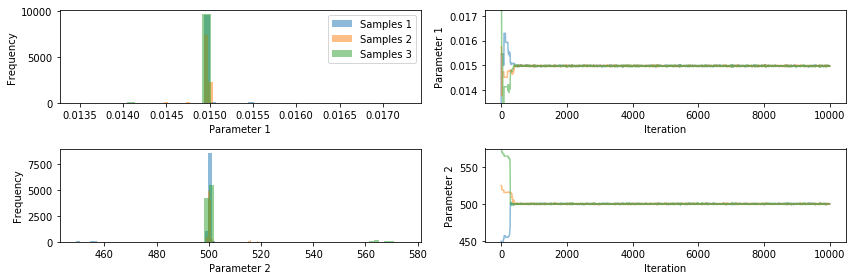

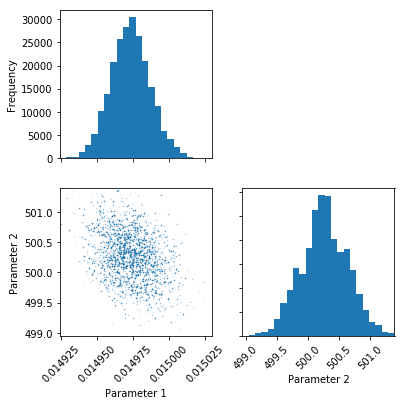

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

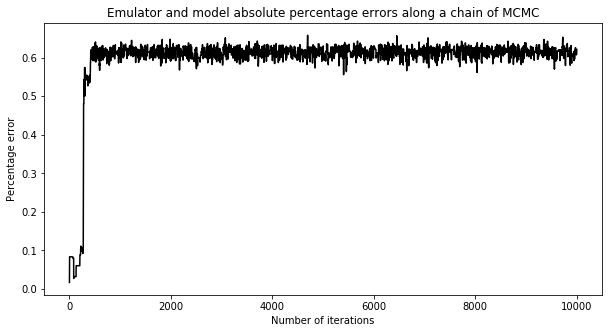

0.598294751784176

In [27]:
chain = chains[0]
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

Running...
[7.79674370e-03 4.52393494e+02]
-inf


[8.14426701e-03 5.22448189e+02]
-inf


[1.78712952e-02 5.72968903e+02]
-65929.1015625


[3.33921844e-02 4.50365829e+02]
-inf


[6.72123917e-03 5.20594379e+02]
-inf


[7.29371182e-03 5.79585153e+02]
-inf


[3.73214336e-03 4.49352883e+02]
-inf


[1.23369878e-02 5.24098953e+02]
-26312.296875


[4.92096228e-02 5.75415377e+02]
-inf


[8.93924215e-03 4.51321048e+02]
-inf


[2.26440365e-02 5.31136211e+02]
-inf


[9.13600250e-03 5.75905242e+02]
-inf


[3.95528684e-03 4.47907659e+02]
-inf


[1.43455035e-02 5.24196068e+02]
-4293.0966796875
accepted


[2.06945454e-02 5.72722403e+02]
-inf


[1.57891188e-02 4.50685040e+02]
-10844.4599609375
accepted


[3.18210186e-02 5.22104500e+02]
-inf


[-1.12069017e-02  5.73435794e+02]
-inf


[3.70628157e-03 4.50091906e+02]
-inf


[1.49277115e-02 5.24024385e+02]
-4117.6826171875
accepted


[2.5664531e-02 5.7386470e+02]
-inf


[1.32810829e-03 4.50196274e+02]
-inf


[2.04400672e-02 5.28684105e+02]
-inf


[3.380184

[-6.77592095e-03  5.26869313e+02]
-inf


[1.13970287e-02 5.68268846e+02]
-55077.80859375


[1.86827792e-02 4.61084488e+02]
-25624.263671875


[2.96978576e-02 5.22181205e+02]
-inf


[2.86672791e-02 5.69629314e+02]
-inf


[2.20111223e-02 4.63641667e+02]
-inf


[8.42138877e-03 5.27570331e+02]
-inf


[7.40832659e-03 5.72654116e+02]
-inf


[1.09030912e-02 4.61575213e+02]
-97446.09375


[1.36843526e-02 5.26391585e+02]
-7096.3466796875


[1.07696082e-02 5.71855234e+02]
-78084.1640625


[1.44838451e-02 4.65023859e+02]
-8878.1162109375


[1.04163098e-03 5.19131758e+02]
-inf


[1.14426017e-02 5.71825473e+02]
-53798.15234375


[3.08293507e-02 4.58550668e+02]
-inf


[2.87479656e-02 5.22297843e+02]
-inf


[2.62002292e-02 5.73200187e+02]
-inf


[1.59079999e-02 4.57464529e+02]
-8674.8076171875


[2.38125301e-02 5.25927700e+02]
-inf


[3.05572116e-03 5.73581389e+02]
-inf


[2.97909029e-02 4.61386481e+02]
-inf


[2.82629536e-02 5.21275295e+02]
-inf


[3.08744456e-02 5.72913642e+02]
-inf


[2.03057023e-

[1.46029160e-02 5.19267899e+02]
-3398.858154296875


[1.34737969e-02 5.64726598e+02]
-16172.3642578125


[1.53909555e-02 4.71270866e+02]
-4617.8349609375
accepted


[1.47368146e-02 5.19239302e+02]
-3333.893310546875
accepted


[1.39244561e-02 5.64798394e+02]
-14921.7236328125


[1.53066358e-02 4.71993238e+02]
-4490.9990234375
accepted


[1.46149732e-02 5.19286924e+02]
-3391.615966796875


[1.37277817e-02 5.64734760e+02]
-14859.9638671875


[1.54867508e-02 4.71680008e+02]
-4538.3505859375


[1.47704863e-02 5.19218941e+02]
-3330.494873046875
accepted


[1.37742613e-02 5.64699286e+02]
-14819.7978515625
accepted


[1.50399522e-02 4.73454654e+02]
-4529.5615234375


[1.46509888e-02 5.19183291e+02]
-3352.776123046875


[1.37028483e-02 5.64660855e+02]
-14908.7666015625


[1.53543016e-02 4.71408218e+02]
-4599.7607421875


[1.49284344e-02 5.19229382e+02]
-3368.694091796875


[1.38422670e-02 5.64774763e+02]
-14865.0205078125


[1.52389648e-02 4.74025682e+02]
-4116.1044921875
accepted


[1.4643847

-1883.1239013671875


[1.51802486e-02 4.87859141e+02]
-2393.139404296875


[1.44048574e-02 5.60486332e+02]
-14084.6650390625


[1.49208539e-02 4.95683513e+02]
-2032.2957763671875


[1.49212167e-02 5.10522503e+02]
-2400.104248046875


[1.44306463e-02 5.60386079e+02]
-14127.4443359375


[1.51313104e-02 4.98162319e+02]
-1893.3856201171875


[1.49549651e-02 5.11613744e+02]
-2516.697998046875


[1.41317528e-02 5.62164746e+02]
-14092.2880859375


[1.50949427e-02 5.04124408e+02]
-2065.740966796875


[1.50000118e-02 4.98392358e+02]
-1900.5965576171875


[1.42002849e-02 5.61703845e+02]
-14022.1513671875
accepted


[1.50234999e-02 4.99024990e+02]
-1882.1043701171875


[1.52588126e-02 4.75467470e+02]
-3864.510498046875


[1.41985837e-02 5.61676503e+02]
-14006.6513671875
accepted


[1.51250568e-02 5.01003870e+02]
-1948.1824951171875


[1.50507905e-02 4.95868465e+02]
-1850.1785888671875
accepted


[1.42765555e-02 5.61163663e+02]
-13976.9775390625
accepted


[1.49862503e-02 5.01745681e+02]
-1936.229

[1.50733378e-02 4.96764428e+02]
-1829.8621826171875


[1.50756115e-02 4.97347658e+02]
-1829.3387451171875
accepted


[1.50831631e-02 4.89791104e+02]
-2236.740966796875


[1.50466378e-02 4.97388444e+02]
-1849.0535888671875


[1.50691806e-02 4.96259992e+02]
-1836.7606201171875


[1.49199227e-02 5.11352229e+02]
-2477.612060546875


[1.50871227e-02 4.96372882e+02]
-1829.5496826171875


[1.50894686e-02 4.96630769e+02]
-1831.5809326171875


[1.51726776e-02 4.90270769e+02]
-2156.553466796875


[1.50901775e-02 4.96959725e+02]
-1835.7957763671875


[1.50693256e-02 4.98057325e+02]
-1841.8309326171875


[1.54712989e-02 4.72903147e+02]
-4275.6630859375


[1.50720624e-02 4.97095142e+02]
-1828.8973388671875
accepted


[1.50672537e-02 4.97830864e+02]
-1835.0223388671875


[1.48446291e-02 5.13124406e+02]
-2638.026123046875


[1.50931484e-02 4.97120370e+02]
-1841.1942138671875


[1.50516681e-02 4.98484092e+02]
-1851.4051513671875


[1.52022348e-02 4.85397488e+02]
-2640.350341796875


[1.50597269e-02 4.

[1.50825725e-02 4.96911329e+02]
-1828.1239013671875


[1.50597262e-02 4.97281984e+02]
-1835.7449951171875


[1.51034485e-02 4.93915120e+02]
-1898.8504638671875


[1.50744680e-02 4.96914785e+02]
-1828.7684326171875
accepted


[1.50717489e-02 4.97300525e+02]
-1828.1160888671875
accepted


[1.50596383e-02 4.99340672e+02]
-1875.5106201171875


[1.50750913e-02 4.96771339e+02]
-1829.1512451171875


[1.50738090e-02 4.97315743e+02]
-1827.3114013671875
accepted


[1.50938305e-02 4.96097210e+02]
-1834.7215576171875


[1.50717606e-02 4.96959904e+02]
-1829.5965576171875
accepted


[1.50738515e-02 4.97935571e+02]
-1839.4559326171875


[1.50728532e-02 4.96014810e+02]
-1841.0692138671875


[1.50846490e-02 4.96445209e+02]
-1829.2840576171875
accepted


[1.50707816e-02 4.97514682e+02]
-1827.9949951171875


[1.50676080e-02 4.98425911e+02]
-1851.7449951171875


[1.50789120e-02 4.96646284e+02]
-1828.8621826171875
accepted


[1.50777039e-02 4.97550988e+02]
-1834.4129638671875


[1.50236826e-02 5.01029987e+

[1.50689845e-02 4.97488606e+02]
-1828.3543701171875


[1.50779922e-02 4.97191181e+02]
-1828.8231201171875


[1.50667953e-02 4.97516410e+02]
-1830.4715576171875
accepted


[1.50734220e-02 4.96972173e+02]
-1828.9090576171875


[1.50786499e-02 4.96997334e+02]
-1826.7996826171875
accepted


[1.50611782e-02 4.97781578e+02]
-1837.6278076171875


[1.50814229e-02 4.96842057e+02]
-1826.3973388671875
accepted


[1.50770568e-02 4.97164460e+02]
-1827.6004638671875


[1.50534320e-02 4.98652042e+02]
-1854.8621826171875


[1.50884125e-02 4.96907192e+02]
-1833.3231201171875


[1.50847336e-02 4.96700361e+02]
-1827.4285888671875
accepted


[1.50511950e-02 4.98856617e+02]
-1860.0653076171875


[1.50803270e-02 4.97047399e+02]
-1828.4442138671875
accepted


[1.50823774e-02 4.96808950e+02]
-1826.2957763671875
accepted


[1.50664341e-02 4.97915284e+02]
-1837.2020263671875


[1.50883963e-02 4.97018683e+02]
-1835.1668701171875


[1.50790444e-02 4.96991816e+02]
-1826.6707763671875
accepted


[1.50666463e-02 4.9

[1.50758770e-02 4.96976023e+02]
-1827.9442138671875


[1.50706900e-02 4.97390478e+02]
-1828.1317138671875
accepted


[1.50789688e-02 4.96817220e+02]
-1827.4520263671875
accepted


[1.50632215e-02 4.97242712e+02]
-1832.1199951171875


[1.50731601e-02 4.97408704e+02]
-1828.2801513671875
accepted


[1.50680627e-02 4.97567902e+02]
-1829.5848388671875


[1.50744834e-02 4.97137390e+02]
-1827.7645263671875


[1.50757814e-02 4.97277667e+02]
-1828.3504638671875
accepted


[1.50742423e-02 4.97116824e+02]
-1827.9676513671875
accepted


[1.50697526e-02 4.96939432e+02]
-1830.4637451171875


[1.50796731e-02 4.97098665e+02]
-1828.7293701171875
accepted


[1.50713004e-02 4.97387999e+02]
-1827.9090576171875
accepted


[1.50731903e-02 4.97230980e+02]
-1827.8660888671875


[1.50783817e-02 4.97050058e+02]
-1826.8465576171875
accepted


[1.50669257e-02 4.97789547e+02]
-1833.8074951171875


[1.50808972e-02 4.96604859e+02]
-1828.6903076171875


[1.50757959e-02 4.97295496e+02]
-1828.6512451171875


[1.5068705

[1.50744410e-02 4.97078053e+02]
-1828.0535888671875
accepted


[1.50654005e-02 4.97510976e+02]
-1831.7684326171875


[1.50721779e-02 4.97347395e+02]
-1827.7449951171875
accepted


[1.50494985e-02 4.97947368e+02]
-1849.9598388671875


[1.50709501e-02 4.97336740e+02]
-1828.2567138671875


[1.50713937e-02 4.97349199e+02]
-1828.0496826171875
accepted


[1.50592746e-02 4.97231021e+02]
-1835.8387451171875


[1.50669069e-02 4.97635534e+02]
-1831.1395263671875


[1.50742273e-02 4.97031811e+02]
-1828.3465576171875
accepted


[1.50697328e-02 4.97580703e+02]
-1828.6082763671875
accepted


[1.50843615e-02 4.96606314e+02]
-1827.5965576171875
accepted


[1.50685551e-02 4.97261354e+02]
-1829.5262451171875


[1.50715775e-02 4.97609206e+02]
-1830.2098388671875
accepted


[1.50943324e-02 4.96012749e+02]
-1835.3699951171875


[1.50743775e-02 4.97142452e+02]
-1827.7918701171875
accepted


[1.50881227e-02 4.96737113e+02]
-1831.0926513671875


[1.50849273e-02 4.96334917e+02]
-1830.9442138671875


[1.5075596



[1.51006743e-02 4.96286171e+02]
-1841.4246826171875


[1.50789665e-02 4.97165542e+02]
-1829.2215576171875
accepted


[1.50702728e-02 4.97096361e+02]
-1829.5770263671875


[1.5068616e-02 4.9695313e+02]
-1830.8504638671875


[1.50742495e-02 4.97661232e+02]
-1833.2918701171875


[1.50638946e-02 4.97748894e+02]
-1834.7918701171875


[1.50868328e-02 4.95979802e+02]
-1837.6239013671875


[1.50807343e-02 4.97258758e+02]
-1832.2449951171875


[1.50694973e-02 4.97190324e+02]
-1829.4715576171875


[1.50778664e-02 4.96941095e+02]
-1827.3309326171875
accepted


[1.50867194e-02 4.96658273e+02]
-1829.0496826171875
accepted


[1.50607047e-02 4.97877854e+02]
-1838.7137451171875


[1.50845432e-02 4.96604249e+02]
-1827.5574951171875
accepted


[1.50926053e-02 4.96488053e+02]
-1833.5731201171875


[1.50738875e-02 4.97504493e+02]
-1830.4442138671875


[1.50818312e-02 4.96731494e+02]
-1827.0067138671875
accepted


[1.50892777e-02 4.96286214e+02]
-1830.7254638671875


[1.50788655e-02 4.95987668e+02]
-1839

[1.50874113e-02 4.96256478e+02]
-1831.8739013671875


[1.50950639e-02 4.96399633e+02]
-1835.5340576171875


[1.50785141e-02 4.96912755e+02]
-1827.2215576171875
accepted


[1.50791843e-02 4.97177233e+02]
-1829.5809326171875


[1.50899064e-02 4.96392050e+02]
-1830.2762451171875


[1.50724084e-02 4.96919789e+02]
-1829.5379638671875
accepted


[1.50946827e-02 4.96162852e+02]
-1835.4949951171875


[1.50820085e-02 4.96956625e+02]
-1828.3895263671875
accepted


[1.50846598e-02 4.95529383e+02]
-1847.3660888671875


[1.50768975e-02 4.97014388e+02]
-1827.3778076171875


[1.50598696e-02 4.98067189e+02]
-1840.7489013671875


[1.50731833e-02 4.96715890e+02]
-1830.1356201171875
accepted


[1.50658914e-02 4.97510823e+02]
-1831.2996826171875


[1.50775083e-02 4.97403646e+02]
-1831.8582763671875


[1.50673135e-02 4.96695203e+02]
-1832.4754638671875


[1.50930201e-02 4.96463686e+02]
-1833.7996826171875


[1.50797517e-02 4.97231808e+02]
-1830.9559326171875


[1.50675388e-02 4.97211394e+02]
-1830.13952636

[1.50642007e-02 4.96667900e+02]
-1833.8035888671875


[1.50569557e-02 4.97866835e+02]
-1842.2489013671875


[1.50838194e-02 4.96678442e+02]
-1826.9637451171875
accepted


[1.50861193e-02 4.96861490e+02]
-1830.4676513671875


[1.50700380e-02 4.97767951e+02]
-1833.9051513671875


[1.50845146e-02 4.96726343e+02]
-1827.4207763671875


[1.50619693e-02 4.97417543e+02]
-1834.4793701171875


[1.50861525e-02 4.96630475e+02]
-1828.2528076171875


[1.50851411e-02 4.96776318e+02]
-1828.4168701171875


[1.50755886e-02 4.96653246e+02]
-1829.8387451171875


[1.50675724e-02 4.97358914e+02]
-1829.4559326171875


[1.50832215e-02 4.96544157e+02]
-1828.6395263671875


[1.50810270e-02 4.96717984e+02]
-1827.3973388671875


[1.50674368e-02 4.97597320e+02]
-1830.3856201171875


[1.50781249e-02 4.96647095e+02]
-1829.1004638671875


[1.50897297e-02 4.97708449e+02]
-1847.9871826171875


[1.50588951e-02 4.98083044e+02]
-1841.7996826171875


[1.50921572e-02 4.96231144e+02]
-1832.8114013671875


[1.50697917e-02 4.9

[1.50760654e-02 4.97221874e+02]
-1827.6785888671875
accepted


[1.50594701e-02 4.97755539e+02]
-1839.0926513671875


[1.50633289e-02 4.97439431e+02]
-1833.3035888671875


[1.50520785e-02 4.99078105e+02]
-1866.4598388671875


[1.50556505e-02 4.98126328e+02]
-1845.2098388671875


[1.50533861e-02 4.97760093e+02]
-1844.9949951171875


[1.50908428e-02 4.95739775e+02]
-1841.2840576171875


[1.50744557e-02 4.97468105e+02]
-1830.3270263671875


[1.50589147e-02 4.97633618e+02]
-1838.8309326171875


[1.50778156e-02 4.97330196e+02]
-1830.9285888671875


[1.50909280e-02 4.96597938e+02]
-1832.7723388671875


[1.50676138e-02 4.97316950e+02]
-1829.6434326171875
accepted


[1.50770666e-02 4.96976051e+02]
-1827.4949951171875
accepted


[1.50620411e-02 4.97798269e+02]
-1836.9051513671875


[1.50800938e-02 4.96637141e+02]
-1828.5887451171875
accepted


[1.50679602e-02 4.97017181e+02]
-1830.8270263671875


[1.50929325e-02 4.96263838e+02]
-1833.5614013671875


[1.50718123e-02 4.97009269e+02]
-1829.36999511

[1.50887088e-02 4.96422827e+02]
-1829.1473388671875


[1.50840958e-02 4.96488382e+02]
-1828.9754638671875


[1.50826290e-02 4.96733685e+02]
-1826.7293701171875
accepted


[1.50605957e-02 4.97924163e+02]
-1839.1239013671875


[1.50875041e-02 4.96635765e+02]
-1829.6512451171875


[1.50611554e-02 4.97539231e+02]
-1836.0653076171875


[1.50834286e-02 4.96403673e+02]
-1830.1278076171875


[1.50772816e-02 4.97011767e+02]
-1827.2528076171875
accepted


[1.50631659e-02 4.97619350e+02]
-1834.6395263671875


[1.50798423e-02 4.97158412e+02]
-1829.8387451171875


[1.50696336e-02 4.97245274e+02]
-1829.1746826171875
accepted


[1.50828591e-02 4.97164408e+02]
-1832.5887451171875


[1.50906136e-02 4.96539840e+02]
-1831.9949951171875


[1.50670128e-02 4.97324684e+02]
-1829.8348388671875


[1.50834045e-02 4.96549424e+02]
-1828.5184326171875
accepted


[1.50728579e-02 4.97148206e+02]
-1828.3543701171875
accepted


[1.50576898e-02 4.97860738e+02]
-1841.5106201171875


[1.50795919e-02 4.97058433e+02]
-1828

[1.50769964e-02 4.97109720e+02]
-1826.9403076171875
accepted


[1.5073662e-02 4.9747397e+02]
-1829.7606201171875
accepted


[1.50802134e-02 4.96884064e+02]
-1826.6824951171875
accepted


[1.50737675e-02 4.97703577e+02]
-1833.5887451171875


[1.50787486e-02 4.97496510e+02]
-1834.4442138671875


[1.50733755e-02 4.97659298e+02]
-1832.5301513671875


[1.50727170e-02 4.97359762e+02]
-1827.4832763671875
accepted


[1.50746476e-02 4.97754967e+02]
-1835.1668701171875


[1.50757299e-02 4.97098563e+02]
-1827.4793701171875


[1.50757477e-02 4.96761414e+02]
-1828.9403076171875


[1.50947584e-02 4.96278607e+02]
-1835.4051513671875


[1.50801475e-02 4.97035700e+02]
-1828.1082763671875


[1.50715859e-02 4.97296361e+02]
-1828.2020263671875


[1.50834054e-02 4.96878499e+02]
-1828.2996826171875
accepted


[1.50865456e-02 4.96463863e+02]
-1828.4793701171875


[1.50605983e-02 4.97529504e+02]
-1836.5184326171875


[1.50740011e-02 4.97075721e+02]
-1828.2489013671875
accepted


[1.50701651e-02 4.96737827e+02

-1834.4090576171875


[1.50577289e-02 4.97734191e+02]
-1840.6434326171875


[1.50909636e-02 4.97185260e+02]
-1840.3035888671875


[1.50814311e-02 4.96578186e+02]
-1828.8270263671875
accepted


[1.50715385e-02 4.97208404e+02]
-1828.6004638671875
accepted


[1.50676035e-02 4.97598755e+02]
-1830.2254638671875


[1.50920475e-02 4.96022570e+02]
-1835.2723388671875


[1.50727511e-02 4.97307824e+02]
-1827.7059326171875
accepted


[1.50943287e-02 4.96169138e+02]
-1835.1317138671875


[1.50651499e-02 4.97465653e+02]
-1831.7176513671875


[1.50559746e-02 4.97668326e+02]
-1841.8934326171875


[1.50877356e-02 4.96440094e+02]
-1828.3582763671875


[1.50817800e-02 4.96247257e+02]
-1833.7020263671875


[1.50791756e-02 4.96790889e+02]
-1827.4949951171875
accepted


[1.50766736e-02 4.97117826e+02]
-1827.0223388671875
accepted


[1.50777353e-02 4.96935937e+02]
-1827.4129638671875
accepted


[1.50813100e-02 4.96635636e+02]
-1828.2254638671875
accepted


[1.50709094e-02 4.96827469e+02]
-1830.5184326171875


[1.50820657e-02 4.96496054e+02]
-1829.5340576171875


[1.50780167e-02 4.97725293e+02]
-1837.6160888671875


[1.50960387e-02 4.97026279e+02]
-1842.2410888671875


[1.50783289e-02 4.96123277e+02]
-1837.2645263671875


[1.50781682e-02 4.97182483e+02]
-1828.8153076171875
accepted


[1.50826977e-02 4.97720157e+02]
-1841.7840576171875


[1.50901092e-02 4.95869542e+02]
-1838.8817138671875


[1.50643719e-02 4.97985479e+02]
-1838.7020263671875


[1.5085962e-02 4.9688158e+02]
-1830.6590576171875
accepted


[1.50892152e-02 4.96448048e+02]
-1829.8543701171875
accepted


[1.50843551e-02 4.96589333e+02]
-1827.7762451171875
accepted


[1.50812484e-02 4.96993464e+02]
-1828.3465576171875
accepted


[1.50886824e-02 4.96852038e+02]
-1832.6356201171875


[1.50837615e-02 4.96209489e+02]
-1833.9090576171875


[1.50540198e-02 4.98403625e+02]
-1848.6043701171875


[1.51067255e-02 4.94828871e+02]
-1858.4285888671875


[1.50671664e-02 4.97423717e+02]
-1829.4989013671875
accepted


[1.50684782e-02 4.98126114e+0

[1.50758442e-02 4.97446971e+02]
-1831.1590576171875


[1.50613130e-02 4.97540854e+02]
-1835.9168701171875


[1.50925174e-02 4.96500239e+02]
-1833.5848388671875


[1.50687262e-02 4.97858100e+02]
-1836.1278076171875


[1.50636415e-02 4.98095085e+02]
-1841.5887451171875


[1.50602919e-02 4.98373682e+02]
-1848.6317138671875


[1.50772049e-02 4.97006900e+02]
-1827.3035888671875
accepted


[1.50764530e-02 4.97094554e+02]
-1827.2137451171875
accepted


[1.50677121e-02 4.97846087e+02]
-1835.5614013671875


[1.50761258e-02 4.96519148e+02]
-1831.1395263671875


[1.50877495e-02 4.96622982e+02]
-1829.7957763671875


[1.50822930e-02 4.97462922e+02]
-1837.1004638671875


[1.50793523e-02 4.96780315e+02]
-1827.4676513671875
accepted


[1.50759732e-02 4.97338745e+02]
-1829.5145263671875


[1.50785325e-02 4.96351898e+02]
-1832.2762451171875


[1.50874576e-02 4.96354272e+02]
-1829.8582763671875


[1.50699831e-02 4.96899600e+02]
-1830.5535888671875


[1.50624895e-02 4.97621819e+02]
-1835.3114013671875


[

[1.50908927e-02 4.96666420e+02]
-1833.2996826171875


[1.50883032e-02 4.96798896e+02]
-1831.7567138671875


[1.50914970e-02 4.96249863e+02]
-1832.1199951171875


[1.50677546e-02 4.97473731e+02]
-1829.2567138671875


[1.50745381e-02 4.97454570e+02]
-1830.1668701171875


[1.50937353e-02 4.96445879e+02]
-1834.3309326171875


[1.50716423e-02 4.97457939e+02]
-1827.7996826171875
accepted


[1.50921120e-02 4.96098904e+02]
-1833.7293701171875


[1.50783033e-02 4.97342425e+02]
-1831.5301513671875


[1.50614401e-02 4.97570465e+02]
-1835.9715576171875


[1.50978420e-02 4.95787253e+02]
-1839.2957763671875


[1.50928063e-02 4.96190107e+02]
-1833.5496826171875


[1.50552564e-02 4.98125937e+02]
-1845.5848388671875


[1.50935873e-02 4.96145751e+02]
-1834.4090576171875


[1.50750573e-02 4.96849266e+02]
-1828.8192138671875


[1.50753988e-02 4.96637234e+02]
-1830.0653076171875


[1.50789832e-02 4.97220902e+02]
-1830.1395263671875


[1.5083387e-02 4.9668323e+02]
-1827.0496826171875
accepted


[1.50805812e

-1826.7684326171875
accepted


[1.50561973e-02 4.98241736e+02]
-1845.4520263671875


[1.50748543e-02 4.96800997e+02]
-1829.1121826171875
accepted


[1.50680331e-02 4.97641788e+02]
-1830.1043701171875


[1.50810586e-02 4.96727557e+02]
-1827.2840576171875
accepted


[1.50601676e-02 4.97761154e+02]
-1838.4559326171875


[1.50972496e-02 4.96129177e+02]
-1838.1629638671875


[1.50688938e-02 4.97119251e+02]
-1830.0184326171875


[1.50736084e-02 4.97105164e+02]
-1828.2606201171875
accepted


[1.50787331e-02 4.97055238e+02]
-1827.2371826171875
accepted


[1.50873714e-02 4.96547433e+02]
-1828.8114013671875


[1.50676979e-02 4.97243604e+02]
-1829.9442138671875


[1.50745051e-02 4.97570482e+02]
-1832.0340576171875


[1.50889033e-02 4.96255077e+02]
-1831.4637451171875


[1.50658597e-02 4.97040994e+02]
-1831.5301513671875


[1.50769063e-02 4.97548629e+02]
-1833.7098388671875


[1.50608822e-02 4.98202441e+02]
-1843.9754638671875


[1.50597372e-02 4.98145898e+02]
-1842.1512451171875


[1.50697130e-02

[1.50745187e-02 4.97023975e+02]
-1828.2684326171875
accepted


[1.50583705e-02 4.98259724e+02]
-1845.0106201171875


[1.50678045e-02 4.97091052e+02]
-1830.5614013671875
accepted


[1.50704343e-02 4.97246435e+02]
-1828.8543701171875


[1.50711782e-02 4.97505897e+02]
-1828.1942138671875


[1.50500414e-02 4.98434417e+02]
-1852.6434326171875


[1.50648529e-02 4.97268735e+02]
-1830.9168701171875


[1.50775096e-02 4.97184843e+02]
-1828.3074951171875


[1.50619031e-02 4.96959968e+02]
-1833.4012451171875


[1.50803665e-02 4.97063473e+02]
-1828.7449951171875
accepted


[1.50933925e-02 4.96497584e+02]
-1834.4324951171875


[1.50983257e-02 4.96647166e+02]
-1840.5887451171875


[1.50770136e-02 4.96568438e+02]
-1830.3074951171875


[1.50852358e-02 4.96688330e+02]
-1827.8074951171875


[1.50622898e-02 4.97382382e+02]
-1833.9246826171875


[1.50755705e-02 4.97109176e+02]
-1827.4910888671875
accepted


[1.50865255e-02 4.96359293e+02]
-1830.0028076171875


[1.50677789e-02 4.97529941e+02]
-1829.61608886

[1.50777738e-02 4.97580565e+02]
-1834.9793701171875


[1.50864879e-02 4.96537800e+02]
-1827.8778076171875
accepted


[1.50594365e-02 4.96864643e+02]
-1834.7723388671875


[1.50811382e-02 4.97159723e+02]
-1830.9481201171875


[1.50912882e-02 4.95993335e+02]
-1836.0614013671875


[1.50651579e-02 4.97833769e+02]
-1834.6395263671875


[1.50598577e-02 4.97815220e+02]
-1839.1121826171875


[1.50931603e-02 4.96909584e+02]
-1837.6629638671875


[1.50445599e-02 4.98619934e+02]
-1859.1473388671875


[1.50945765e-02 4.96113490e+02]
-1835.4637451171875


[1.50719951e-02 4.97666033e+02]
-1831.5028076171875


[1.50626513e-02 4.97432572e+02]
-1833.9090576171875


[1.50933338e-02 4.96708604e+02]
-1836.0770263671875


[1.50840114e-02 4.96932991e+02]
-1829.7489013671875


[1.50485670e-02 4.98195245e+02]
-1852.4989013671875


[1.51008708e-02 4.96249062e+02]
-1841.6903076171875


[1.50886347e-02 4.96420672e+02]
-1829.0418701171875
accepted


[1.50781469e-02 4.96402701e+02]
-1831.7879638671875


[1.5079721

[1.50774951e-02 4.97391351e+02]
-1831.6551513671875


[1.50894691e-02 4.96904363e+02]
-1834.2332763671875


[1.50957465e-02 4.95853426e+02]
-1837.6981201171875


[1.50792445e-02 4.96975924e+02]
-1826.6551513671875
accepted


[1.50703857e-02 4.97170752e+02]
-1829.2098388671875
accepted


[1.50757409e-02 4.97042005e+02]
-1827.7020263671875
accepted


[1.50965564e-02 4.96115748e+02]
-1837.4871826171875


[1.5057691e-02 4.9735553e+02]
-1838.1942138671875


[1.50842434e-02 4.96958807e+02]
-1830.3973388671875


[1.50784701e-02 4.96959732e+02]
-1827.0301513671875
accepted


[1.50710332e-02 4.97190708e+02]
-1828.8778076171875
accepted


[1.50778157e-02 4.97069025e+02]
-1826.7957763671875
accepted


[1.50847108e-02 4.96916023e+02]
-1830.1004638671875


[1.50685489e-02 4.96915710e+02]
-1831.0379638671875


[1.50670594e-02 4.97542374e+02]
-1830.3778076171875


[1.50813588e-02 4.96770796e+02]
-1826.7410888671875
accepted


[1.50601532e-02 4.97803254e+02]
-1838.7449951171875


[1.50889707e-02 4.965



[1.50948222e-02 4.96042823e+02]
-1835.8309326171875


[1.50923561e-02 4.95734839e+02]
-1840.9324951171875


[1.50611797e-02 4.96958621e+02]
-1833.6785888671875


[1.50699585e-02 4.97205248e+02]
-1829.2215576171875


[1.50734069e-02 4.96884192e+02]
-1829.3035888671875
accepted


[1.50808639e-02 4.96833545e+02]
-1826.6590576171875
accepted


[1.50868938e-02 4.96661779e+02]
-1829.2449951171875


[1.50695231e-02 4.97220434e+02]
-1829.3114013671875
accepted


[1.50744639e-02 4.97786513e+02]
-1835.5262451171875


[1.50882378e-02 4.97043970e+02]
-1835.4481201171875


[1.50705774e-02 4.96974680e+02]
-1829.9910888671875


[1.50716168e-02 4.96986134e+02]
-1829.5457763671875


[1.50697480e-02 4.97133131e+02]
-1829.6199951171875


[1.50694771e-02 4.97248092e+02]
-1829.2137451171875
accepted


[1.50735383e-02 4.96972071e+02]
-1828.8660888671875


[1.50774495e-02 4.96648664e+02]
-1829.2918701171875
accepted


[1.5068981e-02 4.9752315e+02]
-1828.3934326171875
accepted


[1.50868722e-02 4.95997582e+

[1.50712293e-02 4.97408082e+02]
-1827.8465576171875
accepted


[1.50721179e-02 4.96917259e+02]
-1829.6590576171875


[1.50836825e-02 4.97556618e+02]
-1839.9403076171875


[1.50505595e-02 4.98908800e+02]
-1861.3895263671875


[1.50487378e-02 4.97487564e+02]
-1847.6864013671875


[1.50906893e-02 4.97201510e+02]
-1840.3348388671875


[1.50697124e-02 4.98122388e+02]
-1843.7371826171875


[1.50701816e-02 4.97697691e+02]
-1831.9637451171875


[1.50678676e-02 4.97070287e+02]
-1830.6239013671875


[1.50886004e-02 4.95973972e+02]
-1837.2176513671875


[1.50751729e-02 4.97452801e+02]
-1830.6942138671875


[1.51009194e-02 4.96481145e+02]
-1841.6317138671875


[1.50796743e-02 4.97170338e+02]
-1829.8856201171875


[1.50874159e-02 4.97154408e+02]
-1836.5653076171875


[1.50759649e-02 4.97264644e+02]
-1828.2918701171875


[1.50639610e-02 4.98384463e+02]
-1849.7567138671875


[1.50859202e-02 4.96304368e+02]
-1831.3621826171875


[1.50769971e-02 4.97275004e+02]
-1829.3348388671875


[1.50651875e-02 4.9

[1.50794904e-02 4.96967298e+02]
-1826.6004638671875
accepted


[1.50982534e-02 4.96020254e+02]
-1839.3504638671875


[1.50794862e-02 4.96622240e+02]
-1828.9481201171875
accepted


[1.50806460e-02 4.96598329e+02]
-1828.8543701171875


[1.50693856e-02 4.97392990e+02]
-1828.6199951171875


[1.50668464e-02 4.97597758e+02]
-1830.9598388671875


[1.5072286e-02 4.9727060e+02]
-1828.0418701171875
accepted


[1.50806617e-02 4.97063773e+02]
-1828.9989013671875


[1.50783393e-02 4.96755052e+02]
-1827.9793701171875
accepted


[1.50739340e-02 4.96870243e+02]
-1829.1629638671875


[1.50745227e-02 4.97722090e+02]
-1834.5145263671875


[1.50846677e-02 4.96762666e+02]
-1827.8426513671875
accepted


[1.50893493e-02 4.97391952e+02]
-1842.2996826171875


[1.50711035e-02 4.97679462e+02]
-1831.6668701171875


[1.50793794e-02 4.97350283e+02]
-1832.5731201171875


[1.50554566e-02 4.98406815e+02]
-1848.4754638671875


[1.50921371e-02 4.96383227e+02]
-1832.5692138671875


[1.50915335e-02 4.96538242e+02]
-1832.9

-1841.5145263671875


[1.51166704e-02 4.95525868e+02]
-1858.9012451171875


[1.50747514e-02 4.96959653e+02]
-1828.4598388671875


[1.50977131e-02 4.96556686e+02]
-1839.2528076171875


[1.50774160e-02 4.97051495e+02]
-1827.0379638671875
accepted


[1.50761555e-02 4.96601782e+02]
-1830.2176513671875


[1.51116011e-02 4.95620996e+02]
-1853.5887451171875


[1.50904323e-02 4.95913475e+02]
-1837.8895263671875


[1.50833507e-02 4.96800564e+02]
-1826.9871826171875
accepted


[1.50915815e-02 4.96498864e+02]
-1832.6434326171875


[1.50784018e-02 4.96434427e+02]
-1831.3699951171875


[1.51008803e-02 4.95977452e+02]
-1842.1004638671875


[1.50754870e-02 4.96583765e+02]
-1830.6199951171875


[1.50974054e-02 4.95625362e+02]
-1841.8114013671875


[1.50839250e-02 4.97426671e+02]
-1837.9715576171875


[1.51079530e-02 4.96122403e+02]
-1849.1082763671875


[1.50594824e-02 4.97409487e+02]
-1836.8192138671875


[1.50664618e-02 4.98046271e+02]
-1840.8778076171875


[1.51140190e-02 4.94699501e+02]
-1862.2098

[1.50830200e-02 4.96857233e+02]
-1827.6239013671875
accepted


[1.50857366e-02 4.96614964e+02]
-1827.7293701171875


[1.50792257e-02 4.96473154e+02]
-1830.6785888671875


[1.50802904e-02 4.97093236e+02]
-1829.1629638671875


[1.50824432e-02 4.97166499e+02]
-1832.2489013671875


[1.50764771e-02 4.97118414e+02]
-1827.1043701171875
accepted


[1.50904510e-02 4.96378695e+02]
-1830.8504638671875


[1.51092873e-02 4.95252600e+02]
-1851.7684326171875


[1.50817401e-02 4.96813563e+02]
-1826.3973388671875
accepted


[1.50951190e-02 4.96332439e+02]
-1835.6903076171875


[1.50933760e-02 4.96516813e+02]
-1834.5848388671875


[1.50699423e-02 4.97526031e+02]
-1827.8153076171875
accepted


[1.50869546e-02 4.96828626e+02]
-1830.6668701171875


[1.50762600e-02 4.96801308e+02]
-1828.5692138671875


[1.50706817e-02 4.97305442e+02]
-1828.5145263671875
accepted


[1.50760988e-02 4.97067383e+02]
-1827.4676513671875
accepted


[1.50795427e-02 4.96438316e+02]
-1830.9715576171875


[1.50655428e-02 4.97557089e+

[1.50625661e-02 4.98001499e+02]
-1838.7410888671875


[1.50622576e-02 4.97811164e+02]
-1836.7801513671875


[1.50837016e-02 4.96668914e+02]
-1827.1082763671875


[1.50781573e-02 4.97481460e+02]
-1833.6824951171875


[1.50963595e-02 4.95984772e+02]
-1837.4676513671875


[1.50806716e-02 4.97019719e+02]
-1828.2918701171875


[1.50788344e-02 4.97046561e+02]
-1827.1864013671875
accepted


[1.50772371e-02 4.97302667e+02]
-1829.9989013671875


[1.50816665e-02 4.96563945e+02]
-1828.9051513671875


[1.50756985e-02 4.96870674e+02]
-1828.4832763671875


[1.50763621e-02 4.96706235e+02]
-1828.9989013671875
accepted


[1.50728478e-02 4.97332228e+02]
-1827.5614013671875
accepted


[1.50908919e-02 4.96078654e+02]
-1834.4481201171875


[1.50840343e-02 4.96763232e+02]
-1827.2449951171875
accepted


[1.50793651e-02 4.97278271e+02]
-1831.3895263671875


[1.50956448e-02 4.96693641e+02]
-1838.2801513671875


[1.50791524e-02 4.97340326e+02]
-1832.2137451171875


[1.50707758e-02 4.97807777e+02]
-1835.18249511

[1.50930095e-02 4.96069513e+02]
-1834.0848388671875


[1.50716478e-02 4.97276128e+02]
-1828.2684326171875
accepted


[1.50706233e-02 4.97152818e+02]
-1829.2098388671875


[1.50964230e-02 4.96719935e+02]
-1839.2606201171875


[1.50671531e-02 4.97756433e+02]
-1832.9324951171875


[1.50763472e-02 4.96765275e+02]
-1828.6981201171875
accepted


[1.50753311e-02 4.97045245e+02]
-1827.8582763671875


[1.50704619e-02 4.97600141e+02]
-1829.3074951171875


[1.50645717e-02 4.96763749e+02]
-1833.2371826171875


[1.50860576e-02 4.96969426e+02]
-1832.2137451171875


[1.50701014e-02 4.97473034e+02]
-1827.9910888671875
accepted


[1.50687326e-02 4.97268588e+02]
-1829.4129638671875
accepted


[1.50920530e-02 4.95962135e+02]
-1836.4793701171875


[1.50789233e-02 4.97040754e+02]
-1827.1668701171875
accepted


[1.50812500e-02 4.97050131e+02]
-1829.2723388671875
accepted


[1.50937586e-02 4.96335787e+02]
-1834.2957763671875


[1.50727599e-02 4.97284018e+02]
-1827.8035888671875


[1.50789577e-02 4.96967267e+

[1.50889646e-02 4.96272693e+02]
-1831.0809326171875


[1.50858068e-02 4.96607053e+02]
-1827.7489013671875
accepted


[1.50793636e-02 4.97134759e+02]
-1829.0653076171875


[1.50964823e-02 4.95933818e+02]
-1837.6785888671875


[1.50774090e-02 4.97159364e+02]
-1827.7996826171875
accepted


[1.50875900e-02 4.96192339e+02]
-1833.1121826171875


[1.50788863e-02 4.97118648e+02]
-1828.3934326171875
accepted


[1.5055092e-02 4.9844506e+02]
-1849.4598388671875


[1.50875218e-02 4.96325801e+02]
-1830.4364013671875


[1.50864721e-02 4.96386721e+02]
-1829.4168701171875


[1.50769298e-02 4.96952459e+02]
-1827.6473388671875
accepted


[1.50668784e-02 4.97094598e+02]
-1830.9012451171875


[1.50855944e-02 4.96908391e+02]
-1830.7606201171875


[1.50736023e-02 4.97039380e+02]
-1828.5457763671875


[1.50881530e-02 4.96279848e+02]
-1831.1746826171875


[1.50530912e-02 4.99097956e+02]
-1867.2332763671875


[1.50729064e-02 4.96939266e+02]
-1829.2567138671875


[1.50788599e-02 4.96736196e+02]
-1827.8973388671

-1835.8348388671875


[1.50786471e-02 4.97297674e+02]
-1831.1004638671875


[1.51058745e-02 4.95358729e+02]
-1848.1356201171875


[1.50692554e-02 4.97280509e+02]
-1829.1629638671875


[1.50760848e-02 4.96396623e+02]
-1832.5067138671875


[1.50972119e-02 4.95916576e+02]
-1838.4559326171875


[1.51010769e-02 4.95774212e+02]
-1842.6043701171875


[1.50796272e-02 4.96474393e+02]
-1830.5379638671875


[1.50866805e-02 4.96221412e+02]
-1832.7996826171875


[1.50722444e-02 4.97734139e+02]
-1833.4676513671875


[1.50834581e-02 4.96848756e+02]
-1827.8699951171875


[1.50729285e-02 4.96697640e+02]
-1830.3074951171875


[1.50748005e-02 4.97102191e+02]
-1827.8035888671875


[1.50728836e-02 4.97932418e+02]
-1839.1317138671875


[1.50755273e-02 4.97287096e+02]
-1828.2879638671875
accepted


[1.50707173e-02 4.97363363e+02]
-1828.2410888671875


[1.50711910e-02 4.97044636e+02]
-1829.4676513671875


[1.50747285e-02 4.97769454e+02]
-1835.4715576171875


[1.50731299e-02 4.97359317e+02]
-1827.4442138671875

[1.50840905e-02 4.96058242e+02]
-1836.8660888671875


[1.50714173e-02 4.96976017e+02]
-1829.6629638671875


[1.50761350e-02 4.96846098e+02]
-1828.4168701171875


[1.50791877e-02 4.96407814e+02]
-1831.4129638671875


[1.50909066e-02 4.96515862e+02]
-1832.1004638671875


[1.50612712e-02 4.97313437e+02]
-1834.4715576171875


[1.50657030e-02 4.98360954e+02]
-1849.5028076171875


[1.50742960e-02 4.97046975e+02]
-1828.2449951171875


[1.50746113e-02 4.97326977e+02]
-1828.1707763671875


[1.50563029e-02 4.97433672e+02]
-1840.0301513671875


[1.50729095e-02 4.97412642e+02]
-1828.1199951171875


[1.50725053e-02 4.97028946e+02]
-1829.0106201171875


[1.50638261e-02 4.97064687e+02]
-1832.2098388671875


[1.50786258e-02 4.97080064e+02]
-1827.5379638671875
accepted


[1.50812433e-02 4.96976172e+02]
-1828.0496826171875


[1.50904078e-02 4.96597862e+02]
-1832.2684326171875


[1.50948428e-02 4.96662019e+02]
-1837.2059326171875


[1.50778437e-02 4.97158433e+02]
-1828.1590576171875


[1.50604994e-02 4.9

[1.50513318e-02 4.98426539e+02]
-1851.3543701171875


[1.50709424e-02 4.98149823e+02]
-1844.7723388671875


[1.50914385e-02 4.97135264e+02]
-1839.8973388671875


[1.50627503e-02 4.97532551e+02]
-1834.4598388671875


[1.50879638e-02 4.96155754e+02]
-1833.7528076171875


[1.50710223e-02 4.97755951e+02]
-1833.7879638671875


[1.50828006e-02 4.96767337e+02]
-1826.3114013671875
accepted


[1.51119960e-02 4.95784174e+02]
-1853.7449951171875


[1.50584788e-02 4.98002334e+02]
-1841.6746826171875


[1.50926488e-02 4.96795021e+02]
-1836.1043701171875


[1.50728531e-02 4.97052418e+02]
-1828.7879638671875
accepted


[1.50697604e-02 4.97248583e+02]
-1829.1121826171875


[1.50862533e-02 4.96111021e+02]
-1835.1590576171875


[1.50609772e-02 4.97635487e+02]
-1836.8543701171875


[1.50896554e-02 4.97355702e+02]
-1841.9910888671875


[1.50796316e-02 4.97400609e+02]
-1833.6356201171875


[1.50680726e-02 4.96947044e+02]
-1831.0809326171875
accepted


[1.50908133e-02 4.96447387e+02]
-1831.4520263671875


[



[1.50636451e-02 4.97347903e+02]
-1832.4090576171875


[1.51011876e-02 4.96240475e+02]
-1842.0262451171875


[1.50792447e-02 4.97130690e+02]
-1828.8895263671875


[1.50887824e-02 4.96413228e+02]
-1829.1278076171875


[1.50873508e-02 4.95606974e+02]
-1845.0106201171875


[1.51003551e-02 4.95999585e+02]
-1841.5301513671875


[1.50730656e-02 4.96509651e+02]
-1832.2059326171875


[1.50971030e-02 4.96163116e+02]
-1837.9793701171875


[1.50805160e-02 4.96922172e+02]
-1826.5692138671875
accepted


[1.50963288e-02 4.95596526e+02]
-1842.6707763671875


[1.50736557e-02 4.96652678e+02]
-1830.4442138671875
accepted


[1.50618324e-02 4.97997017e+02]
-1838.4559326171875


[1.50864196e-02 4.96651804e+02]
-1828.6942138671875


[1.50611024e-02 4.96910256e+02]
-1833.9246826171875


[1.50746662e-02 4.97138981e+02]
-1827.6981201171875


[1.50712441e-02 4.97259989e+02]
-1828.4949951171875


[1.50631045e-02 4.97510650e+02]
-1833.9793701171875


[1.50820576e-02 4.96690824e+02]
-1827.3778076171875


[1.50740

[1.50698491e-02 4.97226159e+02]
-1829.1824951171875
accepted


[1.50871839e-02 4.96357140e+02]
-1829.8621826171875


[1.50791972e-02 4.96275838e+02]
-1833.7528076171875


[1.50639631e-02 4.97265869e+02]
-1831.5614013671875


[1.50886449e-02 4.96484886e+02]
-1829.5770263671875


[1.50920504e-02 4.96020737e+02]
-1835.3114013671875


[1.50839699e-02 4.96450253e+02]
-1829.4520263671875
accepted


[1.50913872e-02 4.96167902e+02]
-1832.5418701171875


[1.50844703e-02 4.96814816e+02]
-1828.1785888671875


[1.50827113e-02 4.96554551e+02]
-1828.6785888671875
accepted


[1.50807393e-02 4.96426492e+02]
-1830.7176513671875


[1.50869564e-02 4.96486042e+02]
-1828.1004638671875
accepted


[1.51027667e-02 4.95589701e+02]
-1844.6121826171875


[1.50906005e-02 4.96425523e+02]
-1831.0496826171875


[1.50894098e-02 4.97276502e+02]
-1840.4246826171875


[1.50974988e-02 4.96043792e+02]
-1838.5574951171875


[1.50964811e-02 4.96477255e+02]
-1837.2996826171875


[1.50976527e-02 4.96101969e+02]
-1838.62390136



[1.50841379e-02 4.96544288e+02]
-1828.3348388671875


[1.50826388e-02 4.96581817e+02]
-1828.3973388671875


[1.50731407e-02 4.97494549e+02]
-1829.6590576171875


[1.50874117e-02 4.96683051e+02]
-1829.9481201171875


[1.50823263e-02 4.97108362e+02]
-1831.1668701171875


[1.50914440e-02 4.95763328e+02]
-1840.6395263671875


[1.50705899e-02 4.97055131e+02]
-1829.6356201171875


[1.50771651e-02 4.97063616e+02]
-1827.0731201171875
accepted


[1.50990550e-02 4.95712281e+02]
-1840.6473388671875


[1.50894588e-02 4.96801829e+02]
-1832.9442138671875


[1.50535331e-02 4.98581125e+02]
-1852.9129638671875


[1.50797039e-02 4.96922873e+02]
-1826.7020263671875
accepted


[1.50871815e-02 4.96646754e+02]
-1829.4168701171875


[1.50778486e-02 4.97663070e+02]
-1836.4246826171875


[1.50745510e-02 4.96892102e+02]
-1828.8309326171875


[1.50777313e-02 4.97136250e+02]
-1827.7098388671875


[1.50737417e-02 4.97023280e+02]
-1828.5653076171875


[1.50810586e-02 4.96283831e+02]
-1833.0848388671875


[1.50867

[1.50814399e-02 4.96922686e+02]
-1827.3582763671875
accepted


[1.50745172e-02 4.97203132e+02]
-1827.4754638671875
accepted


[1.50849071e-02 4.96746863e+02]
-1827.9481201171875


[1.50642597e-02 4.98226210e+02]
-1845.3973388671875


[1.50699713e-02 4.97576522e+02]
-1828.5418701171875


[1.50994182e-02 4.96074477e+02]
-1840.4559326171875


[1.50724166e-02 4.97531092e+02]
-1829.6356201171875


[1.50834906e-02 4.96509955e+02]
-1828.9364013671875


[1.50874597e-02 4.96425713e+02]
-1828.6160888671875


[1.50748184e-02 4.96934943e+02]
-1828.5418701171875


[1.50716607e-02 4.97598882e+02]
-1830.1121826171875


[1.50889682e-02 4.96623421e+02]
-1831.0184326171875


[1.50915841e-02 4.96327705e+02]
-1832.0887451171875


[1.50791543e-02 4.97812365e+02]
-1840.1278076171875


[1.50984700e-02 4.96085048e+02]
-1839.4832763671875


[1.50785926e-02 4.96745809e+02]
-1827.9207763671875


[1.50869698e-02 4.96391839e+02]
-1829.1668701171875


[1.50761211e-02 4.97222370e+02]
-1827.7410888671875


[1.5095678

-1844.1082763671875


[1.50874647e-02 4.96266428e+02]
-1831.6473388671875


[1.50831383e-02 4.96213172e+02]
-1834.0184326171875


[1.51030406e-02 4.96472408e+02]
-1843.5965576171875


[1.50773688e-02 4.97107513e+02]
-1826.9364013671875
accepted


[1.50935585e-02 4.96320517e+02]
-1834.1043701171875


[1.50881897e-02 4.96299101e+02]
-1830.7840576171875


[1.5074610e-02 4.9725367e+02]
-1827.2176513671875


[1.50981099e-02 4.95698785e+02]
-1840.1629638671875


[1.50850319e-02 4.96902645e+02]
-1830.1629638671875


[1.50786319e-02 4.97252392e+02]
-1830.3465576171875


[1.50894637e-02 4.96104901e+02]
-1834.3114013671875


[1.50759014e-02 4.96817056e+02]
-1828.6356201171875


[1.50822033e-02 4.96891646e+02]
-1827.4989013671875


[1.51018144e-02 4.95833362e+02]
-1843.2684326171875


[1.50759894e-02 4.96911110e+02]
-1828.2020263671875


[1.50861278e-02 4.96301266e+02]
-1831.3621826171875


[1.50894439e-02 4.96373562e+02]
-1829.8426513671875


[1.51155288e-02 4.95079158e+02]
-1858.9598388671875



[1.50712858e-02 4.97210250e+02]
-1828.6864013671875
accepted


[1.50873684e-02 4.95724046e+02]
-1842.6278076171875


[1.51024749e-02 4.96525674e+02]
-1843.5653076171875


[1.50851469e-02 4.96872399e+02]
-1829.7684326171875


[1.50526887e-02 4.97097269e+02]
-1841.3035888671875


[1.50820162e-02 4.97201753e+02]
-1832.4559326171875


[1.50667858e-02 4.97715782e+02]
-1831.7879638671875


[1.50585418e-02 4.97174741e+02]
-1836.1864013671875


[1.50746613e-02 4.97700798e+02]
-1834.2918701171875


[1.50682157e-02 4.96291043e+02]
-1836.3387451171875


[1.50688986e-02 4.97554134e+02]
-1828.6824951171875
accepted


[1.50701331e-02 4.97608746e+02]
-1829.4715576171875
accepted


[1.50714684e-02 4.97209806e+02]
-1828.6160888671875
accepted


[1.50647223e-02 4.97631693e+02]
-1833.2176513671875


[1.50793475e-02 4.97457308e+02]
-1834.3270263671875


[1.50833869e-02 4.96585203e+02]
-1828.1356201171875
accepted


[1.50618383e-02 4.98130654e+02]
-1842.1864013671875


[1.50665935e-02 4.97302108e+02]
-1830

[1.50807066e-02 4.97343303e+02]
-1833.6473388671875


[1.50699859e-02 4.97606609e+02]
-1829.3817138671875


[1.50786453e-02 4.96274710e+02]
-1833.9285888671875


[1.50897170e-02 4.95988343e+02]
-1836.5926513671875


[1.50530917e-02 4.97765693e+02]
-1845.3114013671875


[1.50753952e-02 4.97073716e+02]
-1827.7020263671875
accepted


[1.50813433e-02 4.96852304e+02]
-1826.3817138671875


[1.50708405e-02 4.97340213e+02]
-1828.2918701171875


[1.50808894e-02 4.96728648e+02]
-1827.3270263671875
accepted


[1.50792207e-02 4.96697058e+02]
-1828.2098388671875


[1.50647226e-02 4.98232451e+02]
-1845.6864013671875


[1.50787689e-02 4.96746891e+02]
-1827.8504638671875


[1.50653948e-02 4.97262140e+02]
-1830.7293701171875


[1.50704734e-02 4.97075868e+02]
-1829.5965576171875


[1.50715265e-02 4.97523734e+02]
-1828.7801513671875


[1.50713083e-02 4.97356929e+02]
-1828.0418701171875


[1.50805926e-02 4.96785368e+02]
-1826.9754638671875
accepted


[1.50643626e-02 4.97856704e+02]
-1835.0965576171875


[

[1.50876741e-02 4.96526637e+02]
-1828.9403076171875


[1.50813220e-02 4.96906819e+02]
-1826.9910888671875
accepted


[1.50891431e-02 4.96743232e+02]
-1832.1590576171875


[1.51146470e-02 4.95184685e+02]
-1857.3348388671875


[1.50727905e-02 4.98116660e+02]
-1844.2645263671875


[1.50733397e-02 4.96446610e+02]
-1832.8192138671875


[1.50728969e-02 4.96755211e+02]
-1830.0692138671875


[1.50846192e-02 4.96553293e+02]
-1828.0926513671875


[1.50723304e-02 4.96740017e+02]
-1830.3582763671875


[1.50885373e-02 4.96382678e+02]
-1828.9637451171875


[1.50867256e-02 4.96689902e+02]
-1829.3035888671875


[1.5073614e-02 4.9632737e+02]
-1834.1082763671875


[1.50972436e-02 4.95989426e+02]
-1838.3778076171875


[1.50683819e-02 4.97706406e+02]
-1831.8114013671875


[1.50761110e-02 4.96262853e+02]
-1834.8543701171875


[1.50874782e-02 4.96388237e+02]
-1829.1121826171875
accepted


[1.50847847e-02 4.96713632e+02]
-1827.5731201171875
accepted


[1.50527087e-02 4.97230136e+02]
-1842.1629638671875


[1.



[1.50694456e-02 4.96971931e+02]
-1830.4481201171875


[1.50768341e-02 4.97081175e+02]
-1827.1199951171875
accepted


[1.50467865e-02 4.98248281e+02]
-1854.5614013671875


[1.50826174e-02 4.96722957e+02]
-1826.8504638671875
accepted


[1.50595202e-02 4.97731848e+02]
-1838.8856201171875


[1.50873538e-02 4.96143681e+02]
-1834.1668701171875


[1.50926743e-02 4.96209896e+02]
-1833.3778076171875


[1.50882340e-02 4.96111826e+02]
-1834.5496826171875


[1.50638596e-02 4.97377469e+02]
-1832.3856201171875


[1.50785889e-02 4.96956875e+02]
-1826.9949951171875
accepted


[1.50693981e-02 4.97472849e+02]
-1828.2684326171875


[1.50535708e-02 4.98350059e+02]
-1848.6864013671875


[1.50762982e-02 4.96925804e+02]
-1827.9989013671875


[1.50795401e-02 4.96718752e+02]
-1827.8660888671875


[1.50532781e-02 4.98769259e+02]
-1858.1043701171875


[1.50983564e-02 4.96157529e+02]
-1839.2528076171875


[1.50710478e-02 4.97614835e+02]
-1829.8504638671875


[1.50575121e-02 4.98253847e+02]
-1844.6395263671875



[1.50974089e-02 4.95716901e+02]
-1839.9832763671875


[1.50729402e-02 4.97631453e+02]
-1831.7098388671875


[1.50629332e-02 4.97430646e+02]
-1833.6278076171875


[1.50979266e-02 4.95656392e+02]
-1841.0574951171875


[1.50712661e-02 4.97796481e+02]
-1834.9793701171875


[1.50848762e-02 4.96482982e+02]
-1828.7918701171875
accepted


[1.50815079e-02 4.96744979e+02]
-1826.9442138671875
accepted


[1.50871090e-02 4.96522027e+02]
-1828.3348388671875


[1.50916309e-02 4.96020120e+02]
-1835.4324951171875


[1.50783509e-02 4.96873264e+02]
-1827.4481201171875
accepted


[1.50759151e-02 4.95961953e+02]
-1841.2489013671875


[1.50818766e-02 4.96343743e+02]
-1831.5574951171875


[1.50663988e-02 4.97486009e+02]
-1830.6512451171875


[1.50871663e-02 4.96316981e+02]
-1830.7293701171875


[1.50741680e-02 4.97092648e+02]
-1828.0926513671875
accepted


[1.50890838e-02 4.95813731e+02]
-1840.3114013671875


[1.50911715e-02 4.95838541e+02]
-1839.1746826171875


[1.50755352e-02 4.96977726e+02]
-1828.07702636

-1828.7020263671875


[1.50609457e-02 4.97771210e+02]
-1837.7840576171875


[1.50921613e-02 4.96471190e+02]
-1833.0028076171875


[1.50708553e-02 4.96716813e+02]
-1831.0379638671875


[1.50614976e-02 4.97471954e+02]
-1835.2801513671875


[1.50797062e-02 4.96646827e+02]
-1828.6082763671875


[1.50870196e-02 4.97362928e+02]
-1839.7098388671875


[1.50847696e-02 4.96653169e+02]
-1827.1199951171875
accepted


[1.50726698e-02 4.97307130e+02]
-1827.7371826171875


[1.50895602e-02 4.95793667e+02]
-1840.5731201171875


[1.50947516e-02 4.96158313e+02]
-1835.5770263671875


[1.50823649e-02 4.96625682e+02]
-1828.0028076171875


[1.50840460e-02 4.96426471e+02]
-1829.6785888671875


[1.50972313e-02 4.95712643e+02]
-1840.1082763671875


[1.50862536e-02 4.96424963e+02]
-1828.9910888671875


[1.50934201e-02 4.96326261e+02]
-1833.9676513671875


[1.50801151e-02 4.96472093e+02]
-1830.4090576171875


[1.50927519e-02 4.96295947e+02]
-1833.3348388671875


[1.50778087e-02 4.96596841e+02]
-1829.7606201171875

[1.50823528e-02 4.96849668e+02]
-1826.9364013671875
accepted


[1.50835021e-02 4.96633431e+02]
-1827.5653076171875


[1.50806712e-02 4.96710461e+02]
-1827.5965576171875


[1.50895032e-02 4.96307189e+02]
-1830.2489013671875


[1.50733075e-02 4.97078229e+02]
-1828.4949951171875


[1.50880256e-02 4.96241941e+02]
-1831.9832763671875


[1.50855158e-02 4.96837584e+02]
-1829.5145263671875


[1.50812913e-02 4.96482513e+02]
-1829.9207763671875


[1.50893263e-02 4.96233758e+02]
-1831.7606201171875


[1.50998908e-02 4.95785254e+02]
-1841.3739013671875


[1.50932178e-02 4.96734677e+02]
-1836.1785888671875


[1.50876202e-02 4.96522104e+02]
-1828.8504638671875
accepted


[1.50844639e-02 4.96865606e+02]
-1829.0223388671875


[1.50944221e-02 4.96461782e+02]
-1835.1473388671875


[1.50815256e-02 4.97030999e+02]
-1829.1864013671875
accepted


[1.50958649e-02 4.95907014e+02]
-1837.0965576171875


[1.50709892e-02 4.97588168e+02]
-1829.3543701171875


[1.50965402e-02 4.96262696e+02]
-1837.2449951171875


[

[1.50745815e-02 4.97544752e+02]
-1831.6824951171875


[1.50818415e-02 4.96718550e+02]
-1827.1434326171875
accepted


[1.50804455e-02 4.97491960e+02]
-1835.9090576171875


[1.50963194e-02 4.96144696e+02]
-1837.1981201171875


[1.50779465e-02 4.96218490e+02]
-1835.3465576171875


[1.50699748e-02 4.97829555e+02]
-1835.6121826171875


[1.50890558e-02 4.96754655e+02]
-1832.1746826171875


[1.50742545e-02 4.97315026e+02]
-1827.6785888671875
accepted


[1.50686870e-02 4.97711839e+02]
-1832.0223388671875


[1.50967938e-02 4.96635534e+02]
-1838.9637451171875


[1.50998938e-02 4.95622425e+02]
-1841.6356201171875


[1.50714210e-02 4.97588412e+02]
-1829.7293701171875


[1.50747266e-02 4.97020929e+02]
-1828.1864013671875
accepted


[1.50636649e-02 4.97376940e+02]
-1832.5692138671875


[1.50688763e-02 4.97960051e+02]
-1839.0028076171875


[1.50758551e-02 4.97066132e+02]
-1827.5653076171875
accepted


[1.50880115e-02 4.97055023e+02]
-1835.4364013671875


[1.50835575e-02 4.96889069e+02]
-1828.59655761

[1.50590742e-02 4.97836165e+02]
-1840.0067138671875


[1.50920126e-02 4.95651871e+02]
-1842.7059326171875


[1.50800117e-02 4.97003368e+02]
-1827.4598388671875
accepted


[1.50873009e-02 4.96600923e+02]
-1829.1629638671875


[1.50571194e-02 4.98348038e+02]
-1847.2020263671875


[1.50759217e-02 4.97153621e+02]
-1827.1473388671875
accepted


[1.50875726e-02 4.96305670e+02]
-1830.8270263671875


[1.51041998e-02 4.95680437e+02]
-1845.9403076171875


[1.50800613e-02 4.97028716e+02]
-1827.9207763671875


[1.51137646e-02 4.94987912e+02]
-1858.2567138671875


[1.50840916e-02 4.97107080e+02]
-1832.7449951171875


[1.50757093e-02 4.97142043e+02]
-1827.2918701171875
accepted


[1.51054845e-02 4.95655096e+02]
-1847.2840576171875


[1.50938710e-02 4.96642861e+02]
-1836.0887451171875


[1.50678233e-02 4.98065083e+02]
-1841.7059326171875


[1.50652596e-02 4.97629178e+02]
-1832.6824951171875


[1.50830496e-02 4.97174868e+02]
-1832.9324951171875


[1.50816454e-02 4.97019449e+02]
-1829.1043701171875


[

[1.50626921e-02 4.97608662e+02]
-1835.0379638671875


[1.50633443e-02 4.97738799e+02]
-1835.2645263671875


[1.50768615e-02 4.97163023e+02]
-1827.4012451171875
accepted


[1.50864270e-02 4.96538549e+02]
-1827.8270263671875
accepted


[1.50681921e-02 4.97237088e+02]
-1829.7723388671875


[1.50750326e-02 4.96152248e+02]
-1837.5574951171875


[1.50704536e-02 4.97249349e+02]
-1828.8426513671875
accepted


[1.50698009e-02 4.97094581e+02]
-1829.7840576171875


[1.50763260e-02 4.97269622e+02]
-1828.6785888671875


[1.50683426e-02 4.97458200e+02]
-1828.7332763671875
accepted


[1.50778659e-02 4.96626538e+02]
-1829.4129638671875


[1.50744059e-02 4.97415028e+02]
-1829.4324951171875


[1.50918019e-02 4.96318847e+02]
-1832.3231201171875


[1.50720079e-02 4.97356917e+02]
-1827.7606201171875
accepted


[1.50875226e-02 4.96363837e+02]
-1829.6356201171875


[1.50580845e-02 4.97886978e+02]
-1841.2996826171875


[1.50712110e-02 4.97532993e+02]
-1828.6590576171875
accepted


[1.50882229e-02 4.96660896e+

-1833.3309326171875


[1.50872698e-02 4.96119997e+02]
-1834.6746826171875


[1.50757904e-02 4.97084274e+02]
-1827.5145263671875


[1.50588053e-02 4.98348259e+02]
-1847.5887451171875


[1.50681082e-02 4.97519644e+02]
-1829.2293701171875
accepted


[1.50836775e-02 4.96985581e+02]
-1830.3231201171875


[1.50764349e-02 4.97299270e+02]
-1829.2567138671875


[1.50576752e-02 4.98284391e+02]
-1845.5457763671875


[1.50777138e-02 4.96648983e+02]
-1829.2215576171875


[1.50636478e-02 4.98126931e+02]
-1842.4871826171875


[1.50496958e-02 4.97647527e+02]
-1847.8114013671875


[1.50798782e-02 4.96762676e+02]
-1827.3426513671875


[1.50947723e-02 4.96536202e+02]
-1836.1473388671875


[1.50894396e-02 4.96412172e+02]
-1829.7918701171875


[1.50796459e-02 4.97278842e+02]
-1831.6317138671875


[1.50763006e-02 4.96999556e+02]
-1827.6864013671875
accepted


[1.50882653e-02 4.96879638e+02]
-1832.7137451171875


[1.50763588e-02 4.97196215e+02]
-1827.5223388671875
accepted


[1.50840626e-02 4.96609790e+02]
-

[1.50666057e-02 4.97850217e+02]
-1835.4207763671875


[1.50759173e-02 4.96922775e+02]
-1828.1668701171875
accepted


[1.50891005e-02 4.96501979e+02]
-1830.1746826171875


[1.50568142e-02 4.97293618e+02]
-1838.6278076171875


[1.50660636e-02 4.97144914e+02]
-1830.9871826171875


[1.50788601e-02 4.96941830e+02]
-1826.9520263671875
accepted


[1.50567569e-02 4.97722079e+02]
-1841.5028076171875


[1.50667712e-02 4.96880518e+02]
-1831.8739013671875


[1.50685278e-02 4.97955801e+02]
-1838.8074951171875


[1.50753970e-02 4.96693844e+02]
-1829.4442138671875


[1.50753848e-02 4.97057099e+02]
-1827.7957763671875
accepted


[1.50803705e-02 4.96797591e+02]
-1827.0067138671875
accepted


[1.50838791e-02 4.96648522e+02]
-1827.2801513671875
accepted


[1.50778614e-02 4.96589062e+02]
-1829.8387451171875


[1.50790816e-02 4.96827599e+02]
-1827.3739013671875
accepted


[1.50771877e-02 4.96981957e+02]
-1827.4090576171875
accepted


[1.50695489e-02 4.97558676e+02]
-1828.0887451171875
accepted


[1.5059777

[1.50941461e-02 4.97061985e+02]
-1841.1239013671875


[1.50644541e-02 4.97503093e+02]
-1832.6317138671875


[1.50779333e-02 4.97466050e+02]
-1833.2293701171875


[1.50740030e-02 4.97949535e+02]
-1839.8778076171875


[1.50626488e-02 4.98067058e+02]
-1840.5809326171875


[1.50816314e-02 4.96727190e+02]
-1827.1082763671875
accepted


[1.51186416e-02 4.94921017e+02]
-1863.9364013671875


[1.50699495e-02 4.96615603e+02]
-1832.0106201171875


[1.50783862e-02 4.97032525e+02]
-1826.7293701171875
accepted


[1.50807325e-02 4.96917359e+02]
-1826.6668701171875
accepted


[1.50540226e-02 4.97803197e+02]
-1844.6551513671875


[1.50654618e-02 4.97465886e+02]
-1831.4207763671875


[1.51024821e-02 4.96228965e+02]
-1843.3543701171875


[1.50601043e-02 4.97754361e+02]
-1838.4832763671875


[1.50726497e-02 4.97488312e+02]
-1829.1395263671875


[1.50650892e-02 4.97981388e+02]
-1838.7410888671875


[1.50871638e-02 4.97134801e+02]
-1836.0028076171875


[1.51041068e-02 4.95864719e+02]
-1845.5614013671875


[

[1.50815848e-02 4.97199352e+02]
-1832.0379638671875


[1.50754986e-02 4.96910369e+02]
-1828.3739013671875
accepted


[1.50722534e-02 4.96918173e+02]
-1829.5926513671875


[1.51106352e-02 4.95207681e+02]
-1853.2254638671875


[1.50663694e-02 4.97497380e+02]
-1830.7567138671875


[1.50741114e-02 4.96775855e+02]
-1829.5106201171875


[1.50780631e-02 4.97809226e+02]
-1839.0848388671875


[1.50963354e-02 4.95445663e+02]
-1845.6824951171875


[1.50779791e-02 4.96555867e+02]
-1830.1590576171875


[1.50727268e-02 4.97706966e+02]
-1832.7996826171875


[1.50622218e-02 4.97905736e+02]
-1837.4285888671875


[1.50674670e-02 4.98431204e+02]
-1851.8660888671875


[1.50620349e-02 4.97589006e+02]
-1835.5379638671875


[1.50815209e-02 4.96804429e+02]
-1826.5262451171875
accepted


[1.50828000e-02 4.96373745e+02]
-1830.6746826171875


[1.50959132e-02 4.96685191e+02]
-1838.4793701171875


[1.50908278e-02 4.96481963e+02]
-1831.7449951171875


[1.50795455e-02 4.96609214e+02]
-1829.0731201171875


[1.5092314

-1832.5418701171875


[1.50836304e-02 4.96837236e+02]
-1827.8192138671875


[1.50774065e-02 4.96687536e+02]
-1828.8817138671875
accepted


[1.50660856e-02 4.97356841e+02]
-1830.1043701171875


[1.50939090e-02 4.96440867e+02]
-1834.4481201171875


[1.50842379e-02 4.96640366e+02]
-1827.2489013671875
accepted


[1.50730532e-02 4.97962316e+02]
-1840.0184326171875


[1.50912864e-02 4.96635845e+02]
-1833.4324951171875


[1.50621605e-02 4.97664552e+02]
-1835.9051513671875


[1.5087075e-02 4.9665002e+02]
-1829.3387451171875


[1.50764745e-02 4.97225006e+02]
-1828.0770263671875


[1.50735695e-02 4.96986279e+02]
-1828.8074951171875


[1.50698065e-02 4.97804266e+02]
-1834.8621826171875


[1.50823819e-02 4.96802186e+02]
-1826.2137451171875
accepted


[1.50788694e-02 4.96693260e+02]
-1828.3504638671875
accepted


[1.50709170e-02 4.97782708e+02]
-1834.5223388671875


[1.50782049e-02 4.97234701e+02]
-1829.6903076171875


[1.50658309e-02 4.96938894e+02]
-1831.9871826171875


[1.50777290e-02 4.97275891

[1.50809379e-02 4.97009247e+02]
-1828.3309326171875


[1.50942481e-02 4.96124534e+02]
-1835.1121826171875


[1.50872646e-02 4.96748426e+02]
-1830.3192138671875


[1.50675450e-02 4.97418076e+02]
-1829.2254638671875


[1.50791381e-02 4.96506605e+02]
-1830.3426513671875


[1.50904604e-02 4.96608423e+02]
-1832.3934326171875


[1.50802818e-02 4.96690559e+02]
-1827.9442138671875
accepted


[1.50841251e-02 4.95580330e+02]
-1846.4989013671875


[1.50842427e-02 4.96591434e+02]
-1827.7957763671875


[1.50842789e-02 4.96838485e+02]
-1828.4012451171875
accepted


[1.50794664e-02 4.97236618e+02]
-1830.7879638671875


[1.50859520e-02 4.96072115e+02]
-1836.0301513671875


[1.50828140e-02 4.97221214e+02]
-1833.4989013671875


[1.50729995e-02 4.96793237e+02]
-1829.8543701171875


[1.50641477e-02 4.97539273e+02]
-1833.1590576171875


[1.50894145e-02 4.96174856e+02]
-1832.9207763671875


[1.50704056e-02 4.97131532e+02]
-1829.3817138671875


[1.50901515e-02 4.96735777e+02]
-1833.1043701171875


[1.5098848

[1.50697203e-02 4.97965282e+02]
-1839.3543701171875


[1.50774905e-02 4.96717386e+02]
-1828.5184326171875
accepted


[1.50795404e-02 4.96650617e+02]
-1828.6199951171875


[1.50712030e-02 4.96990245e+02]
-1829.6785888671875


[1.50694249e-02 4.96901356e+02]
-1830.7645263671875
accepted


[1.50696353e-02 4.97119032e+02]
-1829.7215576171875


[1.50895707e-02 4.96324524e+02]
-1830.0340576171875
accepted


[1.50667470e-02 4.97211442e+02]
-1830.4246826171875
accepted


[1.50782679e-02 4.96937693e+02]
-1827.1981201171875
accepted


[1.50985948e-02 4.95831767e+02]
-1840.0028076171875


[1.50761441e-02 4.97051070e+02]
-1827.5223388671875
accepted


[1.50936558e-02 4.96062186e+02]
-1834.6004638671875


[1.50858687e-02 4.96266688e+02]
-1832.1317138671875


[1.50864148e-02 4.96461914e+02]
-1828.5418701171875


[1.50676223e-02 4.97078856e+02]
-1830.6824951171875


[1.50703393e-02 4.97229302e+02]
-1828.9715576171875
accepted


[1.50644725e-02 4.97661720e+02]
-1833.6590576171875


[1.50684227e-02 4.9

-1832.4754638671875
accepted


[1.50761466e-02 4.97289791e+02]
-1828.8621826171875


[1.50898105e-02 4.96004387e+02]
-1836.2567138671875


[1.50640535e-02 4.96693516e+02]
-1833.7371826171875


[1.50873350e-02 4.97185995e+02]
-1837.0184326171875


[1.50890096e-02 4.96114954e+02]
-1834.2567138671875


[1.50579378e-02 4.97291984e+02]
-1837.5340576171875


[1.50754899e-02 4.97029653e+02]
-1827.8621826171875


[1.50781014e-02 4.97615862e+02]
-1835.8660888671875


[1.50827549e-02 4.95798844e+02]
-1842.4949951171875


[1.50751887e-02 4.97351373e+02]
-1829.0535888671875
accepted


[1.50729147e-02 4.97238741e+02]
-1827.9520263671875
accepted


[1.50803016e-02 4.96306513e+02]
-1832.7957763671875
accepted


[1.50663781e-02 4.97644290e+02]
-1831.7176513671875


[1.50656431e-02 4.97311824e+02]
-1830.4168701171875


[1.51114877e-02 4.94218969e+02]
-1882.2332763671875


[1.50637203e-02 4.97637267e+02]
-1834.2332763671875


[1.50813355e-02 4.97220135e+02]
-1832.1473388671875


[1.50712208e-02 4.972715

[1.50741514e-02 4.96604976e+02]
-1830.8153076171875


[1.50764035e-02 4.97316578e+02]
-1829.5106201171875


[1.50785913e-02 4.96976125e+02]
-1826.9012451171875
accepted


[1.50849924e-02 4.97042957e+02]
-1832.4832763671875


[1.50740054e-02 4.97650048e+02]
-1832.9129638671875


[1.50627698e-02 4.97105148e+02]
-1832.4364013671875


[1.50818173e-02 4.96207784e+02]
-1834.5145263671875


[1.50986734e-02 4.96146575e+02]
-1839.6043701171875


[1.50999788e-02 4.96198381e+02]
-1840.8504638671875


[1.50962223e-02 4.95828566e+02]
-1838.0614013671875


[1.50963228e-02 4.96248484e+02]
-1837.0418701171875


[1.50703438e-02 4.96830950e+02]
-1830.7254638671875


[1.50885482e-02 4.96721920e+02]
-1831.3895263671875


[1.50947754e-02 4.96211889e+02]
-1835.5184326171875


[1.50723664e-02 4.96966582e+02]
-1829.3465576171875


[1.50751254e-02 4.96768386e+02]
-1829.1551513671875


[1.5082888e-02 4.9690359e+02]
-1828.2606201171875


[1.50832856e-02 4.96599272e+02]
-1828.0184326171875
accepted


[1.50817428e

[1.50754854e-02 4.97057165e+02]
-1827.7449951171875
accepted


[1.50682053e-02 4.97336461e+02]
-1829.3192138671875


[1.50839864e-02 4.95863175e+02]
-1840.8387451171875


[1.50738160e-02 4.96820541e+02]
-1829.4246826171875


[1.50595078e-02 4.97572854e+02]
-1837.8543701171875


[1.50668084e-02 4.97122228e+02]
-1830.8074951171875


[1.50699251e-02 4.97278164e+02]
-1828.9090576171875


[1.50612127e-02 4.98124883e+02]
-1841.8817138671875


[1.50924766e-02 4.96664987e+02]
-1834.8699951171875


[1.50998145e-02 4.95437723e+02]
-1844.9364013671875


[1.50690133e-02 4.97443806e+02]
-1828.5457763671875


[1.50842856e-02 4.96638783e+02]
-1827.2567138671875
accepted


[1.50620046e-02 4.97780349e+02]
-1836.8270263671875


[1.50754264e-02 4.97178675e+02]
-1827.2449951171875
accepted


[1.50724270e-02 4.97678119e+02]
-1832.0418701171875


[1.50723639e-02 4.97375980e+02]
-1827.5535888671875
accepted


[1.50594816e-02 4.97809832e+02]
-1839.4403076171875


[1.50763512e-02 4.97393618e+02]
-1830.71765136

[1.50489005e-02 4.97469084e+02]
-1847.4129638671875


[1.50674233e-02 4.97015212e+02]
-1831.0340576171875


[1.50651330e-02 4.97358652e+02]
-1831.0301513671875


[1.50603982e-02 4.98155292e+02]
-1842.5535888671875


[1.50751369e-02 4.97621452e+02]
-1833.4012451171875


[1.50722936e-02 4.97699699e+02]
-1832.5067138671875


[1.50640302e-02 4.97479610e+02]
-1832.8934326171875


[1.50790146e-02 4.97248607e+02]
-1830.6082763671875


[1.50670315e-02 4.97693158e+02]
-1831.4012451171875


[1.5078236e-02 4.9635373e+02]
-1832.3114013671875


[1.50671294e-02 4.97965198e+02]
-1838.7684326171875


[1.50747104e-02 4.96791607e+02]
-1829.2020263671875
accepted


[1.50692323e-02 4.97532274e+02]
-1828.2176513671875
accepted


[1.50837743e-02 4.96150361e+02]
-1835.0926513671875


[1.50677074e-02 4.97307484e+02]
-1829.6551513671875


[1.50730419e-02 4.97670689e+02]
-1832.4324951171875


[1.50747707e-02 4.97889311e+02]
-1838.3778076171875


[1.50797991e-02 4.96108696e+02]
-1837.1199951171875


[1.50767690e

[1.50867727e-02 4.95855950e+02]
-1840.1473388671875


[1.50742971e-02 4.97500494e+02]
-1830.7293701171875


[1.50779203e-02 4.96897547e+02]
-1827.5106201171875
accepted


[1.50816368e-02 4.96664111e+02]
-1827.8074951171875
accepted


[1.50692312e-02 4.97183524e+02]
-1829.5965576171875


[1.50732676e-02 4.97302681e+02]
-1827.5379638671875
accepted


[1.50826461e-02 4.96577373e+02]
-1828.4481201171875
accepted


[1.50783993e-02 4.96949058e+02]
-1827.0926513671875
accepted


[1.50693372e-02 4.97323924e+02]
-1828.9364013671875
accepted


[1.50716568e-02 4.97361371e+02]
-1827.8856201171875
accepted


[1.50776202e-02 4.96974846e+02]
-1827.2762451171875


[1.50648539e-02 4.96647042e+02]
-1833.6395263671875


[1.50612050e-02 4.97363666e+02]
-1834.8504638671875


[1.50760995e-02 4.96697579e+02]
-1829.1746826171875


[1.50665149e-02 4.97310952e+02]
-1830.0848388671875


[1.50593737e-02 4.97916751e+02]
-1840.2489013671875


[1.50787222e-02 4.97320457e+02]
-1831.5145263671875


[1.50725575e-02 4.9

-1830.0770263671875


[1.50740220e-02 4.97243757e+02]
-1827.4949951171875
accepted


[1.50942224e-02 4.96888668e+02]
-1838.4207763671875


[1.50794032e-02 4.97010988e+02]
-1827.0848388671875
accepted


[1.50900370e-02 4.96362981e+02]
-1830.4637451171875


[1.50975697e-02 4.96408827e+02]
-1838.0731201171875


[1.50878134e-02 4.96175404e+02]
-1833.3778076171875


[1.50693845e-02 4.97380756e+02]
-1828.6746826171875


[1.51045184e-02 4.95782412e+02]
-1846.1004638671875


[1.50934632e-02 4.96208459e+02]
-1834.1981201171875


[1.50820579e-02 4.97030454e+02]
-1829.6278076171875


[1.50809011e-02 4.97512956e+02]
-1836.6864013671875


[1.50884735e-02 4.96307325e+02]
-1830.5262451171875


[1.50835990e-02 4.96875862e+02]
-1828.4129638671875


[1.50763593e-02 4.96850263e+02]
-1828.3192138671875


[1.50806087e-02 4.96604187e+02]
-1828.7957763671875


[1.50827059e-02 4.96678030e+02]
-1827.3153076171875
accepted


[1.50817366e-02 4.96488240e+02]
-1829.7137451171875


[1.50840259e-02 4.96335700e+02]
-

[1.50742063e-02 4.97658509e+02]
-1833.2176513671875


[1.50871638e-02 4.96093456e+02]
-1835.2371826171875


[1.50523598e-02 4.97734182e+02]
-1845.8074951171875


[1.50800822e-02 4.96995209e+02]
-1827.3934326171875
accepted


[1.50748393e-02 4.97414130e+02]
-1829.7723388671875


[1.50916549e-02 4.96074157e+02]
-1834.3387451171875


[1.50651281e-02 4.97566799e+02]
-1832.4012451171875


[1.50650687e-02 4.97456531e+02]
-1831.7371826171875


[1.50727479e-02 4.97253984e+02]
-1827.9403076171875
accepted


[1.50785694e-02 4.96933902e+02]
-1827.0887451171875
accepted


[1.50775767e-02 4.97406509e+02]
-1831.9676513671875


[1.50733697e-02 4.96680341e+02]
-1830.2215576171875


[1.50792783e-02 4.97020251e+02]
-1827.1160888671875
accepted


[1.50777934e-02 4.97198332e+02]
-1828.7645263671875
accepted


[1.50810746e-02 4.96987119e+02]
-1828.0848388671875


[1.50776295e-02 4.96797637e+02]
-1828.0574951171875


[1.50839248e-02 4.96907854e+02]
-1829.2449951171875
accepted


[1.50652460e-02 4.97241053e+

[1.50711251e-02 4.97065937e+02]
-1829.3739013671875
accepted


[1.50953462e-02 4.96107906e+02]
-1836.2528076171875


[1.50770721e-02 4.96794375e+02]
-1828.2879638671875
accepted


[1.50580674e-02 4.98175594e+02]
-1843.2059326171875


[1.51001982e-02 4.95954847e+02]
-1841.4403076171875


[1.50843868e-02 4.96270037e+02]
-1832.5067138671875


[1.50634678e-02 4.97801365e+02]
-1835.5496826171875


[1.50850594e-02 4.96332530e+02]
-1830.9715576171875
accepted


[1.50842488e-02 4.96821345e+02]
-1828.0848388671875
accepted


[1.50768331e-02 4.96580067e+02]
-1830.2371826171875


[1.50750116e-02 4.96847291e+02]
-1828.8504638671875
accepted


[1.50812343e-02 4.97722068e+02]
-1840.5067138671875


[1.50755142e-02 4.97253927e+02]
-1827.7410888671875
accepted


[1.50794965e-02 4.96443554e+02]
-1830.9207763671875


[1.50838653e-02 4.96567095e+02]
-1828.1746826171875
accepted


[1.50842813e-02 4.96787157e+02]
-1827.6512451171875
accepted


[1.50926435e-02 4.96119634e+02]
-1833.4832763671875


[1.5089883

[1.50791236e-02 4.97322078e+02]
-1831.8895263671875


[1.50652197e-02 4.98094870e+02]
-1841.9598388671875


[1.50578835e-02 4.98080324e+02]
-1842.7645263671875


[1.50754360e-02 4.97472019e+02]
-1831.2254638671875


[1.50800981e-02 4.96983555e+02]
-1827.2176513671875


[1.50678580e-02 4.97444025e+02]
-1828.9871826171875
accepted


[1.50622066e-02 4.97596966e+02]
-1835.4129638671875


[1.50826044e-02 4.96714457e+02]
-1826.9520263671875
accepted


[1.50805416e-02 4.96554633e+02]
-1829.3582763671875


[1.50721212e-02 4.96592306e+02]
-1831.5809326171875


[1.50896046e-02 4.96337077e+02]
-1830.0574951171875


[1.5066038e-02 4.9813409e+02]
-1843.2293701171875


[1.50695552e-02 4.97444356e+02]
-1828.3270263671875


[1.50789247e-02 4.97084458e+02]
-1827.8699951171875


[1.50751790e-02 4.96977601e+02]
-1828.2176513671875
accepted


[1.50785474e-02 4.96804547e+02]
-1827.6746826171875
accepted


[1.50791516e-02 4.96735414e+02]
-1827.8153076171875


[1.5055235e-02 4.9804525e+02]
-1845.080932617187

[1.50863301e-02 4.96788614e+02]
-1829.7137451171875


[1.50840863e-02 4.97045540e+02]
-1831.7176513671875


[1.50633762e-02 4.97434476e+02]
-1833.2254638671875


[1.50833272e-02 4.96602399e+02]
-1827.9676513671875


[1.50891925e-02 4.96420612e+02]
-1829.6121826171875


[1.50658457e-02 4.97273238e+02]
-1830.5106201171875


[1.50771987e-02 4.97029938e+02]
-1827.2059326171875
accepted


[1.50850430e-02 4.96272503e+02]
-1832.2645263671875


[1.50862054e-02 4.96186028e+02]
-1833.6551513671875


[1.50685164e-02 4.96975849e+02]
-1830.7840576171875


[1.50915464e-02 4.96298956e+02]
-1832.1043701171875


[1.50860816e-02 4.97283250e+02]
-1837.5184326171875


[1.50893344e-02 4.96381145e+02]
-1829.6981201171875


[1.50926503e-02 4.96175056e+02]
-1833.4051513671875


[1.50930381e-02 4.96155741e+02]
-1833.8348388671875


[1.50716481e-02 4.97396958e+02]
-1827.7332763671875
accepted


[1.50866403e-02 4.96757409e+02]
-1829.7762451171875


[1.50722218e-02 4.97169613e+02]
-1828.4989013671875
accepted


[

[1.50685214e-02 4.97286034e+02]
-1829.4285888671875


[1.50992839e-02 4.95566221e+02]
-1842.5028076171875


[1.50779460e-02 4.97076227e+02]
-1826.9051513671875
accepted


[1.50849011e-02 4.96964876e+02]
-1831.0887451171875


[1.50842884e-02 4.96679710e+02]
-1826.8660888671875
accepted


[1.50754428e-02 4.97491545e+02]
-1831.5418701171875


[1.50913299e-02 4.96416034e+02]
-1831.7176513671875


[1.50869469e-02 4.96081261e+02]
-1835.5418701171875


[1.50702064e-02 4.97191910e+02]
-1829.1942138671875


[1.51063105e-02 4.95824355e+02]
-1847.8778076171875


[1.50960662e-02 4.95626511e+02]
-1842.1434326171875


[1.50955898e-02 4.96382370e+02]
-1836.1043701171875


[1.50774895e-02 4.97105845e+02]
-1827.0145263671875
accepted


[1.50824292e-02 4.96483021e+02]
-1829.5614013671875


[1.50921853e-02 4.96039447e+02]
-1834.9012451171875


[1.50558489e-02 4.97847138e+02]
-1843.1785888671875


[1.50842013e-02 4.96638771e+02]
-1827.2840576171875
accepted


[1.50613072e-02 4.97529910e+02]
-1835.83093261

-1864.4832763671875


[1.50871211e-02 4.96022352e+02]
-1836.6942138671875


[1.50778088e-02 4.96677715e+02]
-1828.8660888671875
accepted


[1.50753542e-02 4.98025180e+02]
-1842.3934326171875


[1.50877052e-02 4.96633617e+02]
-1829.8426513671875
accepted


[1.50958234e-02 4.96567758e+02]
-1837.4364013671875


[1.50838452e-02 4.97018324e+02]
-1831.0262451171875


[1.51005451e-02 4.96048275e+02]
-1841.6551513671875


[1.50779664e-02 4.96632715e+02]
-1829.3153076171875
accepted


[1.50660308e-02 4.96964362e+02]
-1831.7879638671875


[1.51016807e-02 4.95946941e+02]
-1842.9598388671875


[1.50767856e-02 4.96722419e+02]
-1828.7059326171875
accepted


[1.50574749e-02 4.97802113e+02]
-1841.3231201171875


[1.50731195e-02 4.97510213e+02]
-1829.8934326171875
accepted


[1.50755451e-02 4.97433326e+02]
-1830.6903076171875


[1.50570377e-02 4.98005967e+02]
-1843.0965576171875


[1.50697674e-02 4.97950090e+02]
-1838.9442138671875


[1.50648307e-02 4.96719230e+02]
-1833.3192138671875


[1.50724553e-02



[1.50958523e-02 4.96115234e+02]
-1836.7606201171875


[1.50770333e-02 4.96997830e+02]
-1827.4012451171875
accepted


[1.50688275e-02 4.97036511e+02]
-1830.4090576171875


[1.50823560e-02 4.96263914e+02]
-1833.1824951171875


[1.50702874e-02 4.97437949e+02]
-1828.0731201171875


[1.50621332e-02 4.97340077e+02]
-1833.8035888671875


[1.51076553e-02 4.95441645e+02]
-1849.8231201171875


[1.50666441e-02 4.97384413e+02]
-1829.7489013671875


[1.50765270e-02 4.96297133e+02]
-1833.9910888671875


[1.50806341e-02 4.96420104e+02]
-1830.8270263671875


[1.50638377e-02 4.97591818e+02]
-1833.8192138671875


[1.50957081e-02 4.97128471e+02]
-1843.6512451171875


[1.50968796e-02 4.96010407e+02]
-1837.9754638671875


[1.50715398e-02 4.97063765e+02]
-1829.2254638671875
accepted


[1.50743442e-02 4.97490559e+02]
-1830.6004638671875


[1.50652924e-02 4.97081006e+02]
-1831.5653076171875


[1.50622865e-02 4.97271536e+02]
-1833.2137451171875


[1.50857261e-02 4.96683437e+02]
-1828.2489013671875
accepted



-1829.9598388671875


[1.50942534e-02 4.95893897e+02]
-1837.2645263671875


[1.50831621e-02 4.96869486e+02]
-1827.9364013671875
accepted


[1.50698697e-02 4.97229090e+02]
-1829.1512451171875


[1.50735628e-02 4.96950176e+02]
-1828.9520263671875
accepted


[1.50889883e-02 4.97565725e+02]
-1844.9012451171875


[1.50675563e-02 4.97808402e+02]
-1834.4793701171875


[1.50749189e-02 4.96872181e+02]
-1828.7879638671875
accepted


[1.50849381e-02 4.96757111e+02]
-1828.0692138671875
accepted


[1.50720624e-02 4.97844757e+02]
-1836.5067138671875


[1.50660895e-02 4.97059391e+02]
-1831.3465576171875


[1.50731476e-02 4.97344743e+02]
-1827.3817138671875
accepted


[1.50655016e-02 4.97548329e+02]
-1831.9246826171875


[1.50827768e-02 4.96240057e+02]
-1833.5848388671875


[1.50728623e-02 4.98000429e+02]
-1841.0418701171875


[1.50442427e-02 4.98498040e+02]
-1858.6590576171875


[1.50661320e-02 4.97106426e+02]
-1831.1317138671875


[1.50760063e-02 4.97557429e+02]
-1833.1043701171875


[1.50594747e-02

[1.50763098e-02 4.96622087e+02]
-1829.9481201171875


[1.50726658e-02 4.97755447e+02]
-1834.1356201171875


[1.50645638e-02 4.97606331e+02]
-1833.2059326171875


[1.50781871e-02 4.96962573e+02]
-1827.1199951171875
accepted


[1.50713266e-02 4.97638101e+02]
-1830.5653076171875


[1.50717855e-02 4.97471436e+02]
-1828.1395263671875


[1.50759477e-02 4.97608978e+02]
-1833.8934326171875


[1.50512989e-02 4.97481078e+02]
-1845.1746826171875


[1.50744890e-02 4.97252578e+02]
-1827.2723388671875
accepted


[1.50592919e-02 4.98097959e+02]
-1841.5106201171875


[1.50699444e-02 4.97601794e+02]
-1829.2332763671875
accepted


[1.50755071e-02 4.97089367e+02]
-1827.6004638671875
accepted


[1.50607237e-02 4.97836915e+02]
-1838.4364013671875


[1.50580312e-02 4.97835310e+02]
-1841.0028076171875


[1.50605273e-02 4.97843311e+02]
-1838.6551513671875


[1.50690859e-02 4.97848273e+02]
-1835.9246826171875


[1.50629841e-02 4.97268711e+02]
-1832.5145263671875


[1.50757723e-02 4.97062610e+02]
-1827.60046386

[1.50854055e-02 4.96367340e+02]
-1830.1199951171875


[1.50857426e-02 4.96795837e+02]
-1829.1864013671875


[1.50831353e-02 4.96962859e+02]
-1829.4520263671875


[1.50655289e-02 4.97850882e+02]
-1835.2059326171875


[1.50800951e-02 4.97321929e+02]
-1832.7215576171875


[1.50656736e-02 4.98041300e+02]
-1840.5653076171875


[1.50707445e-02 4.97298869e+02]
-1828.5145263671875


[1.50744005e-02 4.97435460e+02]
-1829.7528076171875


[1.50702756e-02 4.97220231e+02]
-1829.0418701171875


[1.50852435e-02 4.96459628e+02]
-1828.9364013671875


[1.50813756e-02 4.97040600e+02]
-1829.2254638671875


[1.50727623e-02 4.97146779e+02]
-1828.3934326171875


[1.51015511e-02 4.96267503e+02]
-1842.3582763671875


[1.50708647e-02 4.96896419e+02]
-1830.2371826171875


[1.50851157e-02 4.96536955e+02]
-1828.1121826171875


[1.50807968e-02 4.96891217e+02]
-1826.4207763671875
accepted


[1.51058682e-02 4.96153141e+02]
-1846.9364013671875


[1.50603770e-02 4.97513566e+02]
-1836.6239013671875


[1.50889868e-02 4.9

[1.50843945e-02 4.96336055e+02]
-1831.0731201171875


[1.50762365e-02 4.97280870e+02]
-1828.7918701171875
accepted


[1.50600314e-02 4.97837050e+02]
-1839.0926513671875


[1.50911094e-02 4.96591817e+02]
-1832.9090576171875


[1.50552863e-02 4.97936070e+02]
-1844.2996826171875


[1.50796749e-02 4.96768479e+02]
-1827.3856201171875
accepted


[1.50868082e-02 4.97077821e+02]
-1834.7215576171875


[1.50838718e-02 4.96825111e+02]
-1827.8309326171875
accepted


[1.50689506e-02 4.97261249e+02]
-1829.3621826171875


[1.50787027e-02 4.97137430e+02]
-1828.5418701171875


[1.50916275e-02 4.96278932e+02]
-1832.2059326171875


[1.50874970e-02 4.95909104e+02]
-1838.8504638671875


[1.50749541e-02 4.97473239e+02]
-1830.8387451171875


[1.50768186e-02 4.96805865e+02]
-1828.3270263671875


[1.50923142e-02 4.96065435e+02]
-1834.3387451171875


[1.50814832e-02 4.96436556e+02]
-1830.3778076171875


[1.50851599e-02 4.96578567e+02]
-1827.6512451171875
accepted


[1.50717921e-02 4.96766863e+02]
-1830.44421386

-1832.6160888671875


[1.50841337e-02 4.95973448e+02]
-1838.5574951171875


[1.50737705e-02 4.96860666e+02]
-1829.2645263671875


[1.50879639e-02 4.96624524e+02]
-1830.0262451171875


[1.50820526e-02 4.96424758e+02]
-1830.3153076171875


[1.50744842e-02 4.97002432e+02]
-1828.3621826171875
accepted


[1.50826181e-02 4.96819081e+02]
-1826.6668701171875
accepted


[1.50914607e-02 4.96144159e+02]
-1833.0028076171875


[1.50634043e-02 4.97697524e+02]
-1834.9285888671875


[1.50727159e-02 4.97286591e+02]
-1827.7996826171875


[1.50867693e-02 4.96292658e+02]
-1831.3348388671875


[1.50874289e-02 4.95927519e+02]
-1838.5028076171875


[1.50699416e-02 4.97261335e+02]
-1828.9871826171875


[1.50782697e-02 4.96425845e+02]
-1831.5145263671875


[1.50763251e-02 4.96837188e+02]
-1828.3817138671875
accepted


[1.50942863e-02 4.96326190e+02]
-1834.8582763671875


[1.50811239e-02 4.95957033e+02]
-1839.7879638671875


[1.50662836e-02 4.97406455e+02]
-1830.2371826171875


[1.50832495e-02 4.96866898e+02]
-

[1.50806826e-02 4.96371007e+02]
-1831.3543701171875


[1.50751565e-02 4.97084341e+02]
-1827.7489013671875
accepted


[1.50777893e-02 4.96903005e+02]
-1827.5340576171875
accepted


[1.50852266e-02 4.96205801e+02]
-1833.5535888671875


[1.50749989e-02 4.96723253e+02]
-1829.4090576171875
accepted


[1.50728132e-02 4.97438986e+02]
-1828.4793701171875
accepted


[1.50687893e-02 4.96846616e+02]
-1831.2449951171875


[1.50730807e-02 4.96794604e+02]
-1829.8270263671875
accepted


[1.50737058e-02 4.97277353e+02]
-1827.4637451171875
accepted


[1.50613954e-02 4.97572633e+02]
-1836.0379638671875


[1.50719234e-02 4.96585144e+02]
-1831.7332763671875


[1.50742199e-02 4.97064790e+02]
-1828.1981201171875
accepted


[1.50778247e-02 4.96921648e+02]
-1827.4403076171875
accepted


[1.50739971e-02 4.97146930e+02]
-1827.9364013671875
accepted


[1.50798617e-02 4.96950315e+02]
-1826.5262451171875
accepted


[1.50795994e-02 4.96610683e+02]
-1829.0457763671875


[1.50759831e-02 4.97066303e+02]
-1827.50671386

[1.50610878e-02 4.98260493e+02]
-1845.6512451171875


[1.50740721e-02 4.96997192e+02]
-1828.5496826171875
accepted


[1.51012815e-02 4.96350367e+02]
-1841.9598388671875


[1.50727375e-02 4.96777094e+02]
-1830.0301513671875


[1.50811896e-02 4.96394522e+02]
-1830.9246826171875


[1.50661527e-02 4.97302581e+02]
-1830.2567138671875


[1.50698562e-02 4.97193003e+02]
-1829.3153076171875


[1.50890662e-02 4.96091592e+02]
-1834.7020263671875


[1.50874587e-02 4.96241242e+02]
-1832.1746826171875


[1.50662375e-02 4.97624920e+02]
-1831.7059326171875


[1.50668415e-02 4.97544204e+02]
-1830.6082763671875
accepted


[1.51071568e-02 4.95539654e+02]
-1849.1785888671875


[1.50768975e-02 4.96970149e+02]
-1827.5848388671875
accepted


[1.50798961e-02 4.97320812e+02]
-1832.5262451171875


[1.50852861e-02 4.96569227e+02]
-1827.7137451171875
accepted


[1.50752033e-02 4.96937351e+02]
-1828.3856201171875


[1.50697282e-02 4.97275778e+02]
-1828.9949951171875
accepted


[1.50877403e-02 4.96189099e+02]
-1833

[1.50742955e-02 4.97505565e+02]
-1830.8153076171875


[1.50830322e-02 4.96676736e+02]
-1827.2371826171875
accepted


[1.50803891e-02 4.96697408e+02]
-1827.8309326171875
accepted


[1.50849317e-02 4.96009467e+02]
-1837.5965576171875


[1.50866659e-02 4.96535576e+02]
-1828.0223388671875
accepted


[1.50981327e-02 4.95848932e+02]
-1839.4910888671875


[1.50868098e-02 4.96485069e+02]
-1828.1590576171875
accepted


[1.51116848e-02 4.95618148e+02]
-1853.6785888671875


[1.50881725e-02 4.96372838e+02]
-1829.2723388671875


[1.50895369e-02 4.95636489e+02]
-1843.7645263671875


[1.50917778e-02 4.95999037e+02]
-1835.8192138671875


[1.50932203e-02 4.95459019e+02]
-1846.2489013671875


[1.50696416e-02 4.96865728e+02]
-1830.8426513671875


[1.50907052e-02 4.96282636e+02]
-1831.2528076171875
accepted


[1.50651796e-02 4.97498918e+02]
-1831.9090576171875


[1.50709418e-02 4.97591948e+02]
-1829.3934326171875


[1.50920325e-02 4.96063463e+02]
-1834.4559326171875


[1.50764208e-02 4.96534480e+02]
-1830

[1.50913553e-02 4.96465146e+02]
-1832.1395263671875


[1.50758265e-02 4.97066785e+02]
-1827.5731201171875


[1.50835227e-02 4.96359977e+02]
-1830.7801513671875


[1.50844428e-02 4.96287668e+02]
-1832.1121826171875


[1.50886471e-02 4.96174608e+02]
-1833.1590576171875


[1.50685757e-02 4.97786176e+02]
-1834.0809326171875


[1.50789186e-02 4.97039560e+02]
-1827.1317138671875
accepted


[1.50789865e-02 4.96356235e+02]
-1832.0535888671875


[1.50758614e-02 4.97136904e+02]
-1827.2567138671875
accepted


[1.50798024e-02 4.96997745e+02]
-1827.1981201171875
accepted


[1.50964672e-02 4.95920584e+02]
-1837.6785888671875


[1.50609814e-02 4.97977213e+02]
-1839.0887451171875


[1.50842394e-02 4.96763955e+02]
-1827.4481201171875


[1.50892983e-02 4.97431250e+02]
-1842.9364013671875


[1.50819697e-02 4.96942714e+02]
-1828.1395263671875


[1.50725355e-02 4.97589546e+02]
-1830.6942138671875


[1.50952748e-02 4.96226986e+02]
-1836.0106201171875


[1.50772122e-02 4.97394752e+02]
-1831.4559326171875


[

[1.50699423e-02 4.97142280e+02]
-1829.5145263671875


[1.50992272e-02 4.95936841e+02]
-1840.4715576171875


[1.50917133e-02 4.96028239e+02]
-1835.2489013671875


[1.50779522e-02 4.96781800e+02]
-1827.9989013671875
accepted


[1.50820270e-02 4.96227253e+02]
-1834.0653076171875


[1.50740887e-02 4.97226298e+02]
-1827.5457763671875
accepted


[1.50766290e-02 4.96911159e+02]
-1827.9324951171875
accepted


[1.50636205e-02 4.97497612e+02]
-1833.4012451171875


[1.50717374e-02 4.97117061e+02]
-1828.9207763671875


[1.50846219e-02 4.96349491e+02]
-1830.7215576171875


[1.50818004e-02 4.96749103e+02]
-1826.8153076171875
accepted


[1.50773534e-02 4.97396837e+02]
-1831.6278076171875


[1.50869942e-02 4.95896911e+02]
-1839.2449951171875


[1.50857019e-02 4.96177445e+02]
-1833.9871826171875


[1.50444499e-02 4.98787513e+02]
-1860.3543701171875


[1.50502105e-02 4.98777791e+02]
-1857.6395263671875


[1.50919671e-02 4.96482752e+02]
-1832.9051513671875


[1.50636345e-02 4.97305933e+02]
-1832.11999511

[1.50847858e-02 4.96339699e+02]
-1830.8856201171875


[1.50583246e-02 4.97467678e+02]
-1838.3035888671875


[1.50850749e-02 4.96619349e+02]
-1827.2254638671875
accepted


[1.50602837e-02 4.97705659e+02]
-1837.9832763671875


[1.50614172e-02 4.98240419e+02]
-1845.1590576171875


[1.5097189e-02 4.9602015e+02]
-1838.2723388671875


[1.50640865e-02 4.97369533e+02]
-1832.1082763671875


[1.50670322e-02 4.97751855e+02]
-1832.7723388671875


[1.50770157e-02 4.96973965e+02]
-1827.5223388671875


[1.50934557e-02 4.96364667e+02]
-1833.9481201171875


[1.50774374e-02 4.97270754e+02]
-1829.6356201171875


[1.50742308e-02 4.97087685e+02]
-1828.0926513671875
accepted


[1.50725004e-02 4.97622952e+02]
-1831.1942138671875


[1.50721867e-02 4.98058219e+02]
-1842.5028076171875


[1.50741323e-02 4.96735630e+02]
-1829.6785888671875


[1.50840780e-02 4.96832288e+02]
-1828.1239013671875


[1.50844799e-02 4.96095498e+02]
-1835.9910888671875


[1.50723373e-02 4.96986829e+02]
-1829.2684326171875
accepted


[1.

[1.50907830e-02 4.96536628e+02]
-1832.1473388671875
accepted


[1.50810965e-02 4.95999716e+02]
-1838.9364013671875


[1.50732604e-02 4.96658742e+02]
-1830.5067138671875
accepted


[1.50752968e-02 4.96968308e+02]
-1828.2176513671875
accepted


[1.51009965e-02 4.95437079e+02]
-1844.6395263671875


[1.50536161e-02 4.97531634e+02]
-1843.2684326171875


[1.50712429e-02 4.97592191e+02]
-1829.6434326171875


[1.50897772e-02 4.95361238e+02]
-1849.2449951171875


[1.50790190e-02 4.96577831e+02]
-1829.5848388671875
accepted


[1.50775554e-02 4.96824436e+02]
-1827.9598388671875
accepted


[1.50924086e-02 4.95757481e+02]
-1840.4598388671875


[1.50801336e-02 4.96269652e+02]
-1833.6395263671875


[1.50839559e-02 4.96908149e+02]
-1829.2801513671875
accepted


[1.50751987e-02 4.96583285e+02]
-1830.7254638671875


[1.50788653e-02 4.96400350e+02]
-1831.6082763671875


[1.50798538e-02 4.97794018e+02]
-1840.4598388671875


[1.50691468e-02 4.97245387e+02]
-1829.3543701171875
accepted


[1.51053330e-02 4.9

[1.50627418e-02 4.97784116e+02]
-1836.1278076171875


[1.50834601e-02 4.97358132e+02]
-1836.4012451171875


[1.50827146e-02 4.95988019e+02]
-1838.6981201171875


[1.50846970e-02 4.96873787e+02]
-1829.3739013671875
accepted


[1.50746424e-02 4.97158539e+02]
-1827.6317138671875
accepted


[1.50604502e-02 4.97768484e+02]
-1838.2371826171875


[1.50853295e-02 4.97006421e+02]
-1832.1746826171875


[1.50671813e-02 4.97465190e+02]
-1829.7528076171875


[1.50681369e-02 4.97060585e+02]
-1830.5535888671875


[1.50913321e-02 4.97290710e+02]
-1842.4207763671875


[1.50803911e-02 4.96344634e+02]
-1831.9403076171875


[1.50798603e-02 4.97327414e+02]
-1832.6043701171875


[1.50651961e-02 4.98091873e+02]
-1841.8660888671875


[1.50695996e-02 4.97480997e+02]
-1828.1590576171875


[1.50737201e-02 4.97539502e+02]
-1830.8739013671875


[1.50793474e-02 4.96979545e+02]
-1826.6043701171875
accepted


[1.50642554e-02 4.97511182e+02]
-1832.8778076171875


[1.50863033e-02 4.96742974e+02]
-1829.3153076171875


[

[1.50853976e-02 4.96177858e+02]
-1834.0692138671875


[1.50895758e-02 4.96252004e+02]
-1831.3426513671875
accepted


[1.50580691e-02 4.98127014e+02]
-1842.8856201171875


[1.50878836e-02 4.96262208e+02]
-1831.6121826171875


[1.50866789e-02 4.96287757e+02]
-1831.4598388671875
accepted


[1.50594770e-02 4.97649626e+02]
-1838.3973388671875


[1.50730766e-02 4.96731181e+02]
-1830.1004638671875


[1.50799093e-02 4.96792015e+02]
-1827.2020263671875
accepted


[1.50791029e-02 4.96751547e+02]
-1827.6942138671875
accepted


[1.50813513e-02 4.96664509e+02]
-1827.8934326171875
accepted


[1.50853747e-02 4.95493225e+02]
-1847.8856201171875


[1.50845006e-02 4.96688095e+02]
-1827.1121826171875
accepted


[1.50896014e-02 4.96620821e+02]
-1831.6356201171875


[1.50867536e-02 4.96401275e+02]
-1829.1043701171875


[1.50827663e-02 4.96490636e+02]
-1829.3621826171875


[1.50664223e-02 4.96675928e+02]
-1832.9090576171875


[1.50818700e-02 4.96088459e+02]
-1836.9129638671875


[1.5083749e-02 4.9649615e+02

[1.50673394e-02 4.97122855e+02]
-1830.6004638671875


[1.50823654e-02 4.96779468e+02]
-1826.3192138671875
accepted


[1.50623099e-02 4.97800299e+02]
-1836.6551513671875


[1.50700169e-02 4.96882938e+02]
-1830.6199951171875
accepted


[1.50710458e-02 4.97668218e+02]
-1831.3426513671875


[1.50913386e-02 4.95837933e+02]
-1839.1551513671875


[1.50815267e-02 4.96590683e+02]
-1828.6551513671875
accepted


[1.50693594e-02 4.97567749e+02]
-1828.3231201171875


[1.50918312e-02 4.96041362e+02]
-1834.9442138671875


[1.50893420e-02 4.96445362e+02]
-1829.9559326171875


[1.50752675e-02 4.96896512e+02]
-1828.5379638671875


[1.50748203e-02 4.96809132e+02]
-1829.0887451171875


[1.50691202e-02 4.97185303e+02]
-1829.6278076171875


[1.50966183e-02 4.96287105e+02]
-1837.2879638671875


[1.50882844e-02 4.95921227e+02]
-1838.3778076171875


[1.50572154e-02 4.97574087e+02]
-1840.0731201171875


[1.50977248e-02 4.96269841e+02]
-1838.4481201171875


[1.50962941e-02 4.95446609e+02]
-1845.6746826171875


[

[1.50723075e-02 4.97202735e+02]
-1828.3270263671875
accepted


[1.50776558e-02 4.97264253e+02]
-1829.7215576171875


[1.50586916e-02 4.98114484e+02]
-1842.2020263671875


[1.50664543e-02 4.97390335e+02]
-1829.9520263671875


[1.50843327e-02 4.96550818e+02]
-1828.2137451171875
accepted


[1.50785051e-02 4.97415978e+02]
-1832.8973388671875


[1.50616491e-02 4.98392053e+02]
-1849.4598388671875


[1.50779872e-02 4.96729933e+02]
-1828.2254638671875
accepted


[1.50519560e-02 4.98354802e+02]
-1850.2723388671875


[1.50701307e-02 4.97386720e+02]
-1828.3582763671875


[1.50640208e-02 4.97514034e+02]
-1833.1199951171875


[1.50882183e-02 4.96324041e+02]
-1830.2723388671875
accepted


[1.50673298e-02 4.97433215e+02]
-1829.4090576171875


[1.50759965e-02 4.97161437e+02]
-1827.1004638671875
accepted


[1.50959603e-02 4.96597639e+02]
-1837.8114013671875


[1.50657219e-02 4.97764626e+02]
-1833.1278076171875


[1.50768287e-02 4.97220382e+02]
-1828.3074951171875
accepted


[1.50889983e-02 4.95955478e+

[1.51084113e-02 4.94828224e+02]
-1857.9403076171875


[1.5070743e-02 4.9718184e+02]
-1829.0145263671875


[1.50605752e-02 4.96724902e+02]
-1834.9403076171875


[1.50835592e-02 4.96428631e+02]
-1829.7996826171875


[1.50903061e-02 4.96251981e+02]
-1831.1356201171875


[1.50741546e-02 4.97147591e+02]
-1827.8582763671875


[1.50837476e-02 4.97012923e+02]
-1830.8504638671875


[1.50909632e-02 4.96415506e+02]
-1831.3465576171875


[1.50784448e-02 4.96745817e+02]
-1827.9754638671875
accepted


[1.50849288e-02 4.95964908e+02]
-1838.4989013671875


[1.50855984e-02 4.95879688e+02]
-1840.0145263671875


[1.50821639e-02 4.96424884e+02]
-1830.2840576171875


[1.50820437e-02 4.96454848e+02]
-1829.9793701171875


[1.50724795e-02 4.97380290e+02]
-1827.4871826171875
accepted


[1.50577180e-02 4.97679619e+02]
-1840.2762451171875


[1.50987518e-02 4.95549410e+02]
-1842.9793701171875


[1.50722541e-02 4.97428478e+02]
-1827.8426513671875
accepted


[1.50884192e-02 4.96579780e+02]
-1830.1121826171875


[1.

[1.50837691e-02 4.96577724e+02]
-1828.0926513671875
accepted


[1.50907991e-02 4.96670380e+02]
-1833.2332763671875


[1.50669144e-02 4.96939713e+02]
-1831.5692138671875


[1.50684764e-02 4.97270395e+02]
-1829.5067138671875
accepted


[1.50915312e-02 4.96826227e+02]
-1835.2293701171875


[1.50737669e-02 4.97232325e+02]
-1827.6473388671875
accepted


[1.50641388e-02 4.97630070e+02]
-1833.7762451171875


[1.50891648e-02 4.97098450e+02]
-1837.2059326171875


[1.50664370e-02 4.97457717e+02]
-1830.4324951171875
accepted


[1.50723883e-02 4.97045061e+02]
-1828.9871826171875
accepted


[1.50887255e-02 4.97365568e+02]
-1841.3035888671875


[1.50746031e-02 4.97717091e+02]
-1834.5145263671875


[1.50723959e-02 4.96955252e+02]
-1829.3856201171875
accepted


[1.50908058e-02 4.96840790e+02]
-1834.6043701171875


[1.50689564e-02 4.97627442e+02]
-1829.7410888671875
accepted


[1.50618197e-02 4.97671476e+02]
-1836.2762451171875


[1.50629541e-02 4.97645235e+02]
-1835.0067138671875


[1.50774664e-02 4.9

-1838.3660888671875


[1.50963938e-02 4.97035587e+02]
-1842.7215576171875


[1.50800619e-02 4.96924915e+02]
-1826.5574951171875
accepted


[1.50774033e-02 4.96865214e+02]
-1827.8465576171875
accepted


[1.50882012e-02 4.96371612e+02]
-1829.2840576171875


[1.50742183e-02 4.97115166e+02]
-1827.9754638671875


[1.50767645e-02 4.97576820e+02]
-1834.0418701171875


[1.50725547e-02 4.97992095e+02]
-1840.7371826171875


[1.50693787e-02 4.97616200e+02]
-1829.5145263671875


[1.50553899e-02 4.97084370e+02]
-1838.6160888671875


[1.50915392e-02 4.96126549e+02]
-1833.3153076171875


[1.50749876e-02 4.97416000e+02]
-1829.9364013671875


[1.50761544e-02 4.97483424e+02]
-1832.0145263671875


[1.50986096e-02 4.95260329e+02]
-1848.9051513671875


[1.50822060e-02 4.97278538e+02]
-1833.9168701171875


[1.50915878e-02 4.94879628e+02]
-1862.3035888671875


[1.50866440e-02 4.96395793e+02]
-1829.1942138671875
accepted


[1.51032851e-02 4.95728652e+02]
-1844.9324951171875


[1.50562200e-02 4.98496233e+02]
-


[1.50587809e-02 4.98042232e+02]
-1841.6473388671875


[1.50710163e-02 4.97108030e+02]
-1829.2410888671875


[1.50773133e-02 4.97520060e+02]
-1833.5809326171875


[1.50635201e-02 4.97744555e+02]
-1835.1160888671875


[1.50965251e-02 4.96010580e+02]
-1837.6082763671875


[1.50798649e-02 4.97515157e+02]
-1835.7723388671875


[1.5088017e-02 4.9718778e+02]
-1837.6707763671875


[1.51085337e-02 4.95334044e+02]
-1850.8895263671875


[1.50767661e-02 4.97389652e+02]
-1831.0028076171875


[1.50502872e-02 4.98744891e+02]
-1856.7567138671875


[1.50755949e-02 4.96866612e+02]
-1828.5379638671875


[1.50777265e-02 4.97247087e+02]
-1829.4910888671875
accepted


[1.50741757e-02 4.97548024e+02]
-1831.3973388671875


[1.50813525e-02 4.97280057e+02]
-1833.1668701171875


[1.50880346e-02 4.96463262e+02]
-1828.7918701171875
accepted


[1.50838795e-02 4.97478918e+02]
-1838.8074951171875


[1.50808236e-02 4.96876999e+02]
-1826.4715576171875
accepted


[1.50699860e-02 4.97352294e+02]
-1828.5653076171875
acce

[1.50686224e-02 4.98151495e+02]
-1844.3035888671875


[1.50723001e-02 4.96740415e+02]
-1830.3699951171875


[1.50783433e-02 4.96672759e+02]
-1828.7528076171875
accepted


[1.50630528e-02 4.97693153e+02]
-1835.2293701171875


[1.50980286e-02 4.96637890e+02]
-1840.2137451171875


[1.50812139e-02 4.96466599e+02]
-1830.1121826171875


[1.50620845e-02 4.97678956e+02]
-1836.0692138671875


[1.50833284e-02 4.97134407e+02]
-1832.5106201171875


[1.50807050e-02 4.96455762e+02]
-1830.4012451171875


[1.50770353e-02 4.97184962e+02]
-1827.9129638671875
accepted


[1.50632160e-02 4.98005904e+02]
-1839.0223388671875


[1.50693805e-02 4.96847262e+02]
-1831.0184326171875


[1.50801559e-02 4.97169964e+02]
-1830.2957763671875


[1.50803913e-02 4.96277793e+02]
-1833.4012451171875


[1.50776411e-02 4.96161116e+02]
-1836.6942138671875


[1.50810519e-02 4.97341474e+02]
-1833.9285888671875


[1.50642320e-02 4.97086774e+02]
-1831.9481201171875


[1.50808717e-02 4.96614012e+02]
-1828.6043701171875
accepted


[

[1.50776079e-02 4.97508970e+02]
-1833.6512451171875


[1.50860099e-02 4.96588857e+02]
-1827.8153076171875


[1.50784031e-02 4.96592412e+02]
-1829.6160888671875


[1.50721979e-02 4.97065950e+02]
-1828.9754638671875
accepted


[1.5074356e-02 4.9691377e+02]
-1828.8074951171875


[1.50763779e-02 4.96610145e+02]
-1830.0614013671875


[1.50894207e-02 4.95897300e+02]
-1838.5184326171875


[1.50982540e-02 4.94850996e+02]
-1860.5067138671875


[1.50824494e-02 4.96945442e+02]
-1828.5809326171875


[1.50819501e-02 4.96238055e+02]
-1833.8426513671875


[1.50735309e-02 4.97004022e+02]
-1828.7293701171875


[1.50685251e-02 4.97089814e+02]
-1830.2801513671875


[1.50765954e-02 4.95891600e+02]
-1842.4520263671875


[1.50562751e-02 4.97726137e+02]
-1841.9754638671875


[1.50938982e-02 4.96441053e+02]
-1834.4364013671875


[1.50671638e-02 4.96983144e+02]
-1831.2684326171875


[1.5068127e-02 4.9769989e+02]
-1831.5731201171875


[1.50722876e-02 4.97492634e+02]
-1828.9012451171875


[1.50643068e-02 4.97920

[1.50848264e-02 4.96915401e+02]
-1830.1903076171875


[1.50706551e-02 4.97255474e+02]
-1828.7293701171875
accepted


[1.50954583e-02 4.96157255e+02]
-1836.3035888671875


[1.50649230e-02 4.97332969e+02]
-1831.0614013671875


[1.50759590e-02 4.96914377e+02]
-1828.1942138671875
accepted


[1.50914249e-02 4.96197264e+02]
-1832.1239013671875


[1.50824803e-02 4.96719759e+02]
-1826.9364013671875
accepted


[1.50480621e-02 4.98327010e+02]
-1853.8504638671875


[1.51049236e-02 4.95473863e+02]
-1846.9871826171875


[1.51044701e-02 4.95497064e+02]
-1846.4949951171875


[1.50775268e-02 4.97295776e+02]
-1830.1317138671875


[1.50790463e-02 4.97130623e+02]
-1828.7137451171875
accepted


[1.50826526e-02 4.96399601e+02]
-1830.4168701171875


[1.50840901e-02 4.96589527e+02]
-1827.8582763671875
accepted


[1.50726165e-02 4.97785056e+02]
-1834.9715576171875


[1.50850228e-02 4.96761839e+02]
-1828.1864013671875


[1.50652166e-02 4.97628688e+02]
-1832.7215576171875


[1.50860747e-02 4.96366544e+02]
-1829



[1.50671775e-02 4.97301611e+02]
-1829.8699951171875
accepted


[1.50890677e-02 4.95629763e+02]
-1844.0379638671875


[1.50955205e-02 4.96416719e+02]
-1835.9637451171875


[1.50949310e-02 4.96011975e+02]
-1835.9871826171875


[1.50660876e-02 4.97729339e+02]
-1832.5457763671875


[1.50941764e-02 4.96444521e+02]
-1834.7489013671875


[1.50784746e-02 4.97303910e+02]
-1831.0496826171875
accepted


[1.50820024e-02 4.96615436e+02]
-1828.2293701171875


[1.50659476e-02 4.97949918e+02]
-1838.0770263671875


[1.50818950e-02 4.96554651e+02]
-1828.9324951171875
accepted


[1.51096008e-02 4.95691016e+02]
-1851.4324951171875


[1.51019554e-02 4.96297148e+02]
-1842.7176513671875


[1.50841733e-02 4.96313542e+02]
-1831.6239013671875


[1.50812209e-02 4.96487155e+02]
-1829.8934326171875


[1.51042503e-02 4.96768291e+02]
-1847.4989013671875


[1.50753127e-02 4.96701340e+02]
-1829.3856201171875
accepted


[1.50662888e-02 4.97495337e+02]
-1830.8153076171875


[1.50849998e-02 4.96814043e+02]
-1828.639526

[1.50822285e-02 4.96525369e+02]
-1829.1512451171875
accepted


[1.50913991e-02 4.96676804e+02]
-1833.8856201171875


[1.50894860e-02 4.96481487e+02]
-1830.4051513671875


[1.50851535e-02 4.96560081e+02]
-1827.8582763671875
accepted


[1.50723388e-02 4.97786410e+02]
-1834.9403076171875


[1.50620172e-02 4.97458301e+02]
-1834.6942138671875


[1.50775693e-02 4.96626315e+02]
-1829.5067138671875


[1.50751469e-02 4.97364001e+02]
-1829.2215576171875


[1.50735426e-02 4.96586971e+02]
-1831.2137451171875


[1.51040861e-02 4.96117472e+02]
-1845.1668701171875


[1.50732092e-02 4.97033016e+02]
-1828.7254638671875
accepted


[1.50768426e-02 4.97243872e+02]
-1828.7020263671875
accepted


[1.50938898e-02 4.95957025e+02]
-1836.0926513671875


[1.50709501e-02 4.96788161e+02]
-1830.6785888671875


[1.50711895e-02 4.97620740e+02]
-1830.0614013671875


[1.50876127e-02 4.96472774e+02]
-1828.4520263671875


[1.50768224e-02 4.96444991e+02]
-1831.7449951171875
accepted


[1.50822114e-02 4.96920528e+02]
-1827

[1.50841195e-02 4.96512158e+02]
-1828.7137451171875
accepted


[1.50923161e-02 4.96543599e+02]
-1833.7293701171875


[1.50860357e-02 4.96556531e+02]
-1827.6160888671875
accepted


[1.50881408e-02 4.95890627e+02]
-1839.0418701171875


[1.50804499e-02 4.96682339e+02]
-1827.9832763671875
accepted


[1.50905544e-02 4.96478049e+02]
-1831.4403076171875


[1.50820698e-02 4.96617105e+02]
-1828.1824951171875
accepted


[1.50880911e-02 4.96219523e+02]
-1832.4129638671875


[1.50777794e-02 4.96679574e+02]
-1828.8582763671875


[1.50580487e-02 4.97498978e+02]
-1838.7840576171875


[1.50855957e-02 4.96418871e+02]
-1829.2840576171875
accepted


[1.50866667e-02 4.96303371e+02]
-1831.1473388671875


[1.50693902e-02 4.97623162e+02]
-1829.7098388671875
accepted


[1.51071399e-02 4.95090962e+02]
-1850.8582763671875


[1.50780308e-02 4.96676148e+02]
-1828.8153076171875


[1.50701550e-02 4.97936228e+02]
-1838.6317138671875


[1.50912770e-02 4.97072695e+02]
-1838.7059326171875


[1.50783983e-02 4.96312936e+

[1.50622311e-02 4.97930858e+02]
-1837.5809326171875


[1.50827881e-02 4.96827780e+02]
-1826.9481201171875
accepted


[1.50832667e-02 4.96960264e+02]
-1829.5262451171875


[1.50814705e-02 4.96506891e+02]
-1829.6004638671875
accepted


[1.50759559e-02 4.97263046e+02]
-1828.2567138671875
accepted


[1.50872368e-02 4.96624922e+02]
-1829.2996826171875


[1.50789644e-02 4.95825850e+02]
-1843.0809326171875


[1.50599696e-02 4.97923869e+02]
-1839.7137451171875


[1.50914243e-02 4.96592380e+02]
-1833.2410888671875


[1.50975012e-02 4.95732073e+02]
-1839.6629638671875


[1.50648083e-02 4.97093536e+02]
-1831.6981201171875


[1.50707402e-02 4.96935420e+02]
-1830.1043701171875


[1.50817044e-02 4.96617335e+02]
-1828.3074951171875
accepted


[1.5084779e-02 4.9695006e+02]
-1830.7410888671875
accepted


[1.50842167e-02 4.96953417e+02]
-1830.2762451171875


[1.50934174e-02 4.96394599e+02]
-1833.8660888671875


[1.50759167e-02 4.97506058e+02]
-1832.1785888671875


[1.50888333e-02 4.96872286e+02]
-1833.1

[1.50798541e-02 4.97445378e+02]
-1834.5965576171875


[1.50941073e-02 4.95938024e+02]
-1836.4246826171875


[1.50571014e-02 4.97731299e+02]
-1841.2371826171875


[1.50859565e-02 4.96695781e+02]
-1828.5887451171875
accepted


[1.50919533e-02 4.96316040e+02]
-1832.4832763671875


[1.50605382e-02 4.98301433e+02]
-1846.6629638671875


[1.50855829e-02 4.96956545e+02]
-1831.5653076171875


[1.50845731e-02 4.96721158e+02]
-1827.4364013671875
accepted


[1.50598803e-02 4.98421047e+02]
-1849.8582763671875


[1.50861391e-02 4.96681605e+02]
-1828.6590576171875
accepted


[1.50561289e-02 4.98139628e+02]
-1844.8387451171875


[1.50729991e-02 4.97212822e+02]
-1828.0223388671875


[1.50834013e-02 4.97094209e+02]
-1831.8973388671875


[1.50858981e-02 4.96000665e+02]
-1837.4832763671875


[1.50764977e-02 4.96851124e+02]
-1828.2645263671875


[1.51123279e-02 4.95029328e+02]
-1856.3231201171875


[1.50810221e-02 4.97191509e+02]
-1831.3817138671875


[1.50616241e-02 4.98240546e+02]
-1845.2137451171875


[

accepted


[1.50624625e-02 4.97665546e+02]
-1835.6199951171875


[1.50670468e-02 4.97397706e+02]
-1829.4989013671875


[1.50637214e-02 4.97430108e+02]
-1832.8660888671875


[1.50773179e-02 4.96895981e+02]
-1827.7489013671875
accepted


[1.50772478e-02 4.96688651e+02]
-1828.9168701171875
accepted


[1.50569780e-02 4.97691479e+02]
-1841.0809326171875


[1.50837210e-02 4.96397777e+02]
-1830.0965576171875


[1.50834788e-02 4.96168309e+02]
-1834.8309326171875


[1.50547780e-02 4.98030635e+02]
-1845.4285888671875


[1.50924372e-02 4.96142673e+02]
-1833.2371826171875


[1.51131952e-02 4.94929920e+02]
-1858.3739013671875


[1.50782411e-02 4.97113328e+02]
-1827.7645263671875
accepted


[1.50828153e-02 4.96412572e+02]
-1830.2176513671875


[1.50738784e-02 4.96939179e+02]
-1828.8856201171875
accepted


[1.50679470e-02 4.97833099e+02]
-1835.2567138671875


[1.50856600e-02 4.96218724e+02]
-1833.1473388671875


[1.50637715e-02 4.97753928e+02]
-1834.9403076171875


[1.50875578e-02 4.96224124e+02]
-18

[1.50919336e-02 4.95968028e+02]
-1836.3973388671875


[1.50850756e-02 4.96729496e+02]
-1827.9832763671875


[1.50738971e-02 4.97073059e+02]
-1828.2957763671875
accepted


[1.50885822e-02 4.96142796e+02]
-1833.8309326171875


[1.50768938e-02 4.96504105e+02]
-1831.0809326171875


[1.50655083e-02 4.98326424e+02]
-1848.4910888671875


[1.50655294e-02 4.97528740e+02]
-1831.7723388671875


[1.50724205e-02 4.97203220e+02]
-1828.2801513671875


[1.50868020e-02 4.96785153e+02]
-1830.1551513671875


[1.50747177e-02 4.96525872e+02]
-1831.5067138671875


[1.50750260e-02 4.97403958e+02]
-1829.7723388671875


[1.50727858e-02 4.97097662e+02]
-1828.6043701171875
accepted


[1.50741413e-02 4.97380675e+02]
-1828.6512451171875
accepted


[1.50819385e-02 4.96865365e+02]
-1826.8426513671875
accepted


[1.50635932e-02 4.97622672e+02]
-1834.2489013671875


[1.50805481e-02 4.96920681e+02]
-1826.5887451171875
accepted


[1.50775115e-02 4.96682334e+02]
-1828.9090576171875
accepted


[1.50696559e-02 4.97867451e+

[1.50955751e-02 4.96221761e+02]
-1836.3074951171875


[1.50616799e-02 4.97321365e+02]
-1834.1278076171875


[1.50918272e-02 4.95986184e+02]
-1836.0574951171875


[1.50721370e-02 4.97308822e+02]
-1827.9324951171875


[1.50569239e-02 4.97562374e+02]
-1840.2879638671875


[1.50690867e-02 4.97293653e+02]
-1829.1707763671875


[1.50695247e-02 4.96952998e+02]
-1830.4910888671875


[1.50725350e-02 4.96726913e+02]
-1830.3387451171875


[1.50491030e-02 4.98364665e+02]
-1853.0926513671875


[1.50723521e-02 4.96888267e+02]
-1829.6864013671875


[1.50849455e-02 4.96298347e+02]
-1831.7567138671875


[1.50691452e-02 4.97493134e+02]
-1828.2723388671875


[1.51066183e-02 4.95011227e+02]
-1853.2489013671875


[1.50851733e-02 4.96533729e+02]
-1828.1395263671875


[1.50951673e-02 4.97463819e+02]
-1848.8114013671875


[1.50723240e-02 4.97655468e+02]
-1831.5809326171875


[1.50941090e-02 4.96016842e+02]
-1835.1395263671875


[1.50454443e-02 4.98899350e+02]
-1860.1317138671875


[1.50598418e-02 4.97614931e+

[1.50837539e-02 4.96625503e+02]
-1827.5574951171875
accepted


[1.50819884e-02 4.96820930e+02]
-1826.2801513671875
accepted


[1.50717915e-02 4.96981880e+02]
-1829.4989013671875


[1.50777949e-02 4.96746587e+02]
-1828.2176513671875


[1.50776007e-02 4.97218865e+02]
-1828.9324951171875


[1.50767729e-02 4.97419030e+02]
-1831.4832763671875


[1.50820736e-02 4.97352248e+02]
-1835.0340576171875


[1.50865414e-02 4.96896484e+02]
-1831.4403076171875


[1.50855375e-02 4.97125864e+02]
-1834.3778076171875


[1.50904104e-02 4.96060046e+02]
-1834.9403076171875


[1.50612159e-02 4.97252403e+02]
-1834.1160888671875


[1.50830815e-02 4.96872473e+02]
-1827.9285888671875


[1.50867023e-02 4.95547492e+02]
-1846.3973388671875


[1.50650160e-02 4.97555676e+02]
-1832.4442138671875


[1.50750461e-02 4.97004633e+02]
-1828.1356201171875


[1.50769464e-02 4.96789345e+02]
-1828.3582763671875


[1.50854667e-02 4.96603246e+02]
-1827.4051513671875


[1.50702176e-02 4.97289210e+02]
-1828.7567138671875


[1.5098254

[1.50742910e-02 4.96859062e+02]
-1829.0770263671875
accepted


[1.50850190e-02 4.96357249e+02]
-1830.4481201171875
accepted


[1.50722232e-02 4.97121635e+02]
-1828.7215576171875


[1.50737052e-02 4.97275117e+02]
-1827.4793701171875
accepted


[1.50914305e-02 4.96250352e+02]
-1832.0496826171875


[1.50744572e-02 4.97828197e+02]
-1836.5887451171875


[1.50705929e-02 4.97071086e+02]
-1829.5653076171875


[1.51063827e-02 4.94309503e+02]
-1879.9793701171875


[1.50821441e-02 4.96301580e+02]
-1832.4129638671875


[1.50798300e-02 4.97776859e+02]
-1840.1356201171875


[1.50920140e-02 4.95932557e+02]
-1837.0770263671875


[1.50668568e-02 4.97355533e+02]
-1829.7567138671875


[1.50614918e-02 4.98123191e+02]
-1841.9012451171875


[1.50938610e-02 4.95934585e+02]
-1836.5653076171875


[1.50672063e-02 4.98207834e+02]
-1845.5574951171875


[1.50675934e-02 4.97480924e+02]
-1829.4715576171875


[1.50910752e-02 4.96540549e+02]
-1832.4637451171875


[1.50877330e-02 4.96486915e+02]
-1828.6864013671875


[


[1.50768535e-02 4.96782208e+02]
-1828.4168701171875
accepted


[1.50801913e-02 4.96707779e+02]
-1827.7762451171875


[1.50776542e-02 4.96848221e+02]
-1827.8348388671875
accepted


[1.51051013e-02 4.95267137e+02]
-1847.4832763671875


[1.50885743e-02 4.97148871e+02]
-1837.5223388671875


[1.50688981e-02 4.97332323e+02]
-1829.0770263671875


[1.50732648e-02 4.96994134e+02]
-1828.8934326171875
accepted


[1.50876526e-02 4.96589674e+02]
-1829.4324951171875


[1.50696851e-02 4.97522413e+02]
-1827.9364013671875
accepted


[1.50583475e-02 4.98445664e+02]
-1850.1903076171875


[1.50889502e-02 4.96515508e+02]
-1830.1395263671875


[1.50847795e-02 4.96970684e+02]
-1831.0731201171875


[1.5058272e-02 4.9733344e+02]
-1837.4793701171875


[1.50789986e-02 4.96773818e+02]
-1827.6278076171875
accepted


[1.50620659e-02 4.97277606e+02]
-1833.4637451171875


[1.50806176e-02 4.96767627e+02]
-1827.0418701171875
accepted


[1.50883957e-02 4.96605463e+02]
-1830.2996826171875


[1.50754350e-02 4.97370309e+0

[1.50891168e-02 4.96408902e+02]
-1829.4403076171875


[1.50760771e-02 4.97226296e+02]
-1827.7645263671875


[1.50798277e-02 4.96907995e+02]
-1826.7137451171875
accepted


[1.50639782e-02 4.97315780e+02]
-1831.8621826171875


[1.50698803e-02 4.96746815e+02]
-1831.2645263671875


[1.50847805e-02 4.96724807e+02]
-1827.6551513671875


[1.50957463e-02 4.96440430e+02]
-1836.2254638671875


[1.50819617e-02 4.96302588e+02]
-1832.4520263671875


[1.50629922e-02 4.98142426e+02]
-1842.7801513671875


[1.50802186e-02 4.96092834e+02]
-1837.3114013671875


[1.50851083e-02 4.97112659e+02]
-1833.7567138671875


[1.50995275e-02 4.95638261e+02]
-1841.2293701171875


[1.50657528e-02 4.96971259e+02]
-1831.8699951171875


[1.50874971e-02 4.96885372e+02]
-1832.1160888671875


[1.50841091e-02 4.96868961e+02]
-1828.7606201171875


[1.51017936e-02 4.95842086e+02]
-1843.2332763671875


[1.50910342e-02 4.95812051e+02]
-1839.7567138671875


[1.50875417e-02 4.96663715e+02]
-1829.9168701171875


[1.50730275e-02 4.9

[1.50685645e-02 4.98176430e+02]
-1844.9949951171875


[1.50829386e-02 4.96411956e+02]
-1830.1746826171875
accepted


[1.50842284e-02 4.96463055e+02]
-1829.2215576171875
accepted


[1.50644653e-02 4.97821149e+02]
-1834.7137451171875


[1.50737610e-02 4.96927083e+02]
-1828.9793701171875
accepted


[1.50944153e-02 4.95860954e+02]
-1837.8895263671875


[1.50798230e-02 4.97517453e+02]
-1835.7762451171875


[1.50875925e-02 4.96115428e+02]
-1834.6590576171875


[1.50823586e-02 4.96137199e+02]
-1835.7840576171875


[1.50828407e-02 4.96187079e+02]
-1834.6356201171875


[1.50786381e-02 4.96760789e+02]
-1827.8309326171875
accepted


[1.50827927e-02 4.96248735e+02]
-1833.4012451171875


[1.50774085e-02 4.96627374e+02]
-1829.5496826171875


[1.50787667e-02 4.96861141e+02]
-1827.3309326171875
accepted


[1.50916960e-02 4.95742452e+02]
-1840.9676513671875


[1.50775470e-02 4.97233275e+02]
-1829.1239013671875


[1.50767554e-02 4.96691556e+02]
-1829.0418701171875


[1.50607530e-02 4.97512383e+02]
-1836

[1.50650992e-02 4.97591185e+02]
-1832.5965576171875


[1.50855274e-02 4.96424584e+02]
-1829.2371826171875
accepted


[1.50800966e-02 4.96446846e+02]
-1830.6903076171875


[1.50828047e-02 4.97277052e+02]
-1834.4285888671875


[1.51009500e-02 4.96206134e+02]
-1841.8387451171875


[1.50848822e-02 4.96429338e+02]
-1829.3856201171875


[1.50759232e-02 4.96088334e+02]
-1838.6903076171875


[1.50909366e-02 4.95959169e+02]
-1836.8270263671875


[1.50730595e-02 4.97227359e+02]
-1827.9285888671875


[1.50825155e-02 4.97078513e+02]
-1830.8387451171875


[1.51040260e-02 4.95521736e+02]
-1846.0067138671875


[1.50763536e-02 4.97000945e+02]
-1827.6512451171875
accepted


[1.50827050e-02 4.96716717e+02]
-1826.8934326171875
accepted


[1.50988184e-02 4.96162534e+02]
-1839.7293701171875


[1.50756294e-02 4.96792917e+02]
-1828.8504638671875


[1.50768833e-02 4.96654488e+02]
-1829.4051513671875


[1.50948072e-02 4.96098282e+02]
-1835.7293701171875


[1.50769131e-02 4.97046798e+02]
-1827.2489013671875
acc

[1.50877940e-02 4.96336028e+02]
-1830.1551513671875


[1.50820463e-02 4.96602959e+02]
-1828.3543701171875
accepted


[1.50780910e-02 4.97107045e+02]
-1827.5379638671875
accepted


[1.50738763e-02 4.97061505e+02]
-1828.3504638671875


[1.50674434e-02 4.97569044e+02]
-1830.1942138671875


[1.50876163e-02 4.96869641e+02]
-1831.9637451171875


[1.50872760e-02 4.96164266e+02]
-1833.7645263671875


[1.50896334e-02 4.96321459e+02]
-1830.1043701171875


[1.50673320e-02 4.97424017e+02]
-1829.3504638671875


[1.50841203e-02 4.96618827e+02]
-1827.5262451171875


[1.50867507e-02 4.96525780e+02]
-1828.0457763671875
accepted


[1.50777179e-02 4.96923348e+02]
-1827.4676513671875
accepted


[1.50921444e-02 4.96672134e+02]
-1834.6043701171875


[1.50758630e-02 4.97029273e+02]
-1827.7176513671875
accepted


[1.50681217e-02 4.97474670e+02]
-1828.9012451171875


[1.50753638e-02 4.97205447e+02]
-1827.1395263671875
accepted


[1.50705004e-02 4.97354678e+02]
-1828.3504638671875


[1.50827438e-02 4.96179473e+

[1.50672993e-02 4.96770143e+02]
-1832.1512451171875


[1.50559636e-02 4.98382028e+02]
-1847.8895263671875


[1.50703308e-02 4.96788007e+02]
-1830.8895263671875


[1.50656996e-02 4.97716173e+02]
-1832.8387451171875


[1.50845915e-02 4.96773117e+02]
-1827.8465576171875
accepted


[1.50638712e-02 4.97396671e+02]
-1832.4949951171875


[1.50904929e-02 4.96936925e+02]
-1835.6864013671875


[1.51007806e-02 4.95913360e+02]
-1842.0770263671875


[1.50826222e-02 4.95552949e+02]
-1847.5106201171875


[1.50797359e-02 4.97026260e+02]
-1827.6043701171875
accepted


[1.50974775e-02 4.96173551e+02]
-1838.3348388671875


[1.50714019e-02 4.97047241e+02]
-1829.3543701171875
accepted


[1.50962321e-02 4.96180961e+02]
-1837.0574951171875


[1.50937830e-02 4.96767788e+02]
-1836.9989013671875


[1.50817582e-02 4.96459361e+02]
-1830.0379638671875


[1.50750377e-02 4.97367995e+02]
-1829.1903076171875


[1.50848925e-02 4.96811345e+02]
-1828.4910888671875
accepted


[1.50586586e-02 4.97574366e+02]
-1838.68640136

[1.50861270e-02 4.96551816e+02]
-1827.6395263671875
accepted


[1.50793737e-02 4.96987292e+02]
-1826.6629638671875
accepted


[1.50853416e-02 4.96830909e+02]
-1829.2371826171875


[1.50906635e-02 4.96475170e+02]
-1831.5145263671875


[1.51006722e-02 4.96045680e+02]
-1841.7840576171875


[1.50830316e-02 4.96794900e+02]
-1826.6160888671875
accepted


[1.50717501e-02 4.97112648e+02]
-1828.9403076171875


[1.50828809e-02 4.97085262e+02]
-1831.2801513671875


[1.50970158e-02 4.95777592e+02]
-1838.8778076171875


[1.50806545e-02 4.96589267e+02]
-1828.9442138671875
accepted


[1.50861148e-02 4.96682670e+02]
-1828.6395263671875


[1.50654446e-02 4.97649197e+02]
-1832.6317138671875


[1.50836528e-02 4.96347980e+02]
-1831.0145263671875


[1.50763177e-02 4.97294864e+02]
-1829.0848388671875


[1.50813160e-02 4.96766499e+02]
-1826.7840576171875
accepted


[1.50835827e-02 4.96271081e+02]
-1832.7059326171875


[1.50778896e-02 4.97377756e+02]
-1831.7528076171875


[1.50910318e-02 4.96423265e+02]
-1831

[1.50846564e-02 4.96649547e+02]
-1827.0145263671875
accepted


[1.50807311e-02 4.96646571e+02]
-1828.2879638671875
accepted


[1.50728364e-02 4.97152820e+02]
-1828.3504638671875


[1.50876927e-02 4.96591694e+02]
-1829.4793701171875


[1.50961991e-02 4.95490549e+02]
-1844.8270263671875


[1.50837266e-02 4.96663194e+02]
-1827.1551513671875
accepted


[1.50802137e-02 4.97349097e+02]
-1833.2957763671875


[1.50797750e-02 4.96709704e+02]
-1827.8934326171875
accepted


[1.50698328e-02 4.97182727e+02]
-1829.3739013671875
accepted


[1.50805230e-02 4.96762907e+02]
-1827.0926513671875


[1.50853274e-02 4.96578970e+02]
-1827.5926513671875
accepted


[1.50804729e-02 4.96950044e+02]
-1826.9989013671875
accepted


[1.50863775e-02 4.96546594e+02]
-1827.8387451171875


[1.50928069e-02 4.96459054e+02]
-1833.5457763671875


[1.50704719e-02 4.97368663e+02]
-1828.3114013671875


[1.50918708e-02 4.96440513e+02]
-1832.4442138671875


[1.51022356e-02 4.95838708e+02]
-1843.7059326171875


[1.50853379e-02 4.9

[1.50825239e-02 4.96914176e+02]
-1828.1434326171875


[1.50901060e-02 4.96244533e+02]
-1831.3543701171875


[1.51049921e-02 4.95738739e+02]
-1846.6512451171875


[1.51008308e-02 4.96130102e+02]
-1841.8309326171875


[1.50837382e-02 4.96821634e+02]
-1827.6512451171875
accepted


[1.50856262e-02 4.96617242e+02]
-1827.6551513671875
accepted


[1.50803329e-02 4.96942391e+02]
-1826.7449951171875
accepted


[1.50857980e-02 4.96419212e+02]
-1829.2098388671875
accepted


[1.50727042e-02 4.96669879e+02]
-1830.5535888671875


[1.50707485e-02 4.97090170e+02]
-1829.4207763671875


[1.50890656e-02 4.96100080e+02]
-1834.5457763671875


[1.50938587e-02 4.96394789e+02]
-1834.3231201171875


[1.50735221e-02 4.96906760e+02]
-1829.1551513671875


[1.50825655e-02 4.96279061e+02]
-1832.8035888671875


[1.50793979e-02 4.96691498e+02]
-1828.2020263671875


[1.50956424e-02 4.96107367e+02]
-1836.5614013671875


[1.50896852e-02 4.96448335e+02]
-1830.3348388671875


[1.50861693e-02 4.96345944e+02]
-1830.37780761

[1.50784384e-02 4.96841343e+02]
-1827.5496826171875
accepted


[1.50700845e-02 4.97337049e+02]
-1828.5887451171875
accepted


[1.50836323e-02 4.97130443e+02]
-1832.7293701171875


[1.50915156e-02 4.96367964e+02]
-1831.9559326171875


[1.50742894e-02 4.96878730e+02]
-1828.9832763671875


[1.50905774e-02 4.95451532e+02]
-1847.1746826171875


[1.50680923e-02 4.97190661e+02]
-1830.0106201171875


[1.50743454e-02 4.96980782e+02]
-1828.5184326171875
accepted


[1.51186085e-02 4.95045425e+02]
-1862.4442138671875


[1.50643369e-02 4.97506389e+02]
-1832.7684326171875


[1.50710871e-02 4.97329998e+02]
-1828.2410888671875
accepted


[1.50897522e-02 4.96322147e+02]
-1830.2176513671875


[1.50749437e-02 4.96795203e+02]
-1829.1004638671875
accepted


[1.50632344e-02 4.97903862e+02]
-1836.4442138671875


[1.50932520e-02 4.96986202e+02]
-1839.0340576171875


[1.50589345e-02 4.97889110e+02]
-1840.4871826171875


[1.5067656e-02 4.9746850e+02]
-1829.3231201171875
accepted


[1.50940331e-02 4.96473909e+02

[1.50770003e-02 4.97032640e+02]
-1827.2801513671875
accepted


[1.50795933e-02 4.96985480e+02]
-1826.8231201171875
accepted


[1.50842473e-02 4.96445879e+02]
-1829.4012451171875


[1.50668520e-02 4.97572854e+02]
-1830.7840576171875


[1.50769003e-02 4.97249981e+02]
-1828.8582763671875


[1.50857367e-02 4.96696769e+02]
-1828.3778076171875


[1.50913718e-02 4.96609807e+02]
-1833.3270263671875


[1.50728187e-02 4.97444640e+02]
-1828.5614013671875


[1.50721372e-02 4.97246302e+02]
-1828.2059326171875


[1.50775478e-02 4.97158399e+02]
-1827.9090576171875
accepted


[1.50801198e-02 4.96497530e+02]
-1830.1278076171875


[1.50909942e-02 4.96695932e+02]
-1833.6356201171875


[1.50771716e-02 4.96755142e+02]
-1828.4129638671875
accepted


[1.50668224e-02 4.97295470e+02]
-1830.0457763671875


[1.50832821e-02 4.97166414e+02]
-1833.0106201171875


[1.5089842e-02 4.9624673e+02]
-1831.3699951171875


[1.50748389e-02 4.97314723e+02]
-1828.1590576171875


[1.50910970e-02 4.96395666e+02]
-1831.4871826171

-1829.0770263671875


[1.50908315e-02 4.96290326e+02]
-1831.3817138671875


[1.50934869e-02 4.96680476e+02]
-1836.0106201171875


[1.50687817e-02 4.97118267e+02]
-1830.0574951171875
accepted


[1.50887891e-02 4.95494044e+02]
-1846.8699951171875


[1.50871631e-02 4.96981011e+02]
-1833.4090576171875


[1.50694956e-02 4.97081766e+02]
-1829.9481201171875
accepted


[1.50916994e-02 4.96636448e+02]
-1833.8660888671875


[1.51085931e-02 4.95919401e+02]
-1850.0614013671875


[1.50728341e-02 4.97309617e+02]
-1827.6629638671875
accepted


[1.50773969e-02 4.97014573e+02]
-1827.2098388671875
accepted


[1.50854466e-02 4.96596719e+02]
-1827.3582763671875
accepted


[1.50738590e-02 4.97319662e+02]
-1827.4207763671875
accepted


[1.50966515e-02 4.95842692e+02]
-1837.9832763671875


[1.50763084e-02 4.97160928e+02]
-1826.9754638671875
accepted


[1.50827931e-02 4.97124122e+02]
-1831.8543701171875


[1.50693287e-02 4.97077806e+02]
-1830.0223388671875


[1.50787277e-02 4.97086907e+02]
-1827.7489013671875

R-hat:
[1.003014353091301, 1.0018044646842532]


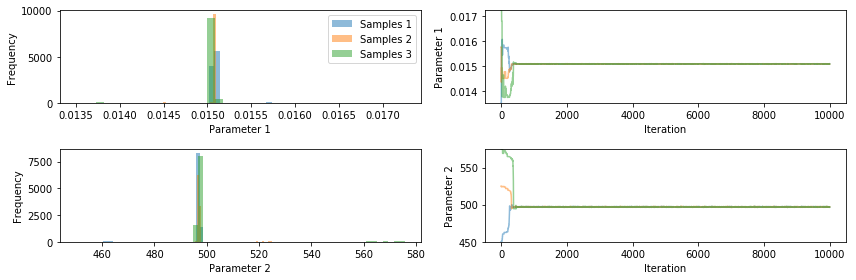

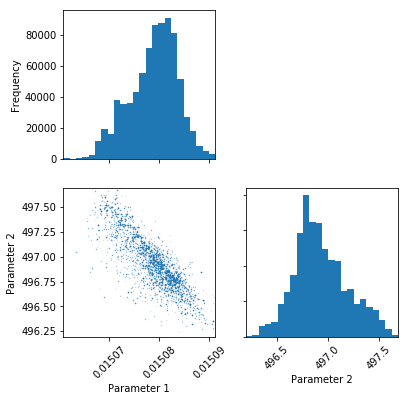

In [28]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

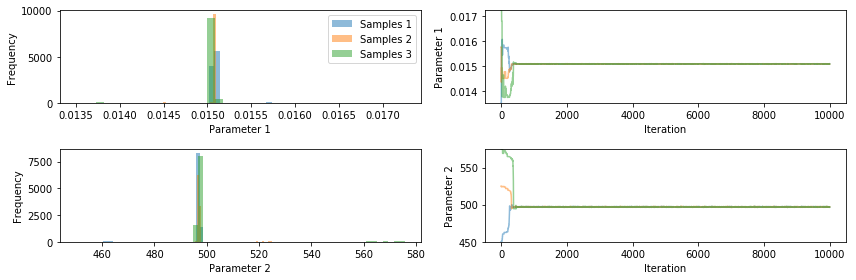

In [29]:
pints.plot.trace(chains_emu)
plt.show()

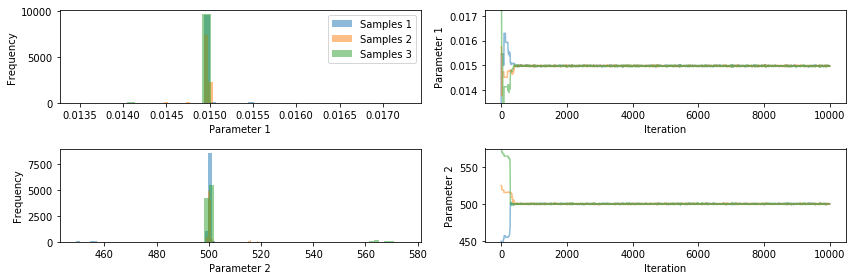

In [30]:
pints.plot.trace(chains)
plt.show()

In [31]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

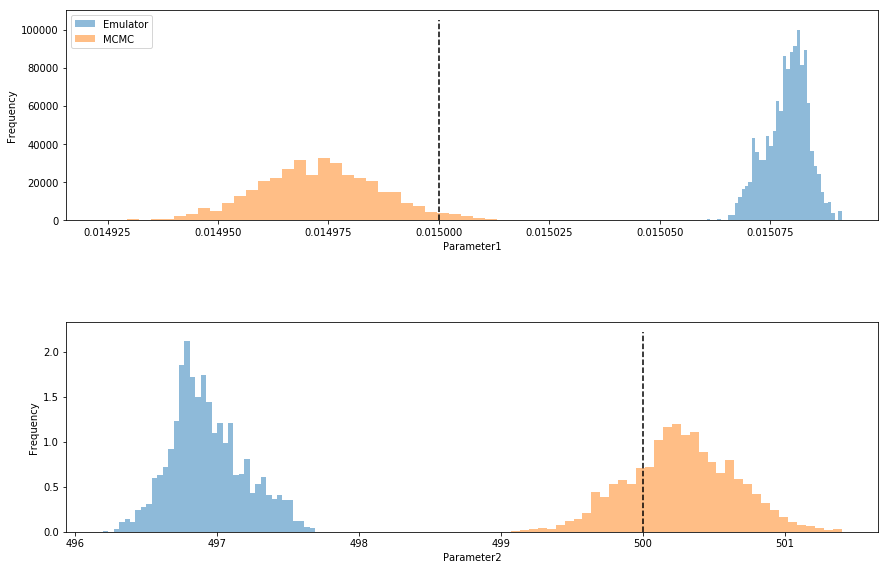

In [32]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

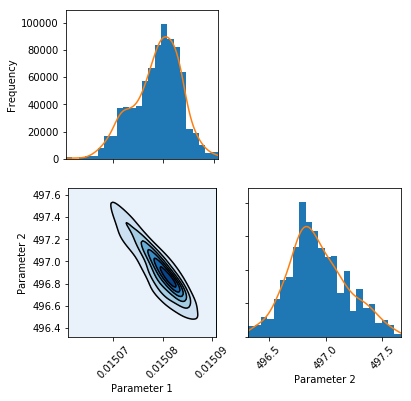

In [33]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

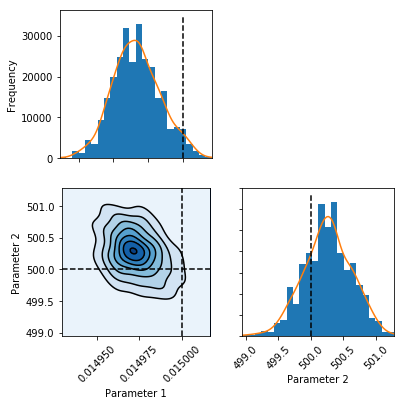

In [34]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

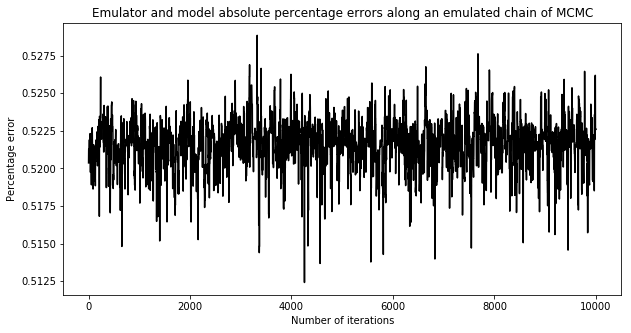

0.5216120410380638

In [35]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

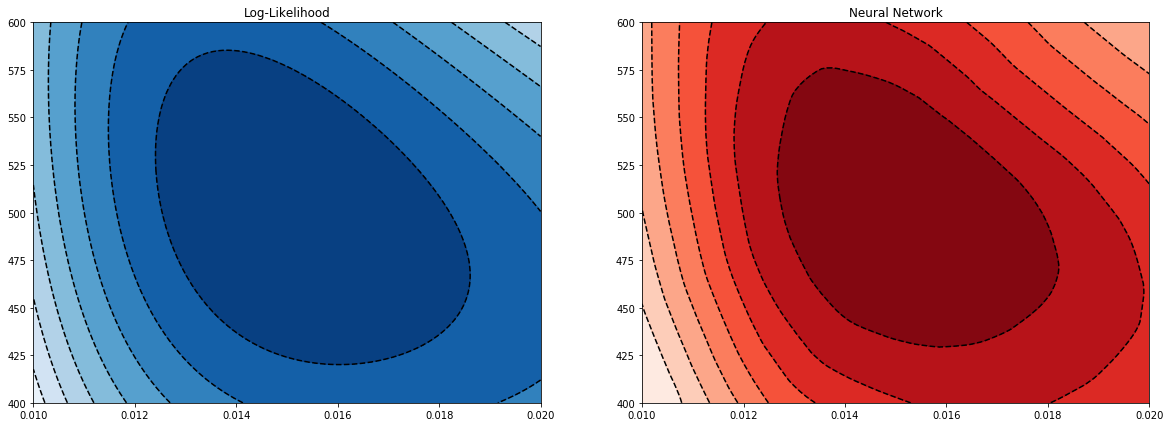

In [36]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

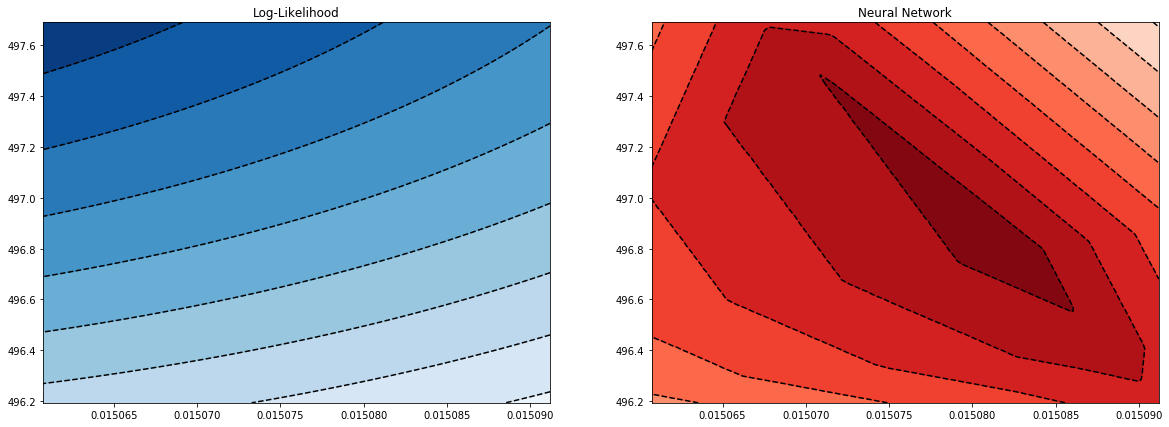

In [37]:
# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

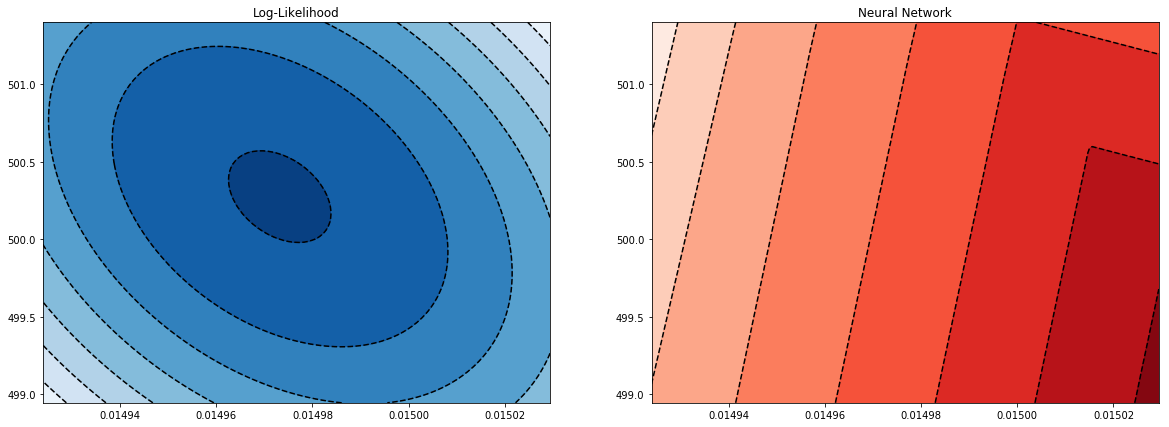

In [38]:
# Create grid
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

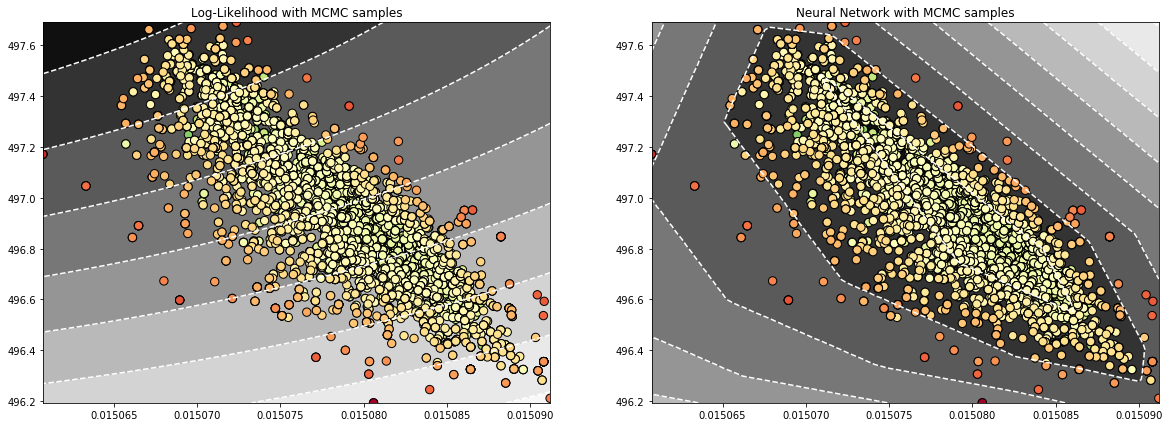

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to likelihood error
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

plt.show()

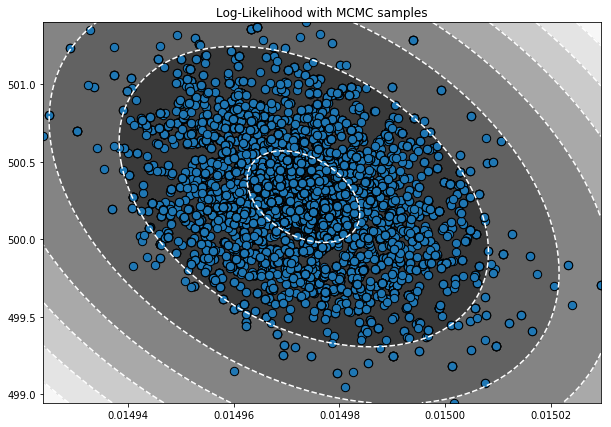

In [40]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()